In [1]:
import pandas as pd
from collections import Counter
from itertools import combinations
import numpy as np
import ast
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import copy
import networkx as nx
import random
from uuid import uuid4

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

###

import tensorflow as tf

2023-12-05 01:27:21.014444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


What do I want to know:

Which territories serve the most utility in winning the game?

How can I address this:

1. Which neutral SCs are most accessible? Which countries have the best access?
2. Which countries have the most defensible SCs?
3. Which territories touch the greatest number of other territories? (area control)
3. Which territories touch the fewest number of other territories? (choke points)

territories = {
    'Ankara':['Smyrna', 'Constantinople', 'Black Sea', 'Armenia'],
    'Belgium': ['English Channel', 'North Sea', 'Picardy', 'Burgundy', 'Ruhr', 'Holland'],
    'Berlin': ['Baltic Sea', 'Kiel', 'Munich', 'Silesia', 'Prussia'],
    'Brest': ['English Channel', 'Mid Atlantic Ocean', 'Picardy', 'Paris', 'Gascony'],
    'Budapest': ['Galicia', 'Vienna', 'Trieste', 'Serbia', 'Rumania'],
    'Bulgaria': ['Rumania', 'Black Sea', 'Constantinople', 'Aegean Sea', 'Greece', 'Serbia'],
    'Bulgaria_ec': ['Rumania', 'Black Sea', 'Constantinople'],
    'Bulgaria_sc': ['Greece', 'Aegean Sea', 'Constantinople'],
    'Constantinople': ['Black Sea', 'Ankara', 'Smyrna', 'Aegean Sea', 'Bulgaria', 'Bulgaria_ec', 'Bulgaria_sc'],
    'Denmark': ['Helgoland Bight', 'North Sea', 'Skagerrack', 'Sweden', 'Baltic Sea', 'Kiel'],
    'Edinburgh': ['Norwegian Sea', 'North Sea', 'Yorkshire', 'Liverpool', 'Clyde'],
    'Greece': ['Aegean Sea', 'Ionian Sea', 'Albania', 'Serbia', 'Bulgaria', 'Bulgaria_sc'],
    'Holland': ['Helgoland Bight', 'North Sea', 'Belgium', 'Ruhr', 'Kiel'],
    'Kiel': ['Ruhr', 'Holland', 'Helgoland Bight', 'Denmark', 'Baltic Sea', 'Berlin', 'Munich'],
    'Liverpool': ['Clyde', 'Edinburgh', 'Yorkshire', 'Whales', 'North Atlantic Ocean', 'Irish Sea'],
    'London': ['North Sea', 'English Channel', 'Yorkshire', 'Whales'],
    'Marseiles': ['Burgundy', 'Gascony', 'Spain', 'Spain_sc', 'Piedmont', 'Gulf of Lyon'],
    'Moscow': ['St Petersburg', 'Livonia', 'Warsaw', 'Ukraine', 'Sevastopol'],
    'Munich': ['Berlin', 'Kiel', 'Ruhr', 'Burgundy', 'Tyrolia', 'Bohemia', 'Silesia'],
    'Naples': ['Ionian Sea', 'Tyrrhenian Sea', 'Rome', 'Apulia'],
    'Norway': ['Norwegian Sea', 'Barents Sea', 'St Petersburg', 'St Petersburg_nc', 'North Sea', 'Skagerrack', 'Sweden', 'Finland'],
    'Paris': ['Picardy', 'Brest', 'Gascony', 'Burgundy'],
    'Portugal': ['Spain', 'Spain_nc', 'Spain_sc', 'Mid Atlantic Ocean'],
    'Rome': ['Tuscany', 'Venice', 'Apulia', 'Naples', 'Tyrrhenian Sea'],
    'Rumania': ['Sevastopol', 'Ukraine', 'Galicia', 'Budapest', 'Serbia', 'Bulgaria', 'Bulgaria_ec', 'Black Sea'],
    'St Petersburg': ['Moscow', 'Livonia', 'Gulf of Bothnia', 'Finland', 'Norway', 'Barents Sea'],
    'St Petersburg_nc': ['Barents Sea', 'Norway'],
    'St Petersburg_sc': ['Finland', 'Gulf of Bothnia', 'Livonia'],
    'Serbia': ['Budapest', 'Trieste', 'Albania', 'Greece', 'Bulgaria', 'Rumania'],
    'Sevastopol': ['Armenia', 'Black Sea', 'Rumania', 'Ukraine', 'Moscow'],
    'Smyrna': ['Syria', 'Eastern Mediterranean', 'Aegean Sea', 'Constantinople'],
    'Spain': ['Marseiles', 'Gulf of Lyon', 'Western Mediterranean', 'Mid Atlantic Ocean', 'Gascony', 'Portugal'],
    'Spain_nc': ['Mid Atlantic Ocean', 'Gascony', 'Portugal'],
    'Spain_sc': ['Portugal', 'Mid Atlantic Ocean', 'Western Mediterranean', 'Gulf of Lyon', 'Marseiles'],
    'Sweden': ['Norway', 'Finland', 'Gulf of Bothnia', 'Baltic Sea', 'Denmark', 'Skagerrack'],
    'Trieste': ['Venice', 'Tyrolia', 'Vienna', 'Budapest', 'Serbia', 'Albania', 'Adriatic Sea'],
    'Tunis': ['Ionian Sea', 'Tyrrhenian Sea', 'Western Mediterranean', 'North Africa'],
    'Venice': ['Piedmont', 'Tyrolia', 'Trieste', 'Adriatic Sea', 'Apulia', 'Rome', 'Tuscany'],
    'Vienna': ['Galicia', 'Budapest', 'Trieste', 'Tyrolia', 'Bohemia'],
    'Warsaw': ['Livonia', 'Moscow', 'Ukraine', 'Galicia', 'Silesia', 'Prussia'],
    'Clyde': ['Norwegian Sea', 'North Atlantic Ocean', 'Edinburgh', 'Liverpool'],
    'Yorkshire': ['Edinburgh', 'Liverpool', 'Whales', 'London', 'North Sea'],
    'North Atlantic Ocean': ['Norwegian Sea', 'Irish Sea', 'Mid Atlantic Ocean', 'Clyde', 'Liverpool'],
    'Mid Atlantic Ocean': ['North Atlantic Ocean', 'Irish Sea', 'English Channel', 'Western Mediterranean', 'Spain', 'Spain_nc', 'Portugal', 'Spain_sc', 'Gascony', 'Brest'],
    'Norwegian Sea': ['Barents Sea', 'North Atlantic Ocean', 'North Sea', 'Clyde', 'Edinburgh', 'Norway'],
    'North Sea': ['Norwegian Sea', 'Skagerrack', 'Helgoland Bight', 'English Channel', 'Norway', 'Denmark', 'Holland', 'Belgium', 'London', 'Yorkshire', 'Edinburgh'],
    'English Channel': ['North Sea', 'Belgium', 'Picardy', 'Brest', 'Mid Atlantic Ocean', 'Irish Sea', 'Whales', 'London'],
    'Irish Sea': ['North Atlantic Ocean', 'Liverpool', 'Whales', 'English Channel', 'Mid Atlantic Ocean'],
    'Skagerrack': ['North Sea', 'Norway', 'Sweden', 'Denmark'],
    'Baltic Sea': ['Gulf of Bothnia', 'Livonia', 'Prussia', 'Berlin', 'Kiel', 'Denmark', 'Sweden'],
    'Gulf of Bothnia': ['Sweden', 'Finland', 'St Petersburg', 'St Petersburg_sc', 'Livonia', 'Baltic Sea'],
    'Barents Sea': ['Norwegian Sea', 'Norway', 'St Petersburg', 'St Petersburg_nc'],
    'Western Mediterranean': ['Mid Atlantic Ocean', 'North Africa', 'Tunis', 'Tyrrhenian Sea', 'Gulf of Lyon', 'Spain', 'Spain_sc'],
    'Gulf of Lyon': ['Marseiles', 'Piedmont', 'Tuscany', 'Tyrrhenian Sea', 'Western Mediterranean', 'Spain', 'Spain_sc'],
    'Tyrrhenian Sea': ['Ionian Sea', 'Naples', 'Rome', 'Tuscany', 'Gulf of Lyon', 'Western Mediterranean', 'Tunis'],
    'Ionian Sea': ['Tunis', 'Tyrrhenian Sea', 'Naples', 'Apulia', 'Adriatic Sea', 'Albania', 'Greece', 'Aegean Sea', 'Eastern Mediterranean'],
    'Adriatic Sea': ['Apulia', 'Venice', 'Trieste', 'Albania', 'Ionian Sea'],
    'Aegean Sea': ['Ionian Sea', 'Greece', 'Bulgaria', 'Bulgaria_sc', 'Constantinople', 'Smyrna', 'Eastern Mediterranean'],
    'Eastern Mediterranean': ['Syria', 'Smyrna', 'Aegean Sea', 'Ionian Sea'],
    'Black Sea': ['Sevastopol', 'Armenia', 'Ankara', 'Constantinople', 'Bulgaria', 'Bulgaria_ec', 'Rumania'],
    'Picardy': ['Brest', 'Paris', 'Burgundy', 'Belgium', 'English Channel'],
    'Gascony': ['Brest', 'Paris', 'Burgundy', 'Marseiles', 'Spain', 'Mid Atlantic Ocean'],
    'Burgundy': ['Paris', 'Picardy', 'Belgium', 'Ruhr', 'Munich', 'Marseiles', 'Gascony'],
    'North Africa': ['Tunis', 'Western Mediterranean', 'Mid Atlantic Ocean'],
    'Ruhr': ['Belgium', 'Holland', 'Kiel', 'Munich', 'Burgundy'],
    'Prussia': ['Baltic Sea', 'Livonia', 'Warsaw', 'Silesia', 'Berlin'],
    'Silesia': ['Prussia', 'Warsaw', 'Galicia', 'Bohemia', 'Munich', 'Berlin'],
    'Piedmont': ['Tyrolia', 'Venice', 'Tuscany', 'Marseiles', 'Gulf of Lyon'],
    'Tuscany': ['Venice', 'Rome', 'Tyrrhenian Sea', 'Gulf of Lyon', 'Piedmont'],
    'Apulia': ['Adriatic Sea', 'Venice', 'Ionian Sea', 'Naples', 'Rome'],
    'Tyrolia': ['Munich', 'Bohemia', 'Vienna', 'Trieste', 'Venice', 'Piedmont'],
    'Galicia': ['Warsaw', 'Ukraine', 'Rumania', 'Budapest', 'Vienna', 'Bohemia', 'Silesia'],
    'Bohemia': ['Silesia', 'Galicia', 'Vienna', 'Tyrolia', 'Munich'],
    'Finland': ['Norway', 'St Petersburg', 'Gulf of Bothnia', 'Sweden'],
    'Livonia': ['Gulf of Bothnia', 'St Petersburg', 'Moscow', 'Prussia', 'Baltic Sea'],
    'Ukraine': ['Moscow', 'Sevastopol', 'Rumania', 'Galicia', 'Warsaw'],
    'Albania': ['Adriatic Sea', 'Trieste', 'Serbia', 'Greece', 'Ionian Sea'],
    'Armenia': ['Sevastopol', 'Syria', 'Smyrna', 'Ankara', 'Black Sea'],
    'Syria': ['Armenia', 'Eastern Mediterranean', 'Smyrna'],
    'Helgoland Bight': ['Denmark', 'Kiel', 'Holland', 'North Sea'],
    'Whales': ['English Channel', 'Irish Sea', 'Liverpool', 'Yorkshire', 'London']
}

sea_territories = ['North Atlantic Ocean',
'Mid Atlantic Ocean',
'Norwegian Sea',
'North Sea',
'English Channel',
'Irish Sea',
'Helgoland Bight',
'Skagerrack',
'Baltic Sea',
'Gulf of Bothnia',
'Barents Sea',
'Western Mediterranean',
'Gulf of Lyon',
'Tyrrhenian Sea',
'Ionian Sea',
'Adriatic Sea',
'Aegean Sea',
'Eastern Mediterranean',
'Black Sea',
'Bulgaria_ec',
'Bulgaria_sc',
'St Petersburg_nc',
'St Petersburg_sc',
'Spain_nc',
'Spain_sc']

coast = ['Bulgaria_ec',
         'Bulgaria_sc',
         'St Petersburg_nc',
         'St Petersburg_sc',
         'Spain_nc',
         'Spain_sc']

coastal = ['Syria',
           'Smyrna',
           'Constantinople',
           'Rumania',
           'Sevastopol',
           'Armenia',
           'Ankara',
           'Greece',
           'Albania',
           'Trieste',
           'Venice',
           'Apulia',
           'Naples',
           'Rome',
           'Tuscany',
           'Piedmont',
           'Marseiles',
           'Portugal',
           'North Africa',
           'Tunis',
           'Gascony',
           'Brest',
           'Picardy',
           'Belgium',
           'Holland',
           'Kiel',
           'Denmark',
           'Berlin',
           'Prussia',
           'Livonia',
           'Finland',
           'Sweden',
           'Norway',
           'Edinburgh',
           'Yorkshire',
           'London',
           'Whales',
           'Liverpool',
           'Clyde']

sc = [
    'Ankara',
    'Belgium',
    'Berlin',
    'Brest',
    'Budapest',
    'Bulgaria',
    'Bulgaria_ec',
    'Bulgaria_sc',
    'Constantinople',
    'Denmark',
    'Edinburgh',
    'Greece',
    'Holland',
    'Kiel',
    'Liverpool',
    'London',
    'Marseiles',
    'Moscow',
    'Munich',
    'Naples',
    'Norway',
    'Paris',
    'Portugal',
    'Rome',
    'Rumania',
    'St Petersburg',
    'St Petersburg_nc',
    'St Petersburg_sc',
    'Serbia',
    'Sevastopol',
    'Smyrna',
    'Spain',
    'Spain_nc',
    'Spain_sc',
    'Sweden',
    'Trieste',
    'Tunis',
    'Venice',
    'Vienna',
    'Warsaw',
]

france = [
    'Gascony',
    'Marseiles',
    'Burgundy',
    'Paris',
    'Picardy',
    'Brest'
]

england = [
    'Clyde',
    'Edinburgh',
    'Yorkshire',
    'London',
    'Whales',
    'Liverpool'
]

germany = [
    'Kiel',
    'Berlin',
    'Prussia',
    'Silesia',
    'Munich',
    'Ruhr'
]

italy = [
    'Piedmont',
    'Venice',
    'Apulia',
    'Naples',
    'Rome',
    'Tuscany'
]

russia = [
    'Finland',
    'St Petersburg',
    'St Petersburg_nc',
    'St Petersburg_sc',
    'Moscow',
    'Sevastopol',
    'Ukraine',
    'Warsaw',
    'Livonia'
]

austria = [
    'Bohemia',
    'Tyrolia',
    'Galicia',
    'Vienna',
    'Budapest',
    'Trieste'
]

turkey = [
    'Constantinople',
    'Smyrna',
    'Ankara',
    'Armenia',
    'Syria'
]

for k, v in territories.items():
    territories[k] = {'connected_to': v}
    if k in sea_territories:
        territories[k]['unit_type'] = 'fleet'
    elif k in coastal:
        territories[k]['unit_type'] = 'both'
    else:
        territories[k]['unit_type'] = 'army'
    if k in coast:
        territories[k]['coast'] = True
    else:
        territories[k]['coast'] = False
    if k in sc:
        territories[k]['sc'] = True
    else:
        territories[k]['sc'] = False
    if k in france:
        territories[k]['controlled_by'] = 'france'
    elif k in italy:
        territories[k]['controlled_by'] = 'italy'
    elif k in england:
        territories[k]['controlled_by'] = 'england'
    elif k in russia:
        territories[k]['controlled_by'] = 'russia'
    elif k in germany:
        territories[k]['controlled_by'] = 'germany'
    elif k in austria:
        territories[k]['controlled_by'] = 'austria'
    elif k in turkey:
        territories[k]['controlled_by'] = 'turkey'
    else:
        territories[k]['controlled_by'] = 'neutral'

coords_dict = {
'north_africa_army' : (240, 925),
'north_africa_fleet' : (240, 885),
'western_mediterranean' : (320, 850),
'tunis_army' : (450, 925),
'tunis_fleet' : (470, 895),
'ionian_sea' : (620, 925),
'aegean_sea' : (780, 900),
'eastern_mediterranean' : (880, 940),
'syria_fleet' : (1005, 940),
'syria_army' : (1080, 900),
'armenia_army' : (1100, 800),
'armenia_fleet' : (1060, 750),
'ankara_army' : (930, 800),
'ankara_fleet' : (930, 760),
'smyrna_army' : (930, 860),
'smyrna_fleet' : (900, 900),
'constantinople_army' : (850, 825),
'constantinople_fleet' : (830, 804),
'tyrrhenian_sea' : (500, 830),
'gulf_of_lyon' : (390, 760),
'adriatic_sea' : (600, 760),
'black_sea' : (930, 720),
'mid_atlantic_ocean' : (100, 580),
'north_atlantic_ocean' : (150, 200),
'norwegian_sea' : (475, 130),
'barents_sea' : (860, 25),
'gulf_of_bothnia' : (680, 320),
'baltic_sea' : (610, 435),
'skagerrack' : (540, 345),
'north_sea' : (430, 345),
'helgoland_bight' : (460, 435),
'irish_sea' : (235, 465),
'english_channel' : (290, 520),
'portugal_fleet' : (95, 750),
'portugal_army' : (125, 740),
'spain_army' : (225, 755),
'spain_nc' : (225, 670),
'spain_sc' : (255, 825),
'gascony_fleet' : (290, 650),
'gascony_army' : (320, 670),
'brest_army' : (310, 585),
'brest_fleet' : (260, 555),
'picardy_fleet' : (350, 533),
'picardy_army' : (375, 543),
'paris' : (355, 585),
'burgundy' : (400, 615),
'marseiles_army' : (405, 690),
'marseiles_fleet' : (370, 710),
'piedmont_fleet' : (465, 705),
'piedmont_army' : (460, 680),
'venice_army' : (510, 695),
'venice_fleet' : (530, 710),
'tuscany_army' : (515, 735),
'tuscany_fleet' : (490, 735),
'rome_army' : (535, 770),
'rome_fleet' : (535, 790),
'apulia_fleet' : (590, 780),
'apulia_army' : (600, 810),
'naples_army' : (570, 805),
'naples_fleet' : (590, 860),
'greece_army' : (700, 840),
'greece_fleet' : (700, 890),
'bulgaria_sc' : (775, 805),
'bulgaria_army' : (775, 755),
'bulgaria_ec' : (815, 755),
'rumania_fleet' : (830, 710),
'rumania_army' : (760, 710),
'serbia' : (690, 740),
'albania_army' : (675, 815),
'albania_fleet' : (660, 790),
'trieste_army' : (620, 700),
'trieste_fleet' : (600, 740),
'budapest' : (690, 650),
'galicia' : (740, 590),
'vienna' : (615, 615),
'tyrolia' : (570, 625),
'bohemia' : (575, 575),
'munich' : (500, 580),
'silesia' : (610, 530),
'prussia_army' : (620, 485),
'prussia_fleet' : (640, 450),
'berlin_fleet' : (570, 455),
'berlin_army' : (565, 495),
'kiel_army' : (510, 495),
'kiel_fleet' : (490, 460),
'ruhr' : (470, 540),
'belgium_army' : (420, 535),
'belgium_fleet' : (395, 505),
'holland_fleet' : (430, 485),
'holland_army' : (442, 505),
'denmark_army' : (515, 405),
'denmark_fleet' : (540, 420),
'norway_army' : (540, 280),
'norway_fleet' : (480, 330),
'sweden_army' : (595, 330),
'sweden_fleet' : (650, 310),
'finland_fleet' : (685, 250),
'finland_army' : (740, 250),
'st_petersburg_army' : (890, 250),
'st_petersburg_nc' : (845, 185),
'st_petersburg_sc' : (800, 300),
'moscow' : (890, 420),
'livonia_army' : (740, 420),
'livonia_fleet' : (730, 375),
'warsaw' : (700, 515),
'ukraine' : (830, 550),
'sevastopol_army' : (960, 550),
'sevastopol_fleet' : (960, 620),
'edinburgh_fleet' : (375, 330),
'edinburgh_army' : (340, 360),
'yorkshire_army' : (355, 440),
'yorkshire_fleet' : (360, 405),
'london_army' : (350, 480),
'london_fleet' : (390, 465),
'whales_army' : (315, 455),
'whales_fleet' : (280, 480),
'liverpool_army' : (332, 440),
'liverpool_fleet' : (332, 415),
'clyde_army' : (325, 375),
'clyde_fleet' : (335, 295)
}
coords_dict = {k.replace('_', ' '):v for k, v in coords_dict.items()}

for k, v in territories.items():
    if v['unit_type'] == 'army':
        try:
            territories[k]['coords'] = {'army': coords_dict[k.lower()], 'fleet': np.nan}
        except KeyError:
            territories[k]['coords'] = {'army': coords_dict[k.lower()+' army'], 'fleet': np.nan}
    elif v['unit_type'] == 'both':
        territories[k]['coords'] = {'army': coords_dict[k.lower()+' army'],
                                    'fleet': coords_dict[k.lower()+' fleet']}
    else:
        if v['coast']:
            territories[k]['coords'] = {'army': np.nan, 'fleet': coords_dict[k.lower()[:-3]+' '+k[-2:]]}
        else:
            territories[k]['coords'] = {'army': np.nan, 'fleet': coords_dict[k.lower()]}

G = nx.Graph()
for k, v in territories.items():
    G.add_nodes_from([(k, v)])
for k, v in territories.items():
    for c in v['connected_to']:
        G.add_edge(k, c)

territories_df = pd.DataFrame(territories).T.reset_index()
territories_df = territories_df.rename(columns = {'index':'country'})
territories_df['start_control'] = territories_df['controlled_by']
territories_df['sc_control'] = territories_df['controlled_by']

convoy_pairs = []
convoyable_countries = territories_df[(territories_df['unit_type']=='both')|(territories_df['country'].isin(['Bulgaria', 'Spain', 'St Petersburg']))]['country'].tolist()
for c_1 in convoyable_countries:
    for c_2 in convoyable_countries:
        if c_1 != c_2:
            G_sub = nx.Graph(G.subgraph([x for x,y in G.nodes(data=True) if (x in [c_1, c_2]) or (y['unit_type'] == 'fleet' and not y['coast'])]))
            if G_sub.has_edge(c_1, c_2):
                G_sub.remove_edge(c_1, c_2)
            if nx.has_path(G_sub, c_1, c_2):
                convoy_pairs.append((c_1, c_2))

units = {'location':['Marseiles',
                     'Brest',
                     'Paris',
                     'Edinburgh',
                     'Liverpool',
                     'London',
                     'Kiel',
                     'Berlin',
                     'Munich',
                     'Venice',
                     'Rome',
                     'Naples',
                     'Vienna', 
                     'Budapest', 
                     'Trieste',
                     'Constantinople',
                     'Ankara',
                     'Smyrna',
                     'St Petersburg_sc',
                     'Moscow',
                     'Warsaw',
                     'Sevastopol'],
         'type':['army',
                 'fleet',
                 'army',
                 'fleet',
                 'army',
                 'fleet',
                 'fleet',
                 'army',
                 'army',
                 'army',
                 'army',
                 'fleet',
                 'army',
                 'army',
                 'fleet',
                 'army',
                 'fleet',
                 'army',
                 'fleet',
                 'army',
                 'army',
                 'fleet'],
         'owner':['france',
                  'france',
                  'france',
                  'england',
                  'england',
                  'england',
                  'germany',
                  'germany',
                  'germany',
                  'italy',
                  'italy',
                  'italy',
                  'austria',
                  'austria',
                  'austria',
                  'turkey',
                  'turkey',
                  'turkey',
                  'russia',
                  'russia',
                  'russia',
                  'russia']}

units_df = pd.DataFrame(units)
units_df['unit_id'] = [str(uuid4()) for _ in range(units_df.shape[0])]

possible actions:
- move
- hold
- support
- convoy

check valid move:
- if action is move, are start and stop adjacent
    - if action is move via convoy, are ships in place and convoying
- if action is move, is end suitable for unit type
- if action is support, is move action valid

In [3]:
def set_up_game():
    territories = {
        'Ankara':['Smyrna', 'Constantinople', 'Black Sea', 'Armenia'],
        'Belgium': ['English Channel', 'North Sea', 'Picardy', 'Burgundy', 'Ruhr', 'Holland'],
        'Berlin': ['Baltic Sea', 'Kiel', 'Munich', 'Silesia', 'Prussia'],
        'Brest': ['English Channel', 'Mid Atlantic Ocean', 'Picardy', 'Paris', 'Gascony'],
        'Budapest': ['Galicia', 'Vienna', 'Trieste', 'Serbia', 'Rumania'],
        'Bulgaria': ['Rumania', 'Black Sea', 'Constantinople', 'Aegean Sea', 'Greece', 'Serbia'],
        'Bulgaria_ec': ['Rumania', 'Black Sea', 'Constantinople'],
        'Bulgaria_sc': ['Greece', 'Aegean Sea', 'Constantinople'],
        'Constantinople': ['Black Sea', 'Ankara', 'Smyrna', 'Aegean Sea', 'Bulgaria', 'Bulgaria_ec', 'Bulgaria_sc'],
        'Denmark': ['Helgoland Bight', 'North Sea', 'Skagerrack', 'Sweden', 'Baltic Sea', 'Kiel'],
        'Edinburgh': ['Norwegian Sea', 'North Sea', 'Yorkshire', 'Liverpool', 'Clyde'],
        'Greece': ['Aegean Sea', 'Ionian Sea', 'Albania', 'Serbia', 'Bulgaria', 'Bulgaria_sc'],
        'Holland': ['Helgoland Bight', 'North Sea', 'Belgium', 'Ruhr', 'Kiel'],
        'Kiel': ['Ruhr', 'Holland', 'Helgoland Bight', 'Denmark', 'Baltic Sea', 'Berlin', 'Munich'],
        'Liverpool': ['Clyde', 'Edinburgh', 'Yorkshire', 'Whales', 'North Atlantic Ocean', 'Irish Sea'],
        'London': ['North Sea', 'English Channel', 'Yorkshire', 'Whales'],
        'Marseiles': ['Burgundy', 'Gascony', 'Spain', 'Spain_sc', 'Piedmont', 'Gulf of Lyon'],
        'Moscow': ['St Petersburg', 'Livonia', 'Warsaw', 'Ukraine', 'Sevastopol'],
        'Munich': ['Berlin', 'Kiel', 'Ruhr', 'Burgundy', 'Tyrolia', 'Bohemia', 'Silesia'],
        'Naples': ['Ionian Sea', 'Tyrrhenian Sea', 'Rome', 'Apulia'],
        'Norway': ['Norwegian Sea', 'Barents Sea', 'St Petersburg', 'St Petersburg_nc', 'North Sea', 'Skagerrack', 'Sweden', 'Finland'],
        'Paris': ['Picardy', 'Brest', 'Gascony', 'Burgundy'],
        'Portugal': ['Spain', 'Spain_nc', 'Spain_sc', 'Mid Atlantic Ocean'],
        'Rome': ['Tuscany', 'Venice', 'Apulia', 'Naples', 'Tyrrhenian Sea'],
        'Rumania': ['Sevastopol', 'Ukraine', 'Galicia', 'Budapest', 'Serbia', 'Bulgaria', 'Bulgaria_ec', 'Black Sea'],
        'St Petersburg': ['Moscow', 'Livonia', 'Gulf of Bothnia', 'Finland', 'Norway', 'Barents Sea'],
        'St Petersburg_nc': ['Barents Sea', 'Norway'],
        'St Petersburg_sc': ['Finland', 'Gulf of Bothnia', 'Livonia'],
        'Serbia': ['Budapest', 'Trieste', 'Albania', 'Greece', 'Bulgaria', 'Rumania'],
        'Sevastopol': ['Armenia', 'Black Sea', 'Rumania', 'Ukraine', 'Moscow'],
        'Smyrna': ['Syria', 'Eastern Mediterranean', 'Aegean Sea', 'Constantinople'],
        'Spain': ['Marseiles', 'Gulf of Lyon', 'Western Mediterranean', 'Mid Atlantic Ocean', 'Gascony', 'Portugal'],
        'Spain_nc': ['Mid Atlantic Ocean', 'Gascony', 'Portugal'],
        'Spain_sc': ['Portugal', 'Mid Atlantic Ocean', 'Western Mediterranean', 'Gulf of Lyon', 'Marseiles'],
        'Sweden': ['Norway', 'Finland', 'Gulf of Bothnia', 'Baltic Sea', 'Denmark', 'Skagerrack'],
        'Trieste': ['Venice', 'Tyrolia', 'Vienna', 'Budapest', 'Serbia', 'Albania', 'Adriatic Sea'],
        'Tunis': ['Ionian Sea', 'Tyrrhenian Sea', 'Western Mediterranean', 'North Africa'],
        'Venice': ['Piedmont', 'Tyrolia', 'Trieste', 'Adriatic Sea', 'Apulia', 'Rome', 'Tuscany'],
        'Vienna': ['Galicia', 'Budapest', 'Trieste', 'Tyrolia', 'Bohemia'],
        'Warsaw': ['Livonia', 'Moscow', 'Ukraine', 'Galicia', 'Silesia', 'Prussia'],
        'Clyde': ['Norwegian Sea', 'North Atlantic Ocean', 'Edinburgh', 'Liverpool'],
        'Yorkshire': ['Edinburgh', 'Liverpool', 'Whales', 'London', 'North Sea'],
        'North Atlantic Ocean': ['Norwegian Sea', 'Irish Sea', 'Mid Atlantic Ocean', 'Clyde', 'Liverpool'],
        'Mid Atlantic Ocean': ['North Atlantic Ocean', 'Irish Sea', 'English Channel', 'Western Mediterranean', 'Spain', 'Spain_nc', 'Portugal', 'Spain_sc', 'Gascony', 'Brest'],
        'Norwegian Sea': ['Barents Sea', 'North Atlantic Ocean', 'North Sea', 'Clyde', 'Edinburgh', 'Norway'],
        'North Sea': ['Norwegian Sea', 'Skagerrack', 'Helgoland Bight', 'English Channel', 'Norway', 'Denmark', 'Holland', 'Belgium', 'London', 'Yorkshire', 'Edinburgh'],
        'English Channel': ['North Sea', 'Belgium', 'Picardy', 'Brest', 'Mid Atlantic Ocean', 'Irish Sea', 'Whales', 'London'],
        'Irish Sea': ['North Atlantic Ocean', 'Liverpool', 'Whales', 'English Channel', 'Mid Atlantic Ocean'],
        'Skagerrack': ['North Sea', 'Norway', 'Sweden', 'Denmark'],
        'Baltic Sea': ['Gulf of Bothnia', 'Livonia', 'Prussia', 'Berlin', 'Kiel', 'Denmark', 'Sweden'],
        'Gulf of Bothnia': ['Sweden', 'Finland', 'St Petersburg', 'St Petersburg_sc', 'Livonia', 'Baltic Sea'],
        'Barents Sea': ['Norwegian Sea', 'Norway', 'St Petersburg', 'St Petersburg_nc'],
        'Western Mediterranean': ['Mid Atlantic Ocean', 'North Africa', 'Tunis', 'Tyrrhenian Sea', 'Gulf of Lyon', 'Spain', 'Spain_sc'],
        'Gulf of Lyon': ['Marseiles', 'Piedmont', 'Tuscany', 'Tyrrhenian Sea', 'Western Mediterranean', 'Spain', 'Spain_sc'],
        'Tyrrhenian Sea': ['Ionian Sea', 'Naples', 'Rome', 'Tuscany', 'Gulf of Lyon', 'Western Mediterranean', 'Tunis'],
        'Ionian Sea': ['Tunis', 'Tyrrhenian Sea', 'Naples', 'Apulia', 'Adriatic Sea', 'Albania', 'Greece', 'Aegean Sea', 'Eastern Mediterranean'],
        'Adriatic Sea': ['Apulia', 'Venice', 'Trieste', 'Albania', 'Ionian Sea'],
        'Aegean Sea': ['Ionian Sea', 'Greece', 'Bulgaria', 'Bulgaria_sc', 'Constantinople', 'Smyrna', 'Eastern Mediterranean'],
        'Eastern Mediterranean': ['Syria', 'Smyrna', 'Aegean Sea', 'Ionian Sea'],
        'Black Sea': ['Sevastopol', 'Armenia', 'Ankara', 'Constantinople', 'Bulgaria', 'Bulgaria_ec', 'Rumania'],
        'Picardy': ['Brest', 'Paris', 'Burgundy', 'Belgium', 'English Channel'],
        'Gascony': ['Brest', 'Paris', 'Burgundy', 'Marseiles', 'Spain', 'Mid Atlantic Ocean'],
        'Burgundy': ['Paris', 'Picardy', 'Belgium', 'Ruhr', 'Munich', 'Marseiles', 'Gascony'],
        'North Africa': ['Tunis', 'Western Mediterranean', 'Mid Atlantic Ocean'],
        'Ruhr': ['Belgium', 'Holland', 'Kiel', 'Munich', 'Burgundy'],
        'Prussia': ['Baltic Sea', 'Livonia', 'Warsaw', 'Silesia', 'Berlin'],
        'Silesia': ['Prussia', 'Warsaw', 'Galicia', 'Bohemia', 'Munich', 'Berlin'],
        'Piedmont': ['Tyrolia', 'Venice', 'Tuscany', 'Marseiles', 'Gulf of Lyon'],
        'Tuscany': ['Venice', 'Rome', 'Tyrrhenian Sea', 'Gulf of Lyon', 'Piedmont'],
        'Apulia': ['Adriatic Sea', 'Venice', 'Ionian Sea', 'Naples', 'Rome'],
        'Tyrolia': ['Munich', 'Bohemia', 'Vienna', 'Trieste', 'Venice', 'Piedmont'],
        'Galicia': ['Warsaw', 'Ukraine', 'Rumania', 'Budapest', 'Vienna', 'Bohemia', 'Silesia'],
        'Bohemia': ['Silesia', 'Galicia', 'Vienna', 'Tyrolia', 'Munich'],
        'Finland': ['Norway', 'St Petersburg', 'Gulf of Bothnia', 'Sweden'],
        'Livonia': ['Gulf of Bothnia', 'St Petersburg', 'Moscow', 'Prussia', 'Baltic Sea'],
        'Ukraine': ['Moscow', 'Sevastopol', 'Rumania', 'Galicia', 'Warsaw'],
        'Albania': ['Adriatic Sea', 'Trieste', 'Serbia', 'Greece', 'Ionian Sea'],
        'Armenia': ['Sevastopol', 'Syria', 'Smyrna', 'Ankara', 'Black Sea'],
        'Syria': ['Armenia', 'Eastern Mediterranean', 'Smyrna'],
        'Helgoland Bight': ['Denmark', 'Kiel', 'Holland', 'North Sea'],
        'Whales': ['English Channel', 'Irish Sea', 'Liverpool', 'Yorkshire', 'London']
    }
    
    sea_territories = ['North Atlantic Ocean',
    'Mid Atlantic Ocean',
    'Norwegian Sea',
    'North Sea',
    'English Channel',
    'Irish Sea',
    'Helgoland Bight',
    'Skagerrack',
    'Baltic Sea',
    'Gulf of Bothnia',
    'Barents Sea',
    'Western Mediterranean',
    'Gulf of Lyon',
    'Tyrrhenian Sea',
    'Ionian Sea',
    'Adriatic Sea',
    'Aegean Sea',
    'Eastern Mediterranean',
    'Black Sea',
    'Bulgaria_ec',
    'Bulgaria_sc',
    'St Petersburg_nc',
    'St Petersburg_sc',
    'Spain_nc',
    'Spain_sc']

    coast = ['Bulgaria_ec',
             'Bulgaria_sc',
             'St Petersburg_nc',
             'St Petersburg_sc',
             'Spain_nc',
             'Spain_sc']

    coastal = ['Syria',
               'Smyrna',
               'Constantinople',
               'Rumania',
               'Sevastopol',
               'Armenia',
               'Ankara',
               'Greece',
               'Albania',
               'Trieste',
               'Venice',
               'Apulia',
               'Naples',
               'Rome',
               'Tuscany',
               'Piedmont',
               'Marseiles',
               'Portugal',
               'North Africa',
               'Tunis',
               'Gascony',
               'Brest',
               'Picardy',
               'Belgium',
               'Holland',
               'Kiel',
               'Denmark',
               'Berlin',
               'Prussia',
               'Livonia',
               'Finland',
               'Sweden',
               'Norway',
               'Edinburgh',
               'Yorkshire',
               'London',
               'Whales',
               'Liverpool',
               'Clyde']

    sc = [
        'Ankara',
        'Belgium',
        'Berlin',
        'Brest',
        'Budapest',
        'Bulgaria',
        'Bulgaria_ec',
        'Bulgaria_sc',
        'Constantinople',
        'Denmark',
        'Edinburgh',
        'Greece',
        'Holland',
        'Kiel',
        'Liverpool',
        'London',
        'Marseiles',
        'Moscow',
        'Munich',
        'Naples',
        'Norway',
        'Paris',
        'Portugal',
        'Rome',
        'Rumania',
        'St Petersburg',
        'St Petersburg_nc',
        'St Petersburg_sc',
        'Serbia',
        'Sevastopol',
        'Smyrna',
        'Spain',
        'Spain_nc',
        'Spain_sc',
        'Sweden',
        'Trieste',
        'Tunis',
        'Venice',
        'Vienna',
        'Warsaw',
    ]

    france = [
        'Gascony',
        'Marseiles',
        'Burgundy',
        'Paris',
        'Picardy',
        'Brest'
    ]

    england = [
        'Clyde',
        'Edinburgh',
        'Yorkshire',
        'London',
        'Whales',
        'Liverpool'
    ]

    germany = [
        'Kiel',
        'Berlin',
        'Prussia',
        'Silesia',
        'Munich',
        'Ruhr'
    ]

    italy = [
        'Piedmont',
        'Venice',
        'Apulia',
        'Naples',
        'Rome',
        'Tuscany'
    ]

    russia = [
        'Finland',
        'St Petersburg',
        'St Petersburg_nc',
        'St Petersburg_sc',
        'Moscow',
        'Sevastopol',
        'Ukraine',
        'Warsaw',
        'Livonia'
    ]

    austria = [
        'Bohemia',
        'Tyrolia',
        'Galicia',
        'Vienna',
        'Budapest',
        'Trieste'
    ]

    turkey = [
        'Constantinople',
        'Smyrna',
        'Ankara',
        'Armenia',
        'Syria'
    ]
    
    for k, v in territories.items():
        territories[k] = {'connected_to': v}
        if k in sea_territories:
            territories[k]['unit_type'] = 'fleet'
        elif k in coastal:
            territories[k]['unit_type'] = 'both'
        else:
            territories[k]['unit_type'] = 'army'
        if k in coast:
            territories[k]['coast'] = True
        else:
            territories[k]['coast'] = False
        if k in sc:
            territories[k]['sc'] = True
        else:
            territories[k]['sc'] = False
        if k in france:
            territories[k]['controlled_by'] = 'france'
        elif k in italy:
            territories[k]['controlled_by'] = 'italy'
        elif k in england:
            territories[k]['controlled_by'] = 'england'
        elif k in russia:
            territories[k]['controlled_by'] = 'russia'
        elif k in germany:
            territories[k]['controlled_by'] = 'germany'
        elif k in austria:
            territories[k]['controlled_by'] = 'austria'
        elif k in turkey:
            territories[k]['controlled_by'] = 'turkey'
        else:
            territories[k]['controlled_by'] = 'neutral'
    
    coords_dict = {
    'north_africa_army' : (240, 925),
    'north_africa_fleet' : (240, 885),
    'western_mediterranean' : (320, 850),
    'tunis_army' : (450, 925),
    'tunis_fleet' : (470, 895),
    'ionian_sea' : (620, 925),
    'aegean_sea' : (780, 900),
    'eastern_mediterranean' : (880, 940),
    'syria_fleet' : (1005, 940),
    'syria_army' : (1080, 900),
    'armenia_army' : (1100, 800),
    'armenia_fleet' : (1060, 750),
    'ankara_army' : (930, 800),
    'ankara_fleet' : (930, 760),
    'smyrna_army' : (930, 860),
    'smyrna_fleet' : (900, 900),
    'constantinople_army' : (850, 825),
    'constantinople_fleet' : (830, 804),
    'tyrrhenian_sea' : (500, 830),
    'gulf_of_lyon' : (390, 760),
    'adriatic_sea' : (600, 760),
    'black_sea' : (930, 720),
    'mid_atlantic_ocean' : (100, 580),
    'north_atlantic_ocean' : (150, 200),
    'norwegian_sea' : (475, 130),
    'barents_sea' : (860, 25),
    'gulf_of_bothnia' : (680, 320),
    'baltic_sea' : (610, 435),
    'skagerrack' : (540, 345),
    'north_sea' : (430, 345),
    'helgoland_bight' : (460, 435),
    'irish_sea' : (235, 465),
    'english_channel' : (290, 520),
    'portugal_fleet' : (95, 750),
    'portugal_army' : (125, 740),
    'spain_army' : (225, 755),
    'spain_nc' : (225, 670),
    'spain_sc' : (255, 825),
    'gascony_fleet' : (290, 650),
    'gascony_army' : (320, 670),
    'brest_army' : (310, 585),
    'brest_fleet' : (260, 555),
    'picardy_fleet' : (350, 533),
    'picardy_army' : (375, 543),
    'paris' : (355, 585),
    'burgundy' : (400, 615),
    'marseiles_army' : (405, 690),
    'marseiles_fleet' : (370, 710),
    'piedmont_fleet' : (465, 705),
    'piedmont_army' : (460, 680),
    'venice_army' : (510, 695),
    'venice_fleet' : (530, 710),
    'tuscany_army' : (515, 735),
    'tuscany_fleet' : (490, 735),
    'rome_army' : (535, 770),
    'rome_fleet' : (535, 790),
    'apulia_fleet' : (590, 780),
    'apulia_army' : (600, 810),
    'naples_army' : (570, 805),
    'naples_fleet' : (590, 860),
    'greece_army' : (700, 840),
    'greece_fleet' : (700, 890),
    'bulgaria_sc' : (775, 805),
    'bulgaria_army' : (775, 755),
    'bulgaria_ec' : (815, 755),
    'rumania_fleet' : (830, 710),
    'rumania_army' : (760, 710),
    'serbia' : (690, 740),
    'albania_army' : (675, 815),
    'albania_fleet' : (660, 790),
    'trieste_army' : (620, 700),
    'trieste_fleet' : (600, 740),
    'budapest' : (690, 650),
    'galicia' : (740, 590),
    'vienna' : (615, 615),
    'tyrolia' : (570, 625),
    'bohemia' : (575, 575),
    'munich' : (500, 580),
    'silesia' : (610, 530),
    'prussia_army' : (620, 485),
    'prussia_fleet' : (640, 450),
    'berlin_fleet' : (570, 455),
    'berlin_army' : (565, 495),
    'kiel_army' : (510, 495),
    'kiel_fleet' : (490, 460),
    'ruhr' : (470, 540),
    'belgium_army' : (420, 535),
    'belgium_fleet' : (395, 505),
    'holland_fleet' : (430, 485),
    'holland_army' : (442, 505),
    'denmark_army' : (515, 405),
    'denmark_fleet' : (540, 420),
    'norway_army' : (540, 280),
    'norway_fleet' : (480, 330),
    'sweden_army' : (595, 330),
    'sweden_fleet' : (650, 310),
    'finland_fleet' : (685, 250),
    'finland_army' : (740, 250),
    'st_petersburg_army' : (890, 250),
    'st_petersburg_nc' : (845, 185),
    'st_petersburg_sc' : (800, 300),
    'moscow' : (890, 420),
    'livonia_army' : (740, 420),
    'livonia_fleet' : (730, 375),
    'warsaw' : (700, 515),
    'ukraine' : (830, 550),
    'sevastopol_army' : (960, 550),
    'sevastopol_fleet' : (960, 620),
    'edinburgh_fleet' : (375, 330),
    'edinburgh_army' : (340, 360),
    'yorkshire_army' : (355, 440),
    'yorkshire_fleet' : (360, 405),
    'london_army' : (350, 480),
    'london_fleet' : (390, 465),
    'whales_army' : (315, 455),
    'whales_fleet' : (280, 480),
    'liverpool_army' : (332, 440),
    'liverpool_fleet' : (332, 415),
    'clyde_army' : (325, 375),
    'clyde_fleet' : (335, 295)
    }
    coords_dict = {k.replace('_', ' '):v for k, v in coords_dict.items()}
    
    for k, v in territories.items():
        if v['unit_type'] == 'army':
            try:
                territories[k]['coords'] = {'army': coords_dict[k.lower()], 'fleet': np.nan}
            except KeyError:
                territories[k]['coords'] = {'army': coords_dict[k.lower()+' army'], 'fleet': np.nan}
        elif v['unit_type'] == 'both':
            territories[k]['coords'] = {'army': coords_dict[k.lower()+' army'],
                                        'fleet': coords_dict[k.lower()+' fleet']}
        else:
            if v['coast']:
                territories[k]['coords'] = {'army': np.nan, 'fleet': coords_dict[k.lower()[:-3]+' '+k[-2:]]}
            else:
                territories[k]['coords'] = {'army': np.nan, 'fleet': coords_dict[k.lower()]}
    
    G = nx.Graph()
    for k, v in territories.items():
        G.add_nodes_from([(k, v)])
    for k, v in territories.items():
        for c in v['connected_to']:
            G.add_edge(k, c)
    
    territories_df = pd.DataFrame(territories).T.reset_index()
    territories_df = territories_df.rename(columns = {'index':'country'})
    territories_df['start_control'] = territories_df['controlled_by']
    territories_df['sc_control'] = territories_df['controlled_by']
    
    convoy_pairs = []
    convoyable_countries = territories_df[(territories_df['unit_type']=='both')|(territories_df['country'].isin(['Bulgaria', 'Spain', 'St Petersburg']))]['country'].tolist()
    for c_1 in convoyable_countries:
        for c_2 in convoyable_countries:
            if c_1 != c_2:
                G_sub = nx.Graph(G.subgraph([x for x,y in G.nodes(data=True) if (x in [c_1, c_2]) or (y['unit_type'] == 'fleet' and not y['coast'])]))
                if G_sub.has_edge(c_1, c_2):
                    G_sub.remove_edge(c_1, c_2)
                if nx.has_path(G_sub, c_1, c_2):
                    convoy_pairs.append((c_1, c_2))
    
    units = {'location':['Marseiles',
                         'Brest',
                         'Paris',
                         'Edinburgh',
                         'Liverpool',
                         'London',
                         'Kiel',
                         'Berlin',
                         'Munich',
                         'Venice',
                         'Rome',
                         'Naples',
                         'Vienna', 
                         'Budapest', 
                         'Trieste',
                         'Constantinople',
                         'Ankara',
                         'Smyrna',
                         'St Petersburg_sc',
                         'Moscow',
                         'Warsaw',
                         'Sevastopol'],
             'type':['army',
                     'fleet',
                     'army',
                     'fleet',
                     'army',
                     'fleet',
                     'fleet',
                     'army',
                     'army',
                     'army',
                     'army',
                     'fleet',
                     'army',
                     'army',
                     'fleet',
                     'army',
                     'fleet',
                     'army',
                     'fleet',
                     'army',
                     'army',
                     'fleet'],
             'owner':['france',
                      'france',
                      'france',
                      'england',
                      'england',
                      'england',
                      'germany',
                      'germany',
                      'germany',
                      'italy',
                      'italy',
                      'italy',
                      'austria',
                      'austria',
                      'austria',
                      'turkey',
                      'turkey',
                      'turkey',
                      'russia',
                      'russia',
                      'russia',
                      'russia']}
    units_df = pd.DataFrame(units)
    units_df['unit_id'] = [str(uuid4()) for _ in range(units_df.shape[0])]
    
    return territories, territories_df, units_df, G, convoy_pairs, convoyable_countries

In [4]:
def check_destination_valid(start, end):
    return end in territories[start]['connected_to'] or (start, end) in convoy_pairs

def check_unit_type_valid(unit_type, end):
    return unit_type == territories_df.loc[territories_df['country']==end, 'unit_type'].values[0] or territories_df.loc[territories_df['country']==end, 'unit_type'].values[0] == 'both'

In [5]:
def check_order(start, order = None, end = None, support = None, convoy = None):
    if order is None:
        order = 'hold'
    if end is None:
        end = start
    
    assert start in territories.keys(), '"{}" is not a recognized country'.format(start)
    assert end in territories.keys(), '"{}" is not a recognized country'.format(end)
    assert order in ['move', 'hold', 'support', 'convoy', 'retreat', 'disband'], '"{}" is not a valid order'.format(order)
    if support is not None:
        for c in support:
            assert c in territories.keys(), '"{}" is not a recognized country, cannot support'.format(c)
    if convoy is not None:
        for c in convoy:
            assert c in territories.keys(), '"{}" is not a recognized country, cannot convoy'.format(c)
    
    try:
        unit_type = units_df.loc[units_df['location']==start, 'type'].values[0]
    except IndexError:
        raise AssertionError('no unit in {}'.format(start))
    
    if order == 'move':
        assert check_unit_type_valid(unit_type, end), 'unit in {} cannot move to {}'.format(start, end)
        assert check_destination_valid(start, end) or (territories[start]['unit_type'] == 'both' and territories[end]['unit_type'] == 'both'), '{} not connected to {}'.format(start, end)
        if unit_type == 'fleet':
            # ensure don't move from fleet/both to fleet/both if not connected by fleet/both territory
            assert len(set([t for t in territories[start]['connected_to'] if territories[t]['unit_type'] in ['fleet', 'both']])&set([t for t in territories[end]['connected_to'] if territories[t]['unit_type'] in ['fleet', 'both']])) > 0, 'cannot move fleet from {} to {}'.format(start, end)
    
    if order == 'support':
        if len(support) == 1:
            support = support * 2
        if support[0] == support[1]:
            support_move = 'hold'
        else:
            support_move = 'move'
        assert check_order(start, 'move', support[1]) and check_order(support[0], support_move, support[1])[0], 'cannot support {} or supported move is not valid'.format(support[1])
    
    if order == 'convoy':
        assert unit_type == 'fleet' and territories[start]['unit_type'] == 'fleet' and not territories[start]['coast']
        assert check_order(convoy[0], 'move', convoy[1])[0]
        
    if order == 'retreat':
#         print('got to retreat')
        if all([c in units_df['location'].tolist() for c in territories[start]['connected_to']]):
#             print('caught')
            order = 'disband'
            end = np.nan
        else:
#             print('missed')
            assert check_unit_type_valid(unit_type, end), 'unit in {} cannot move to {}'.format(start, end)
            assert check_destination_valid(start, end) or (territories[start]['unit_type'] == 'both' and territories[end]['unit_type'] == 'both'), 'unit cannot move from {} to {}'.format(start, end)
    
    return True, (start, order, end, support, convoy)


In [6]:
def submit_move(start, order = None, end = None, support = None, convoy = None):
    valid, (start, order, end, support, convoy) = check_order(start, order, end, support, convoy)
    assert valid
    return start, order, end, support, convoy

In [7]:
def cut_support(df):
    df_sub = df.merge(df[df['order'] == 'move'], left_on = 'start', right_on = 'end', how = 'left')
    df.loc[(~df_sub['start_y'].isna())&(df['order']=='support'), 'order'] = 'hold'
    return df

In [8]:
def count_support(df):
#     print('counting support')

    endpoints = df['end'].value_counts()
    resolve_moves = df[df['end'].isin(endpoints[endpoints > 1].index.tolist())]
    resolve_moves['count'] = 0
#     print(resolve_moves)
    for ind, sup in df['support'].items():
        if sup is not None:
            s, e = sup
            resolve_moves.loc[(resolve_moves['start']==s)&(resolve_moves['end']==e), 'count'] += 1
    return resolve_moves
    ####
#     for e in endpoints.index:
# #         print(e)
#         for ind, l in df['support'].iteritems():
# #             print(l)
#             if l is not None:
#                 if e in l:
#                     print(e)
#                     print(l)
#                     resolve_moves = resolve_moves.concat(df.loc[ind])
# #         for ind, l in df['convoy'].iteritems():
# #             if l is not None:
# #                 if e in l:
# #                     resolve_moves = resolve_moves.concat(df.loc[ind])
#     print(resolve_moves)
#     support_count = pd.DataFrame(
#         Counter(
#             [i[0] for i in resolve_moves['support'].tolist() if i is not None]),
#         index = ['count']).T.reset_index()
# #     print(resolve_moves)
#     print(support_count)
#     return resolve_moves.merge(support_count, left_on = 'start', right_on = 'index')
    

In [9]:
def detect_self_loops(submitted_moves_df):
    move_sub = submitted_moves_df[submitted_moves_df['order']=='move']
    if move_sub.shape[0] > 0:
        move_sub['start'] = move_sub['start'].str.split('_').str[0]
        move_sub['end'] = move_sub['end'].str.split('_').str[0]
        DG = nx.DiGraph()
        DG.add_edges_from(list(zip(move_sub['start'].tolist(), move_sub['end'].tolist())))
        return list(nx.simple_cycles(DG))
    else:
        return []

In [10]:
def check_successful_order(submitted_moves_df, start, end, success = None, self_loops = []):
#     print(start, end, success)
#     print(submitted_moves_df)
    start_coast = start.split('_')[0]
    end_coast = end.split('_')[0]
#     print(end, end_coast)
#     print(self_loops)
#     print([l for l in self_loops if start in l])
    self_loop = ([l for l in self_loops if start in l]+[[]])[0]
#     print(self_loop)
#     print(self_loop)
    if success is None:
        ## don't resolve previous moves of self loop to prevent infinite recursion ##
        if not (start_coast in self_loop and end_coast in self_loop):#any([start in l and end in l for l in self_loops]):
#             print('z')
#             print(end in submitted_moves_df['start'].tolist())
#             print((submitted_moves_df.loc[submitted_moves_df['start'] == end, 'order'] == 'move').values[0])
            ## resolve dependent moves
            if end_coast in submitted_moves_df['start'].str.split('_').str[0].tolist() and submitted_moves_df.loc[submitted_moves_df['start'].str.split('_').str[0] == end_coast, 'order'].values[0] == 'move':
#                 print('a')
#                 print(end)
#                 print(submitted_moves_df.loc[submitted_moves_df['start'] == end, 'end'])
#                 print(end, submitted_moves_df.loc[submitted_moves_df['start'] == end, 'end'].values[0])
                rerun_start, rerun_end, rerun_success = submitted_moves_df[submitted_moves_df['start'].str.split('_').str[0] == end_coast][['start', 'end', 'success']].iloc[0].tolist()
                submitted_moves_df = check_successful_order(submitted_moves_df, rerun_start, rerun_end, rerun_success, self_loops)
    #         print(units_df.loc[units_df['location'] == end, 'owner'])
    #         print(units_df.loc[units_df['location'] == start, 'owner'])
        ## check convoy moves ##
        if end not in territories_df.loc[territories_df['country'] == start, 'connected_to'].values[0]+[start]:
            convoying_fleets = submitted_moves_df.loc[(submitted_moves_df['order'] == 'convoy')&(submitted_moves_df['convoy'].str[0]==start)&(submitted_moves_df['convoy'].str[1]==end), 'start'].tolist()
            for f in convoying_fleets:
                rerun_start, rerun_end, rerun_success = submitted_moves_df[submitted_moves_df['start'] == f][['start', 'end', 'success']].iloc[0].tolist()
                submitted_moves_df = check_successful_order(submitted_moves_df, rerun_start, rerun_end, rerun_success, self_loops)
            convoying_fleets = submitted_moves_df[(submitted_moves_df['start'].isin(convoying_fleets))&(submitted_moves_df['success'])]['start'].tolist()
            G_sub = nx.Graph(G.subgraph(convoying_fleets+[start, end]))
            if G_sub.has_edge(start, end):
                G_sub.remove_edge(c_1, c_2)
            if not nx.has_path(G_sub, start, end):
                submitted_moves_df.loc[submitted_moves_df['start'] == start, ['success', 'order', 'end', 'count']] = [False, 'hold', start, 0]
                submitted_moves_df = check_successful_order(submitted_moves_df, start, start, False, self_loops)
        ## check support moves valid ##
        if submitted_moves_df.loc[submitted_moves_df['start'] == start, 'order'].values[0] == 'support':
            support_start, support_end = submitted_moves_df.loc[submitted_moves_df['start'] == start, 'support'].values[0]
            support_df = submitted_moves_df[(submitted_moves_df['start']==support_start)&(submitted_moves_df['end']==support_end)]
            if support_df.shape[0] == 0:
                submitted_moves_df.loc[submitted_moves_df['start'] == start, ['success', 'order', 'count']] = [False, 'hold', 0]
                submitted_moves_df = check_successful_order(submitted_moves_df, start, start, False, self_loops)
#             elif support_df.shape[0] == 1:
#                 submitted_moves_df.loc[submitted_moves_df['start'] == start, 'success'] = True
            elif support_df.shape[0] > 1:
                raise IndexError('Same move multiple times, {} supporting both moves'.format(start))
        ## Can't dislodge self ##
        if end_coast in units_df['location'].str.split('_').str[0].tolist() and \
            units_df.loc[units_df['location'].str.split('_').str[0] == end_coast, 'owner'].values[0] == units_df.loc[units_df['location'].str.split('_').str[0] == start_coast, 'owner'].values[0] and \
            end != start \
            and not submitted_moves_df.loc[submitted_moves_df['start'].str.split('_').str[0] == end_coast, 'success'].values[0]:
#             print('b')
#             print(start, end)
#             print(submitted_moves_df)
            try:
#                        submitted_moves_df[(submitted_moves_df['start'].str.split('_').str[0]==end_coast)&(submitted_moves_df['end'].str.split('_').str[0]==start_coast)].shape[0]==1
                assert submitted_moves_df.loc[submitted_moves_df['start'].str.split('_').str[0] == end_coast, 'order'].values[0] != 'move' or \
                       (start_coast in self_loop and end_coast in self_loop and submitted_moves_df.loc[submitted_moves_df['start'].str.split('_').str[0]==end_coast, 'end'].values[0].split('_')[0] in self_loop)
            except AssertionError as e:
                print(start)
                print(end)
                print(submitted_moves_df)
                print(units_df)
                print(self_loops)
                print(success)
                raise AssertionError(e)
#                    (start == submitted_moves_df.loc[submitted_moves_df['start'] == end, 'end'].values[0] and \
#                     end == submitted_moves_df.loc[submitted_moves_df['end'] == start, 'start'].values[0])
#             success = False
            submitted_moves_df.loc[submitted_moves_df['start'] == start, ['success', 'order', 'end', 'count']] = [False, 'hold', start, 0]
#             submitted_moves_df.loc[submitted_moves_df['start'] == start, 'order'] = 'hold'
#             submitted_moves_df.loc[submitted_moves_df['start'] == row['start'], 'end'] = row['start']
#             submitted_moves_df.loc[submitted_moves_df['start'] == row['start'], 'count'] = 0
            submitted_moves_df = check_successful_order(submitted_moves_df, start, start, False, self_loops)
        else:
#             print('c')
#             print('check_successful_order submitted_moves_df')
#             print(submitted_moves_df)
#             print(end)
            resolve_moves = submitted_moves_df[(submitted_moves_df['end'].isin([end, end_coast, end_coast+'_sc', end_coast+'_nc', end_coast+'_ec']))|\
                                               (submitted_moves_df['start'].str.split('_').str[0].isin(self_loop))]
            rest = submitted_moves_df.drop(resolve_moves.index)
            not_moving = resolve_moves[resolve_moves['order']!='move']
            if not_moving.shape[0]>0:
#                 print('y')
                hold_owner = units_df[units_df['location']==not_moving['start'].values[0]]['owner'].values[0]
                m=(resolve_moves['order']=='move')&\
                  (resolve_moves['start'].isin(units_df[units_df['owner']==hold_owner]['location'].tolist()))
#                 if sum(m.tolist()) > 0:
#                     print(resolve_moves.loc[m,:])
                resolve_moves.loc[m,'success']=False
#             resolve_moves.loc[resolve_moves['order'] == 'hold', 'count'] += 1
#             print('resolve_moves')
#             print(resolve_moves)
#             print(start)
#             len(resolve_moves) > 0 and 
#             print(resolve_moves['count'].idxmax())
#             print(resolve_moves['count'].iloc[::-1].idxmax())
            if resolve_moves.shape[0] > 0 and resolve_moves['count'].value_counts().sort_index(ascending=False).tolist()[0]==1:
#             resolve_moves['count'].idxmax() == resolve_moves['count'].iloc[::-1].idxmax():
#                 print('d')
#                 print(resolve_moves['count'].value_counts().sort_index(ascending=False))
                maximum = resolve_moves['count'].max()
                top_count = maximum
#                 print(maximum)
            else:
#                 print('e')
                maximum = -1
                top_count = resolve_moves['count'].max()
#             print(resolve_moves)
#             print(resolve_moves.loc[resolve_moves['start'] == start, 'count'])
            for ind, row in resolve_moves.iterrows():
#                 print(row)
                if row['success'] is None:
#                     print('h')
                    if row['count'] == maximum and resolve_moves[(resolve_moves['start']==row['end'])&(resolve_moves['owner']==row['owner'])].shape[0] == 0:
                        # catch edge case with self-loop and supported move into country with same owner ^^
#                         print('f')
                        success = True
                    elif row['order'] == 'convoy' and row['count'] == top_count:
#                         print('conv success')
                        success = True
                    else:
#                         print('g')
                        success = False
                    resolve_moves.loc[resolve_moves['start'] == row['start'], 'success'] = success
                else:
                    success = row['success']
                if not success:
#                     print('i')
                    resolve_moves.loc[resolve_moves['start'] == row['start'], 'order'] = 'hold'
                    resolve_moves.loc[resolve_moves['start'] == row['start'], 'end'] = row['start']
                    resolve_moves.loc[resolve_moves['start'] == row['start'], 'count'] = 0
                    submitted_moves_rerun = check_successful_order(pd.concat([rest, resolve_moves]).sort_index(), row['start'], row['start'], success, self_loops)
                    resolve_moves.loc[resolve_moves['start'] == row['start']] = submitted_moves_rerun[submitted_moves_rerun['start'] == row['start']].values
            submitted_moves_df = pd.concat([rest, resolve_moves]).sort_index()
    elif not success:
#         print('j')
#         print(submitted_moves_df)
        resolve_moves = submitted_moves_df[submitted_moves_df['end'].isin([end, end_coast])]
        rest = submitted_moves_df.drop(resolve_moves.index)
        resolve_moves_diff_owner = resolve_moves[(resolve_moves['start']==start)|(resolve_moves['owner']!=resolve_moves.loc[resolve_moves['start']==start, 'owner'].values[0])] #remove same owners since can't dislodge self
#         resolve_moves.loc[resolve_moves['order'] == 'hold', 'count'] += 1
#         if len(resolve_moves) > 0:
        maximum = resolve_moves_diff_owner['count'].max()
#         else:
#             maximum = -1
#         print(resolve_moves)
#         print(resolve_moves.loc[resolve_moves['start'] == start, 'count'])
        if resolve_moves_diff_owner.loc[resolve_moves_diff_owner['start'] == start, 'count'].values[0] != maximum:
#             print('k')
            resolve_moves.loc[resolve_moves['start'] == start, 'dislodged'] = True
            resolve_moves.loc[resolve_moves['start'] == start, 'order'] = 'retreat'
        else:
#             print('L')
            resolve_moves.loc[resolve_moves['start'] == start, 'dislodged'] = False
        submitted_moves_df = pd.concat([rest, resolve_moves]).sort_index()
#     print(submitted_moves_df)
    return submitted_moves_df
    
    
    

In [11]:
def make_submitted_moves_df(orders_list):
    submitted_moves = {'start': [], 'order': [], 'end': [], 'support': [], 'convoy': []}
    for move in orders_list:
        if len(move) == 3:
            if move[1] in ['move', 'retreat', 'hold']:
                start, order, end, support, convoy = submit_move(move[0], move[1], move[2])
            elif move[1] == 'support':
                start, order, end, support, convoy = submit_move(move[0], move[1], support = move[2])
            elif move[1] == 'convoy':
                start, order, end, support, convoy = submit_move(move[0], move[1], convoy = move[2])
            elif move[1] == 'disband':
                start, order, end, support, convoy = *move, None, None
        elif len(move) == 2:
            start, order, end, support, convoy = submit_move(move[0], move[1])
        else:
            start, order, end, support, convoy = submit_move(move[0])
#         print(move, 'is valid')
        try:
            submitted_moves['start'].append(start)
            submitted_moves['order'].append(order)
            submitted_moves['end'].append(end)
            submitted_moves['support'].append(support)
            submitted_moves['convoy'].append(convoy)
        except UnboundLocalError:
            print(move)
            print(orders_list)
#     print(submitted_moves)
    return pd.DataFrame(submitted_moves)

In [12]:
def resolve_submitted_moves(orders_list):
    original_orders = make_submitted_moves_df(orders_list)
    original_orders = original_orders.merge(units_df, how = 'left', left_on = 'start', right_on = 'location').drop('location', axis = 1)
    submitted_moves_df = copy.deepcopy(original_orders)
#     print(submitted_moves_df)
    support_count = count_support(submitted_moves_df)
#     print('support_count')
#     print(support_count)
    submitted_moves_df = submitted_moves_df.merge(support_count[['start', 'count']], on = 'start', how = 'left')# right_on = 'index' .drop('index', axis = 1)
    submitted_moves_df['count'].fillna(0)
#     print('submitted_moves_df')
#     print(submitted_moves_df)
    submitted_moves_df['count'] = submitted_moves_df['count'].fillna(0)
    submitted_moves_df['success'] = None
    submitted_moves_df['dislodged'] = False
    self_loops = detect_self_loops(submitted_moves_df)
    submitted_moves_df = submitted_moves_df.sort_values('order', ascending = False).reset_index(drop=True) #ensure look at support first
#     print(submitted_moves_df)
    for ind in range(len(submitted_moves_df)):
        row = submitted_moves_df.loc[ind]
        if row['success'] is None:
            start, end, success = row[['start', 'end', 'success']]
#             print('**STARTING**')
#             print(start, end, success)
            submitted_moves_df = check_successful_order(submitted_moves_df, start, end, success, self_loops)
#             print(submitted_moves_df)
    return submitted_moves_df, original_orders

In [13]:
def render_map():
    x = []
    y = []
    for l, t in zip(units_df['location'], units_df['type']):
        c = territories_df.loc[territories_df['country'] == l, 'coords'].values[0][t]
        x.append(c[0])
        y.append(c[1])
    
    x, y = np.atleast_1d(x, y)
    
    fig, ax = plt.subplots(figsize = (22.7, 19.51))

    dip_map = plt.imread('map_assets/diplomacy_map.gif')
    dip_im = OffsetImage(dip_map, zoom = 1)
    dip_ab = AnnotationBbox(dip_im, (0, 0), xycoords = 'data', frameon = False, box_alignment = (0, 0))
    ax.add_artist(dip_ab)
#     fleet_icon = plt.imread('personal/fleet_icon.png')
    fleet_icon_dict = {c: OffsetImage(plt.imread('map_assets/fleet_{}.png'.format(c)), zoom = 1) for c in units_df['owner'].unique()}
    army_icon_dict = {c: OffsetImage(plt.imread('map_assets/army_{}.png'.format(c)), zoom = 1) for c in units_df['owner'].unique()}
#     fleet_im = OffsetImage(fleet_icon, zoom = 1)
#     army_icon = plt.imread('personal/army_icon.png')
#     army_im = OffsetImage(army_icon, zoom = 1)
    for _, row in units_df.iterrows():
        x0, y0 = territories[row['location']]['coords'][row['type']]
        if row['type'] == 'army':
            ab = AnnotationBbox(army_icon_dict[row['owner']], (x0, 965-y0), xycoords = 'data', frameon = False)
        else:
            ab = AnnotationBbox(fleet_icon_dict[row['owner']], (x0, 965-y0), xycoords = 'data', frameon = False)
        ax.add_artist(ab)
    ax.update_datalim(np.column_stack([[0, 1152], [0, 965]]))
    ax.autoscale()
    plt.axis('off')
    plt.show();

In [14]:
def update_territories_df(territories_df, units_df, season):
#     print('updating territories_df')
    old_territories_df = copy.deepcopy(territories_df)
    for ind, row in units_df.iterrows():
#         print(ind, row)
        territories_df.loc[territories_df['country'].str.split('_').str[0]==row['location'].split('_')[0], 'controlled_by'] = row['owner']
#         print(territories_df[territories_df['country']==row['location']])
#     print(territories_df[territories_df['country']=='Spain'])
    if season == 'fall':
        for r in units_df.itertuples(index=None, name=None):
            territories_df.loc[territories_df['country']==r[0], 'sc_control'] = r[2]
    return old_territories_df, territories_df

In [43]:
## DEPRECATED
def prepare_reward_datasets(old_territories_df, territories_df, units_df, original_orders, resolved_orders):
    print("THIS FUNCTION IS DEPRECATED, YOU SHOULDN'T BE USING IT.")
    original_owners = resolved_orders[['start', 'end']].merge(old_territories_df[['country', 'controlled_by']], how = 'left', left_on = 'start', right_on = 'country')[['start', 'end', 'controlled_by']]
    original_owners = original_owners.merge(units_df[['location', 'owner', 'unit_id']], how = 'left', left_on = 'end', right_on = 'location')
    original_orders['success'] = np.nan
    original_orders_success = original_orders.merge(resolved_orders.drop('dislodged', axis = 1), how = 'outer').sort_values(['start', 'success']).drop_duplicates(['start', 'order', 'end'], keep = 'first').drop_duplicates('start', keep = 'last').drop(['order', 'end', 'support', 'convoy', 'count'], axis = 1).fillna(False)
    return old_territories_df, territories_df, original_orders_success, original_owners

two parts of awarding rewards: Was the goal achieved and what was the cost. for the first, if didn't control territory do you now control it or are you closer to it. If you did control it, do you still control it. for the second, how much ground did you lose, ie, how many territories did you lose control of/gain control of (other than target territory) and are opponents closer to your supply centers (greater importance for home supply centers). These rewards should be evaluated on a per unit basis since that is how the predictions will be run.

mean distance of allied vs unallied units from target
gained/held/lost target

all territories that lost (excluding target), normed by distance from target
mean distance of unallied from SCs, normed by SC distance from target (include target in this calc if applicable)

In [121]:
unallied_start, unallied_end = list(zip(*resolved_orders.loc[~resolved_orders['owner'].isin(allies['france']), ['start', 'end']].values))

[('Vienna',
  'Venice',
  'Moscow',
  'St Petersburg',
  'Gulf of Bothnia',
  'Syria',
  'Ankara',
  'Bulgaria',
  'Trieste',
  'Tyrolia',
  'Warsaw',
  'Aegean Sea',
  'Rome',
  'Munich',
  'Bohemia',
  'Kiel',
  'Holland',
  'Helgoland Bight',
  'Edinburgh',
  'North Atlantic Ocean',
  'Constantinople'),
 ('Vienna',
  'Venice',
  'Livonia',
  'St Petersburg',
  'Sweden',
  'Armenia',
  'Smyrna',
  'Serbia',
  'Trieste',
  'Bohemia',
  'Warsaw',
  'Ionian Sea',
  'Rome',
  'Berlin',
  'Galicia',
  'Denmark',
  'Kiel',
  'Holland',
  'Yorkshire',
  'Irish Sea',
  'Bulgaria')]

In [134]:
#work on cleaning up arguments
def calc_order_reward(owner, target): #order, success, dislodged, end, season
    target_control_reward = (territories_df[(territories_df['country']==target)&(territories_df['controlled_by']==owner)].shape[0] - old_territories_df[(old_territories_df['country']==target)&(old_territories_df['controlled_by']==owner)].shape[0])*2+1
    #2 and 1 are just arbitrary numbers here, can modify

    allied = units_df.loc[units_df['owner'].isin(allies[owner]), 'location'].values
    non_allied = units_df.loc[~units_df['owner'].isin(allies[owner]), 'location'].values
    allied_mean_dist = np.mean([nx.shortest_path_length(G, target, r) for r in allied])
    non_allied_mean_dist = np.mean([nx.shortest_path_length(G, target, r) for r in non_allied])
    mean_dist_ratio_reward = non_allied_mean_dist/allied_mean_dist

    lost_territories = units_df.loc[(units_df['location'].isin(old_territories_df.loc[old_territories_df['controlled_by']==owner, 'country'].values))&\
             (units_df['location'].isin(territories_df.loc[territories_df['controlled_by']!=owner, 'country'].values))&\
             (units_df['location']!=target), 'location'].values
    lost_territories_reward = -1*sum([10/nx.shortest_path_length(G, target, r) for r in lost_territories]) #10 is just an arbitrary number here, can modify

    controlled_scs = territories_df.loc[(territories_df['sc'])&(territories_df['sc_control']==owner), 'country'].values
    unallied_start, unallied_end = list(zip(*resolved_orders.loc[~resolved_orders['owner'].isin(allies[owner]), ['start', 'end']].values))
    unallied_mean_dist_start = np.mean([nx.shortest_path_length(G, l, r) for r in unallied_start for l in controlled_scs])
    unallied_mean_dist_end = np.mean([nx.shortest_path_length(G, l, r) for r in unallied_end for l in controlled_scs])
    mean_sc_dist_ratio_reward = unallied_mean_dist_end/unallied_mean_dist_start

    return sum([target_control_reward, mean_dist_ratio_reward, lost_territories_reward, mean_sc_dist_ratio_reward])

In [15]:
##DEPRICATED!##
def calc_reward(start, end, moves, units, country, season):
    print("THIS FUNCTION IS DEPRECATED, YOU SHOULDN'T BE USING IT, SWITCH TO `calc_order_reward`")
    if season == 'fall':
        sc_reward = (sum(end[end['controlled_by'] == country]['sc']) - sum(start[start['controlled_by'] == country]['sc']))*100
    else:
        sc_reward = 0
#     sc_reward = (sum(end[end['controlled_by'] == country]['sc']) - sum(start[start['controlled_by'] == country]['sc']))*100
    units_sub = units[units['controlled_by'] == country]
    units_reward = (units_sub[units_sub['controlled_by'] == units_sub['owner']].shape[0] - units_sub.shape[0])*2
    merged_units_df = start.merge(moves, how = 'inner', left_on = 'country', right_on = 'start')
    sub = merged_units_df[merged_units_df['controlled_by']==country]
    move_reward = sum(sub['success']) - (sub.shape[0] - sum(sub['success']))
    return sum([sc_reward, units_reward, move_reward])

##DEPRICATED!##
#how apply negative reward to losing a sc? For now just ignore
# def calc_order_reward(order, success, dislodged, end, owner, season, target):
#     unit_reward, sc_reward = 0, 0
#     if row['order'] == 'disband':
#         unit_reward = -1#-5
#     if row['dislodged']:
#         unit_reward = -1#-3
#     if row['success']:
#         move_reward = 1
#     else:
#         move_reward = -1
#     if season == 'fall':
#         if territories_df.loc[territories_df['country']==row['end'], 'sc_control'].values[0] == owner and \
#            old_territories_df.loc[old_territories_df['country']==row['end'], 'sc_control'].values[0] != owner:
#             # double if starting sc (better if gain back home sc, worse if lose home sc)
#             sc_reward = 10 + 10*int(territories_df.loc[territories_df['country']==row['end'], 'start_control'].values[0] == owner)
#             int(territories_df.loc[territories_df['country']==row['end'], 'start_control'].values[0] == owner)*2
#         elif territories_df.loc[territories_df['country']==row['end'], 'sc_control'].values[0] != owner and \
#              old_territories_df.loc[old_territories_df['country']==row['end'], 'sc_control'].values[0] == owner:
#             sc_reward = -10 - 10*int(old_territories_df.loc[old_territories_df['country']==row['end'], 'start_control'].values[0] == owner)
#     return sum([move_reward, unit_reward, sc_reward])

def calc_unit_performance_reward(units_df, c, unit_id, unit_rewards):
    mean_unit_rewards = np.mean([d[unit_id]['reward'] for d in unit_rewards])
    owner_unit_ids = units_df.loc[units_df['owner']==c, 'unit_id'].tolist()
    mean_owner_rewards = np.mean([d[o_id]['reward'] for d in unit_rewards for o_id in owner_unit_ids])
    return mean_owner_rewards - mean_unit_rewards

def calc_owner_disband_unit_reward(total_build_rewards_grads):
#     print(total_build_rewards_grads)
    # subtract mean unit reward after and before disband for each country
    pre_dict = {c:[] for c in ['france','italy','england','russia','germany','austria','turkey']}
    post_dict = {c:[] for c in ['france','italy','england','russia','germany','austria','turkey']}
    for d in total_build_rewards_grads[:2]:
#         print(d)
        for k, v in d.items():
            pre_dict[v['owner']].append(v['reward'])
    for d in total_build_rewards_grads[2:]:
        for k, v in d.items():
            post_dict[v['owner']].append(v['reward'])
#     for m in [d for l in total_build_rewards_grads[:2] for d in l]:
#         pre_dict[m['owner']].append(m['reward'])
#     for m in [d for l in total_build_rewards_grads[2:] for d in l]:
#         post_dict[m['owner']].append(m['reward'])
    return {c: np.mean(post_dict[c])-np.mean(pre_dict[c]) for c in ['france','italy','england','russia','germany','austria','turkey']}

In [16]:
# For disband rewards, want to reward for disbanding the worst unit.
# Maybe something where the average reward per unit per country is calculated before and after disband
# and the reward is the delta, where higher average reward is higher reward for disband
# and lower average reward is lower reward for disband.
# Also maybe implement an owner level reward where its something like total number of scs gained
# where staying neutral is still a positive reward and gaining more is greater and losing any is negative reward
# ^^ Above 2 will make unit level disband rewards difficult if 2 disbands happen simultaneously.
# I think using both is important and measures different components of the game.
# Also just look at average reward for units over last 2 turns and subtract from mean

# reward for build could be reward for new unit and/or change in average reward per unit, and/or number of scs gained

def make_builds(units_df, policy = None, human = False, model = None, unit_rewards = None, active_country=None, naive_builds_policy=None):
#     builds_output_dict = {c:{} for c in ['france','italy','england','russia','germany','austria','turkey']}
    builds_output_dict = {}
    for c in ['france','italy','england','russia','germany','austria','turkey']:
        if naive_builds_policy is not None and c!=active_country:
            policy = naive_builds_policy
        else:
            policy = policy
#         print(c)
#         c_sub = [b for b in builds if b[2]==c]
#         print(units_df['owner']==c)
#         print(territories_df['controlled_by']==c)
#         print(territories_df[(territories_df['controlled_by']==c)&(territories_df['sc']==True)&(territories_df['coast']==False)])
        num_builds = sum((territories_df['sc_control']==c)&(territories_df['sc']==True)&(territories_df['coast']==False)) - sum(units_df['owner']==c)
#         print(c, ':', num_builds)
        if num_builds > 0:
            if human:
                b = input('Enter builds [(location, unit type)]: ')
                b = ast.literal_eval(b)
                for l, ut in b:
                    assert l in territories_df[(territories_df['start_control']==c)&(territories_df['sc'])]['country'].tolist(), 'cannot build in {}, not a starting supply center for {}'.format(l, c)
                    assert l not in units_df['location'], 'cannot build in {}, territory is already occupied'.format(l)
                    assert l in territories_df[territories_df['controlled_by']==c]['country'], "cannot build in {}, no longer under {}'s control".format(l, c)
                    build_country_ut = territories_df.loc[territories_df['country']==l, 'unit_type'].values[0]
                    assert ut == build_country_ut or build_country_ut == 'both', 'cannot build a {} in {}, choose the other unit type'.format(ut, c)
                b = [(a[0], a[1], c, str(uuid4())) for a in b]
                units_df = pd.concat([units_df, pd.DataFrame(b, columns = units_df.columns)], ignore_index=True)
            else:
#                 army_probs = []
#                 build_disband_rewards = []
#                 grads_list = []
                for build in range(num_builds, 0, -1):
#                     build_rewards_dict = {k:np.nan for k in ['build_disband_rewards', 'unit_performance_rewards', 'unit_reward', 'sc_reward']}
#                     build_rewards_list = []
                    build_policy_out = policy(num_builds, c, model, units_df)
                    try:
                        build_loc, army_proba, grads = build_policy_out
                    except ValueError:
                        build_loc, army_proba, grads = build_policy_out, np.nan, np.nan
#                     b.append(build_loc)
#                     army_probs.append(army_proba)
#                     build_rewards_dict['build_disband_rewards'] = build_disband_reward
#                     build_rewards_list.append(build_disband_reward)
#                     build_disband_rewards.append(build_disband_reward)
#                     grads_list.append(grads)
                    if build_loc[0] is not None:
                        build_loc = (build_loc[0], build_loc[1], c, str(uuid4()))
                        builds_output_dict[build_loc[3]] = {'rewards': [], 'grads': grads, 'owner': c}
                        units_df = pd.concat([units_df, pd.DataFrame([build_loc], columns = units_df.columns)], ignore_index=True)
#             territories_df.loc[territories_df['country'].isin(list(zip(*b))[0]), 'sc_control'] = c
        if num_builds < 0:
            if human:
                b = input('Enter units to disband (list of countries): ')
                units_df = units_df[~units_df['location'].isin(b)]
            else:
#                 army_probs = []
#                 build_disband_rewards = []
#                 grads_list = []
#                 unit_performance_rewards = []
                for disband in range(num_builds, 0, 1):
#                     build_rewards_dict = {k:np.nan for k in ['build_disband_rewards', 'unit_performance_rewards', 'unit_reward', 'sc_reward']}
                    build_rewards_list = []
                    disband_policy_out = policy(num_builds, c, model, units_df)
#                     print(disband_policy_out)
                    try:
                        disband_loc, army_proba, grads = disband_policy_out
                    except ValueError:
                        print(disband_policy_out)
                        disband_loc, army_proba, grads = (disband_policy_out, np.nan), np.nan, np.nan
#                     army_probs.append(army_proba)
#                     build_rewards_dict['build_disband_rewards'] = build_disband_reward
#                     build_rewards_list.append(build_disband_reward)
#                     build_disband_rewards.append(build_disband_reward)
#                     grads_list.append(grads)
                    try:
                        unit_id = units_df.loc[units_df['location'] == disband_loc[0], 'unit_id'].values[0]
                    except IndexError as e:
                        print(units_df)
                        print(disband_loc)
                        raise e
#                     build_rewards_dict['unit_performance_rewards'] = calc_unit_performance_reward(units_df, c, unit_id, unit_rewards)
                    build_rewards_list.append(calc_unit_performance_reward(units_df, c, unit_id, unit_rewards))
                    builds_output_dict[unit_id] = {'rewards': build_rewards_list, 'grads': grads, 'owner': c}
                    units_df = units_df[~(units_df['location']==disband_loc[0])]
    return units_df.reset_index(drop=True), builds_output_dict

In [46]:
#DEPRCATED
def get_action(out_probs):
    print("THIS FUNCTION IS DEPRECATED! YOU SHOULDN'T BE USING IT")
    total_prob = 0
    rand_prob = np.random.rand()#tf.random.uniform([1, 1])
#     print('prob:', rand_prob)
    for i, p in enumerate(out_probs[0]):
        total_prob += p
        if rand_prob <= total_prob:
            return i

In [17]:
def make_model_input_arrays(owner, units_df, move=False, unit=None, num_builds=0):
    out_sub = territories_df['country'].to_frame().merge(units_df, how = 'left', left_on = 'country', right_on = 'location')[['country', 'owner', 'type', 'unit_id']].fillna('unoccupied')
    allies_array = ((out_sub['owner']==owner)&(out_sub['country']!=unit)).astype(int).tolist()
    enemies_array = (~(out_sub['owner'].isin([owner, 'unoccupied']))).astype(int).tolist()
    open_array = (out_sub['owner']=='unoccupied').astype(int).tolist()
    combined_array = [1 if a == 1 else 0 if o == 1 else -1 if e == 1 else 1 for a, e, o in zip(allies_array, enemies_array, open_array)]
#     unit_type_array = (out_sub['type']=='army').astype(int).tolist()
    unit_type_array = [1 if t == 'army' else -1 if t == 'fleet' else 0 for t in (out_sub['type']).tolist()]
    if move:
        active_unit_array = (out_sub['country']==unit).astype(int).tolist()
#         return active_unit_array, allies_array, enemies_array, open_array, unit_type_array
        return active_unit_array, combined_array, unit_type_array
    else:
        if num_builds > 0:
            possible_choices = territories_df.loc[(territories_df['start_control']==owner)&\
                                                  (territories_df['controlled_by']==owner)&\
                                                  (territories_df['sc'])&\
                                                  (~territories_df['country'].str.split('_').str[0].isin(units_df['location'].str.split('_').str[0])),
                                                  'country'].tolist()
            build_disband_choices = out_sub['country'].isin(possible_choices).astype(int).tolist()
        elif num_builds < 0:
            build_disband_choices = allies_array
        else:
            build_disband_choices = [0]*out_sub.shape[0]
#         return build_disband_choices, allies_array, enemies_array, open_array, unit_type_array
        return build_disband_choices, combined_array, unit_type_array

In [18]:
def test_naive_policy(possible_orders_list, unit, owner, model, units_df):
    if len(possible_orders_list) > 0:
        return random.choice(possible_orders_list)
    else:
        return (unit, 'disband', unit)

def test_policy(target_territories_list, unit, owner, model, units_df):
    active_unit_array, combined_array, unit_type_array = make_model_input_arrays(owner, units_df, move=True, unit=unit)
    with tf.GradientTape() as tape:
        try:
            out_probs = model(np.array([active_unit_array, combined_array, unit_type_array])[np.newaxis])
        except ValueError as e:
            print(np.array([active_unit_array, combined_array, unit_type_array])[np.newaxis])
            raise e
        total_prob = 0
        rand_prob = tf.random.uniform([1, 1])-.0001#make sure not exactly 1
        tf_out_probs = tf.constant(out_probs)
        for i in range(tf_out_probs.shape[1]-1, -1, -1):
            tf_out_probs = tf.tensor_scatter_nd_update(tf_out_probs, tf.constant([[0, i]]), tf.math.reduce_sum(tf_out_probs[0, :i+1])[np.newaxis])
        lower_tensor = tf.math.greater(tf_out_probs[0,1:], rand_prob)
        upper_tensor = tf.math.less(tf_out_probs[0,:-1], rand_prob)
        in_range = tf.logical_and(lower_tensor, upper_tensor)
        try:
            action = tf.constant(tf.where(in_range).numpy()[0, 1]+1, dtype=tf.float32)
        except IndexError:
            action = tf.constant(0, dtype=tf.float32)
        y_target = tf.constant(tf.cast([action == np.array(list(range(0, len(out_probs[0]))))], tf.float32)) #[0, 1, 2, 3]
        loss = tf.reduce_mean(loss_fn(y_target, out_probs))
    grads = tape.gradient(loss, model.trainable_variables)
    target_territory = target_territories_list[int(action.numpy())]
    return target_territory, out_probs, grads

In [19]:
# add iteration to apply model to each individual build/disband decision for a country. Will have to update inputs and rerun model each iteration
def test_build_policy(num_builds, owner, model, units_df):
#     build_disband_choices, allies_array, enemies_array, open_array, unit_type_array = make_model_input_arrays(owner, units_df, move=False, num_builds=num_builds)
    build_disband_choices, combined_array, unit_type_array = make_model_input_arrays(owner, units_df, move=False, num_builds=num_builds)
#     print(np.array([build_disband_choices, allies_array, enemies_array, open_array, unit_type_array])[np.newaxis])
#     print(build_disband_choices)
    # make the proportion of army units the action probability, rather than random uniform
    if num_builds < 0:
        try:
    #         print(num_builds)
            unit_type_count = units_df[units_df['owner'] == owner]['type'].value_counts().sort_index()
    #         print(unit_type_count)
            action_prob = unit_type_count['army']/sum(unit_type_count)
    #         print(action_prob)
        except KeyError as e:
            action_prob = 0/sum(unit_type_count)
#             print(num_builds)
#             print(unit_type_count)
#             raise e
    elif num_builds > 0:
        available_build_types = territories_df.loc[(territories_df['start_control']==owner)&\
                                              (territories_df['controlled_by']==owner)&\
                                              (territories_df['sc'])&\
                                              (~territories_df['country'].str.split('_').str[0].isin(units_df['location'].str.split('_').str[0])),
                                                  'unit_type'].tolist()
        try:
            action_prob_offset = sum([t != 'both' for t in available_build_types])/len(available_build_types)
        except ZeroDivisionError:
            action_prob_offset = 0
        action_prob = tf.random.uniform([1, 1]) + action_prob_offset
    with tf.GradientTape() as tape:
#         army_proba = model(np.array([build_disband_choices, allies_array, enemies_array, open_array, unit_type_array])[np.newaxis])
#         out_probs = model(np.array([build_disband_choices, allies_array, enemies_array, open_array, unit_type_array])[np.newaxis])
        out_probs = model(np.array([build_disband_choices, combined_array, unit_type_array])[np.newaxis])
#         print(out_probs)
#         action = (army_proba > action_prob) #tf.random.uniform([1, 1])
        total_prob = 0
        rand_prob = tf.random.uniform([1, 1])-.0001#make sure not exactly 1
        tf_out_probs = tf.math.add(tf.constant(out_probs), action_prob)
        for i in range(len(out_probs[0])-1, -1, -1):
            tf_out_probs = tf.tensor_scatter_nd_update(tf_out_probs, tf.constant([[0, i]]), tf.math.reduce_sum(tf_out_probs[0, :i+1])[np.newaxis])
        lower_tensor = tf.math.greater(tf_out_probs[0,1:], rand_prob)
        upper_tensor = tf.math.less(tf_out_probs[0,:-1], rand_prob)
        in_range = tf.logical_and(lower_tensor, upper_tensor)
        try:
            action = tf.constant(tf.where(in_range).numpy()[0, 1]+1, dtype=tf.float32)
        except IndexError:
            action = tf.constant(0, dtype=tf.float32)
#         y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        y_target = tf.constant(tf.cast([action == np.array(list(range(0, len(out_probs[0]))))], tf.float32))
#         loss = tf.reduce_mean(build_loss_fn(y_target, army_proba))
        loss = tf.reduce_mean(build_loss_fn(y_target, out_probs))
    grads = tape.gradient(loss, model.trainable_variables)
#     if action:
#         build_disband = 'fleet'
#     else:
#         build_disband = 'army'
    build_disband_list = ['army', 'fleet']
    build_disband = build_disband_list[int(action.numpy())]
#     print(build_disband)
    all_choices = territories_df[[bool(i) for i in build_disband_choices]]
#     print(all_choices)
    model_choices = all_choices.loc[territories_df['unit_type'].isin(['both', build_disband]), 'country'].tolist()
#     print(model_choices)
    if all_choices.shape[0] == 0:
#         build_disband_reward = 0
        build_disband_choice = None
    elif len(model_choices) == 0: # and all_choices.shape[0] > 0
        assert build_disband not in units_df[units_df['owner']==owner]['type'].tolist(), '{} does have {}, check what went wrong'.format(owner, build_disband)
        print('TO DO: Skip model prediction if only one unit type for owner')
        if build_disband == 'fleet':
            build_disband = 'army'
        else:
            build_disband = 'fleet'
        model_choices = all_choices.loc[territories_df['unit_type'].isin(['both', build_disband]), 'country'].tolist()
        build_disband_choice = random.choice(model_choices)
#         print('something went wrong')
#         print(num_builds)
#         print(all_choices)
#         print(model_choices)
#         print(build_disband)
#         print(action_prob)
#         print(army_proba)
#         build_disband_reward = -5
#         model_choices = all_choices['country'].tolist()
#         if build_disband == 'fleet':
#             build_disband = 'army'
#         else:
#             build_disband = 'fleet'
#         build_disband_choice = random.choice(model_choices)
    else:
#         build_disband_reward = 0
        build_disband_choice = random.choice(model_choices)
    
#     builds_disbands = []
#     for _ in range(abs(num_builds)):
#         try:
#             to_build = random.choice(model_choices)
#             builds_disbands.append((to_build, build_disband))
#             model_choices = [pb for pb in model_choices if to_build[0].split('_')[0]!=pb[0].split('_')[0]]
#         except IndexError:
#             continue
    return (build_disband_choice, build_disband), out_probs, grads #army_proba
    

In [20]:
def test_naive_build_policy(num_builds, owner, model, units_df):
    if num_builds > 0:
        possible_builds = list(territories_df.loc[(territories_df['start_control']==owner)&\
                                                  (territories_df['controlled_by']==owner)&\
                                                  (territories_df['sc'])&\
                                                  (~territories_df['country'].str.split('_').str[0].isin(units_df['location'].str.split('_').str[0])),
                                                  ['country', 'unit_type']].itertuples(index=False, name=None))
        cleaned_possible_builds = []
        for b in possible_builds:
            if b[1] == 'both':
                cleaned_possible_builds.append((b[0], 'army'))
                cleaned_possible_builds.append((b[0], 'fleet'))
            elif b[0] == 'St Petersburg':
                cleaned_possible_builds.append(b)
                cleaned_possible_builds.append(('St Petersburg_nc', 'fleet'))
                cleaned_possible_builds.append(('St Petersburg_sc', 'fleet'))
            else:
                cleaned_possible_builds.append(b)
#         builds = []
#         for _ in range(num_builds):
        try:
            to_build = random.choice(cleaned_possible_builds)
#                 builds.append(to_build)
#             cleaned_possible_builds = [pb for pb in cleaned_possible_builds if to_build[0].split('_')[0]!=pb[0].split('_')[0]]
#                 builds.append(cleaned_possible_builds.pop(cleaned_possible_builds.index(random.choice(cleaned_possible_builds))))
        except IndexError:
            to_build = (None, None)
#             continue
#                 print('Ran out of build locations')
        return to_build, np.nan, np.nan, np.nan
    elif num_builds < 0:
#         disbands = []
        units_sub = units_df.loc[units_df['owner']==owner, 'location'].tolist()
#         for _ in range(abs(num_builds)):
#             disbands.append(units_sub.pop(units_sub.index(random.choice(units_sub))))
        return (random.choice(units_sub), np.nan), np.nan, np.nan, np.nan #disbands

In [21]:
def make_convoy_moves(unit):
    convoy_sub = [p for p in convoy_pairs if p[0] == unit]
    convoy_moves = []
    for c_1, c_2 in convoy_sub:
        G_sub = nx.Graph(G.subgraph([x for x,y in G.nodes(data=True) if (x in [c_1, c_2]) or (y['unit_type'] == 'fleet' and not y['coast'] and y in units_df['location'].tolist())]))
        if G_sub.has_edge(c_1, c_2):
            G_sub.remove_edge(c_1, c_2)
        if nx.has_path(G_sub, c_1, c_2):
            convoy_moves.append((c_1, 'move', c_2))
    return convoy_moves

In [22]:
# move: all connected_to and convoyable moves
# hold: always 1, can always hold and only one option
# support: all connected_to hold and moves into connected_to countries
# convoy: given current fleet organization (ignoring owner), all possible convoys assuming unit in origin and destiniation open
def make_all_possible_orders(unit, retreat = False, excluded_ends = [], allies = []):
    orders_list = []
    if not retreat:
        orders_list.append((unit, 'hold', unit))
        if unit in convoyable_countries and units_df.loc[units_df['location']==unit, 'type'].values[0]=='army':
            orders_list.extend(make_convoy_moves(unit))
    connected_countries = [con for con in territories_df.loc[territories_df['country']==unit, 'connected_to'].values[0] if con not in excluded_ends]
    for c in connected_countries:
        orders_list.append((unit, 'move', c))
        if not retreat:
            orders_list.append((unit, 'support', (c, c)))
            for c_2 in territories_df.loc[territories_df['country']==c, 'connected_to'].values[0]:
                if c_2 != unit:
                    orders_list.append((unit, 'support', (c_2, c)))
            if territories_df[territories_df['country']==unit]['unit_type'].values[0] == 'fleet' and not territories_df[territories_df['country']==unit]['coast'].values[0]:
                convoyable_sub = [p for p in convoyable_countries if p[0] in units_df['location'].tolist()]
                for con in convoyable_sub:
                    orders_list.append((unit, 'convoy', (con[0], con[1])))
    final_possible_orders = []
    for o in orders_list:
        try:
            if o[1] == 'support' and o[2][0] in units_df['location'].tolist() and units_df[units_df['location']==o[2][0]]['owner'].values[0] in allies:
                check_order(o[0], o[1], support = o[2])
            elif o[1] == 'convoy' and o[2][0] in units_df['location'].tolist() and units_df[units_df['location']==o[2][0]]['owner'].values[0] in allies:
                check_order(o[0], o[1], convoy = o[2])
            else:
                check_order(o[0], o[1], o[2])
            final_possible_orders.append(o)
        except AssertionError:
            continue
#     if retreat:
#         print(territories_df.loc[territories_df['country']==unit, 'connected_to'].values[0])
#         print(unit)
#         print(connected_countries)
#         print(excluded_ends)
#         print(final_possible_orders)
    return final_possible_orders
            

In [90]:
def make_orders(policy, units_df, original_orders = None, model = None, sea_model = None, land_model = None, allies = {}):
    # print(model is None)
    if model is None:
        assert sea_model is not None and land_model is not None, 'land_model arg is {}, sea_model arg is {}, both need to have models'.format(land_model, sea_model)
        sea_policy_country_list = territories_df[territories_df['unit_type'].isin(['fleet', 'both'])]['country'].tolist()
        land_policy_country_list = territories_df[territories_df['unit_type'].isin(['army', 'both'])]['country'].tolist()
    else:
        # print('model arg not none')
        policy_country_list = territories_df['country'].tolist()
    if original_orders is not None:
#         excluded_ends = list(set(resolved_orders['start'].tolist() + resolved_orders['end'].tolist()))
        excluded_ends = list(set(original_orders['start'].tolist() + original_orders['end'].tolist())) #account for bounces
        excluded_ends = [c.split('_')[0] for c in excluded_ends]
        excluded_ends = territories_df.loc[territories_df['country'].str.split('_').str[0].isin(excluded_ends), 'country'].tolist() #account for coast name differences
#         print(excluded_ends)
        retreat = True
    else:
        excluded_ends = []
        retreat = False
    # targets_list = []
    # out_probs_list = []
    # grads_list = []
    orders_dict = {c:{'target': None, 'out_probs': None, 'grads': None, 'order': None} for c in units_df['location'].tolist()}
    ## Need to add logic for making allies list
    if not retreat:
        unit_all_orders_dict = {}
        for c, owner, unit_type in list(units_df[['location', 'owner', 'type']].itertuples(False, None)):
            allies_sub = allies[owner]
            if model is None:
                # print(unit_type)
                if unit_type=='fleet':
                    target, out_probs, grads = policy(sea_policy_country_list, c, owner, sea_model, units_df)
                elif unit_type=='army':
                    target, out_probs, grads = policy(land_policy_country_list, c, owner, land_model, units_df)
                else:
                    raise TypeError('Unknown unit type: {}'.format(unit_type))
            # print(c, target)
            unit_all_orders_dict[c] = {'orders': make_all_possible_orders(c, allies = allies_sub), 'target': target, 'owner': owner, 'allies': allies_sub}
            orders_dict[c]['target'] = target
            orders_dict[c]['out_probs'] = out_probs
            orders_dict[c]['grads'] = grads
        group_moves_dict = {}
        # print(unit_all_orders_dict)
        for d in set([v['target'] for v in unit_all_orders_dict.values()]):
            group_moves_dict[d] = {k: {'orders':v['orders'], 'owner':v['owner'], 'allies':v['allies']} for k, v in unit_all_orders_dict.items() if v['target']==d}
        # print(group_moves_dict)
        for target, sub_moves_dict in group_moves_dict.items():
            orders_dict = find_group_best_move(target, allies, sub_moves_dict, orders_dict)
        # orders_list_dict = {k:v for d in [find_group_best_move(target, allies, sub_moves_dict) for target, sub_moves_dict in group_moves_dict.items()] for k, v in d.items()}
        orders_list = []
        grads_list = []
        out_probs_list = []
        targets_list = []
        for k, v in orders_dict.items():
            orders_list.append(v['order'])
            grads_list.append(v['grads'])
            out_probs_list.append(v['out_probs'])
            targets_list.append(v['target'])
    else:
        orders_list = []
        grads_list = []
        out_probs_list = []
        for c in units_df['location'].tolist():
            final_possible_orders = make_all_possible_orders(c, retreat, excluded_ends)
            try:
                order, out_probs, grads = random.choice(final_possible_orders), np.nan, np.nan
            except IndexError:
                order, out_probs, grads = (c, 'disband', c), np.nan, np.nan
            orders_list.append(order)
            grads_list.append(grads)
            out_probs_list.append(out_probs)
    return orders_list, out_probs_list, grads_list, targets_list


In [84]:
# def make_group_moves_dict(unit, allies):
#     unit_all_orders_dict = {unit: {'orders': make_all_possible_orders(unit, allies = allies)}}
#     allies.extend(units_df[units_df['location']==unit]['owner'].tolist())
#     unit_all_orders_dict[unit] = {'orders': make_all_possible_orders(unit, allies = allies)}

def find_group_best_move(target, allies, sub_moves_dict, final_orders_dict):
    G_sea_sub = nx.Graph(G.subgraph([x for x,y in G.nodes(data=True) if y['unit_type'] in ['fleet', 'both']]))
    G_land_sub = nx.Graph(G.subgraph([x for x,y in G.nodes(data=True) if y['unit_type'] in ['army', 'both'] and not y['coast']])) # or (y['unit_type']=='fleet' and x in units_df['location'].tolist())
    for c, v in sub_moves_dict.items():
        adj_control = [units_df[units_df['location']==l]['owner'].values for l in territories_df[territories_df['country']==c]['connected_to'].values[0]+[c]]
        adj_control = [a[0] if len(a)>0 else None for a in adj_control]
        # add in counts for convoys
        adj_count = Counter(adj_control)
        sub_moves_dict[c]['adj_count'] = adj_count #[target]
        sub_moves_dict[c]['adj_ratio'] = (len(adj_control)-(adj_count[None]+sum([adj_count[a] for a in v['allies']])))/sum([adj_count[a] for a in v['allies']]) #[target]
        sub_moves_dict[c]['num_choices'] = len(v['orders']) #[target]
        sub_moves_dict[c]['num_cut_sup'] = units_df[(units_df['location'].isin(set(territories_df[territories_df['country']==c]['connected_to'].values[0])-set(territories_df[territories_df['country']==target]['connected_to'].values[0])))&(~units_df['owner'].isin(v['allies']))].shape[0] #[target]
        try:
            if units_df[units_df['location']==c]['type'].values[0] == 'fleet':
                sub_moves_dict[c]['dist_target'] = nx.shortest_path_length(G_sea_sub, c, target) #[target]
            else:
                sub_moves_dict[c]['dist_target'] = nx.shortest_path_length(G_land_sub, c, target) #[target]
        except:# Exception as e
            sub_moves_dict[c]['dist_target'] = 1000
            # nx.draw(G_sea_sub)
            # nx.draw(G_land_sub)
            # raise e
        print(c)
        print(sub_moves_dict[c]['dist_target'])
        #number of ways support can be cut by countries not adjacent to target
    # top_choices = [k for k, v in sub_moves_dict.items() if v['dist_target'] <= 1]
    for owner in set([v['owner'] for v in sub_moves_dict.values()]):
        sub_moves_allies = {k:v for k, v in sub_moves_dict.items() if v['owner'] in allies[owner]}
        top_choices = [k for k, v in sub_moves_allies.items() if v['dist_target'] <= 1 and v['adj_ratio']==min([vals['adj_ratio'] for vals in sub_moves_allies.values()])]
        print(top_choices)
        top_choices = [c for c in top_choices if sub_moves_allies[c]['num_cut_sup']==max([vals['num_cut_sup'] for vals in sub_moves_allies.values()])]
        print(top_choices)
        for c in top_choices:
            inv_imp = 0
            sc, home_sc, sc_control = territories_df[territories_df['country']==c][['sc', 'start_control', 'sc_control']].iloc[0].tolist()
            current_occupy = units_df[units_df['location']==c]['owner'].values[0]
            if sc:
                inv_imp += 1
                if sc_control != current_occupy:
                    inv_imp += 1
                elif home_sc != current_occupy and sub_moves_dict[c]['adj_ratio'] == 0:
                    inv_imp += 1
            sub_moves_allies[c]['sc_calc'] = inv_imp
        top_choices = [c for c in top_choices if sub_moves_allies[c]['sc_calc'] == min([sub_moves_allies[c]['sc_calc'] for c in top_choices])]
        print(top_choices)
        if len(top_choices) > 1:
            top_choice = random.choice(top_choices)
        elif len(top_choices) == 1:
            top_choice = top_choices[0]
        else:
            top_choice = None
        # final_orders = {}
        for k, v in sub_moves_allies.items():
            print(k)
            print(v)
            if k == top_choice:
                if k != target:
                    order = (k, 'move', target)
                else:
                    order = (k, 'hold', target)
            elif (k, 'convoy', (top_choice, target)) in v['orders']:
                # if part of a convoy, choose convoy
                order = (k, 'convoy', (top_choice, target))
            elif v['dist_target'] > 1:
                print('non-adjacent caught')
                con_dist = []
                print(units_df[units_df['location']==k]['type'].values[0])
                for con in territories_df[territories_df['country']==k]['connected_to'].values[0]:
                    print(con, target)
                    print(territories_df[territories_df['country']==con])
                    if units_df[units_df['location']==k]['type'].values[0] == 'fleet' and territories_df[territories_df['country']==con]['unit_type'].values[0] in ['fleet', 'both']:
                        print('fleet caught')
                        try:
                            con_dist.append(nx.shortest_path_length(G, con, target))
                        except:
                            print('fleet except caught')
                            con_dist.append(1000) #just arbitrarily large number
                    elif units_df[units_df['location']==k]['type'].values[0] == 'army' and territories_df[territories_df['country']==con]['unit_type'].values[0] in ['army', 'both']:
                        print('army caught')
                        try:
                            con_dist.append(nx.shortest_path_length(G, con, target))
                        except:
                            print('army except caught')
                            con_dist.append(1000) #just arbitrarily large number
                    else:
                        con_dist.append(1000) #just arbitrarily large number)
                # move to connected territory closest to target
                print(con_dist)
                order = (k, 'move', territories_df[territories_df['country']==k]['connected_to'].values[0][con_dist.index(min(con_dist))])
            # elif territories_df[territories_df['country']==k]['unit_type'].values[0]=='fleet' and not top_choice in territories_df[territories_df['country']==target]['connected_to'].values[0]:
            #     # if part of a convoy, choose convoy
            #     order = (k, 'convoy', (top_choice, target))
            else:
                order = (k, 'support', (top_choice, target))
            assert order in v['orders'], 'Selected order not in possible order list, please check. Selected order: {}, Possible orders: {}'.format(order, sub_moves_allies)
            # final_orders[k] = order
            final_orders_dict[k]['order'] = order
    return final_orders_dict

# unit_all_orders_dict = {}
# for unit in units_df['location'].tolist():
#     allies = units_df[units_df['location']==unit]['owner'].tolist()
#     unit_all_orders_dict[unit] = {'orders': make_all_possible_orders(unit, allies = allies)}
# sub_moves_dict = {}
# for d in set([v['target'] for v in unit_all_orders_dict.values()]):
#     sub_moves_dict[d] = {k: {'orders':v['orders']} for k, v in unit_all_orders_dict.items() if v['target']==d}

In [91]:
def play_one_round(policy, units_df, territories_df, o = None, retreat = False, season = None, human = False, model = None, targets = None):
    if not retreat:
        assert season in [None, 'spring', 'fall'], '{} not a valid value for season'.format(season)
        if season is None:
            season = 'spring'
        elif season == 'spring':
            season = 'fall'
        else:
            season = 'spring'        
    if human:
        o = input('input all orders: ')
        o = ast.literal_eval(o)
    resolved_orders, original_orders = resolve_submitted_moves(o)
    resolved_orders['target'] = targets
    original_orders['target'] = targets
    if not retreat:
        need_retreat = resolved_orders[resolved_orders['dislodged']]
#         print(need_retreat)
        for ind, s in need_retreat['start'].items():
            try:
                outcome, (start, order, end, support, convoy) = check_order(s, 'retreat')
                if order == 'disband':
#                     print(order)
                    resolved_orders.loc[resolved_orders['start']==s, 'order'] = 'disband'
                    need_retreat = need_retreat.drop(ind)
            except Exception as e:
#                 print(e)
                continue
        if len(need_retreat) > 0:
            if human:
                print('Units that need to retreat:')
                for c in need_retreat['start'].tolist():
                    print(c)
                # TO DO: Show updated map to help with retreats
                r = input('Enter orders for retreats: ')
                r = ast.literal_eval(r)
            else:
                r = []
                for c in ['france','italy','england','russia','germany','austria','turkey']:
                    orders_list, _, _, _ = make_orders(need_retreat['start'].tolist(), c, policy, units_df, original_orders, model=model)
                    r.extend(orders_list)
#                 print(r)
#                 r = [o for l in r for o in l]
#                 no_options = [m for m in r if m[1] == 'disband']
                drop_inds = []
                for ind, (s, o, e) in enumerate(r):
                    if o == 'disband':
#                         print(s, o, e)
                        resolved_orders.loc[resolved_orders['start']==s, 'order'] = 'disband'
                        drop_inds.append(ind)
#                 print(drop_inds)
                r = [m for i, m in enumerate(r) if i not in drop_inds]
#                 print(r)
                assert not any([o == 'disband' for s, o, e in r]), 'still have some disband orders: {}'.format(r)
#             print(resolved_orders)
#             print(units_df)
            resolved_retreats = play_one_round(policy, units_df, territories_df, r, retreat=True, season=season)
#             print(resolved_retreats)
            resolved_retreats.loc[resolved_retreats['success']==False, 'order'] = 'disband'
            resolved_retreats.loc[resolved_retreats['order']=='move', 'order'] = 'retreat'
#             resolved_retreats = pd.concat([resolved_retreats, pd.DataFrame(no_options, columns = ['start', 'order', 'end'])])
            for c in resolved_retreats['start']:
                resolved_orders.loc[resolved_orders['start']==c, ['start', 'order', 'end', 'support', 'convoy', 'count']] = resolved_retreats[resolved_retreats['start']==c][['start', 'order', 'end', 'support', 'convoy', 'count']].values
#         print(resolved_orders)
#         print(units_df)
        units_df = resolved_orders[resolved_orders['order'] != 'disband'][['end', 'type', 'owner', 'unit_id']]#.merge(units_df, how = 'left', left_on = 'start', right_on = 'location')[['end', 'type', 'owner', 'unit_id']]
        units_df.columns = ['location', 'type', 'owner', 'unit_id']
#         print(units_df)
#         old_territories_df, territories_df = update_territories_df(territories_df)
        return units_df, resolved_orders, original_orders, season, *update_territories_df(territories_df, units_df, season)
    else:
        return resolved_orders

In [86]:
def check_win(territories_df):
    sc_count = territories_df[(territories_df['sc'])&(territories_df['coast']==False)]['sc_control'].value_counts()
    for c, scs in sc_count.items():
        if scs >= 18:
            return c
    return None

In [87]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

def discount_normalize_apply_build_rewards(all_build_rewards_grads, discount_factor):
    #[{'france':{uid:{reward:value, grads:gradients}, uid:{reward:value, grads:gradients}}..., 'russia':{uid:{reward:value, grads:gradients}, uid:{reward:value, grads:gradients}}...}...{'france':{...}, 'russia':{}...}...]
    #take mean value for last set of rewards for country, apply discounted mean reward to all previous rewards for country, iterate
    flat_rewards = [v_2['reward'] for v_1 in all_build_rewards_grads[-1].values() for v_2 in v_1.values()]
    for step in range(len(all_build_rewards_grads)-2, -1, -1):
        mean_country_rewards = {k:np.mean([v_2['reward'] for v_2 in v.values()])*discount_factor for k, v in all_build_rewards_grads[step+1].items()}
        #{'france':last_step_average_discounted_reward, 'russia':last_step_average_discounted_reward}
        all_build_rewards_grads[step] = {k_1:
                                         {k_2:
                                          {'reward':v_2['reward']+mean_country_rewards[k_1],
                                           'grads':v_2['grads']}
                                          for k_2, v_2 in v_1.items()}
                                         for k_1, v_1 in all_build_rewards_grads[step].items()}
        flat_rewards.extend([v_2['reward'] for v_1 in all_build_rewards_grads[step].values() for v_2 in v_1.values()])
    reward_mean = np.mean(flat_rewards)
    reward_std = np.std(flat_rewards)
    reward_grads = []
    for i, d in enumerate(all_build_rewards_grads):
        for c, c_v in d.items():
            for u, u_v in c_v.items():
                all_build_rewards_grads[i][c][u]['reward'] = (u_v['reward']-reward_mean)/reward_std
                reward_grads.append([all_build_rewards_grads[i][c][u]['reward'] * g for g in all_build_rewards_grads[i][c][u]['grads']])
    return reward_grads #all_build_rewards_grads

In [135]:
all_num_rounds = []
active_countries_list = []
winners = []
end_sc_state = []
# all_save_grads_list = []
# all_save_build_grads_list = []
apply_rl = True

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=[3, 81]),
#     tf.keras.layers.Dense(600, activation="relu"),
#     tf.keras.layers.Dense(300, activation="relu"),
#     tf.keras.layers.Dense(150, activation="relu"),
#     tf.keras.layers.Dense(territories_df.shape[0], activation="softmax")
# ])

sea_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[3, 81]),
    tf.keras.layers.Dense(600, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(territories_df[territories_df['unit_type'].isin(['fleet', 'both'])].shape[0], activation="softmax")
])

land_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[3, 81]),
    tf.keras.layers.Dense(600, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(territories_df[territories_df['unit_type'].isin(['army', 'both'])].shape[0], activation="softmax")
])

# builds_model_old = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=[4, 81]),
#     tf.keras.layers.Dense(600, activation="relu"),
#     tf.keras.layers.Dense(300, activation="relu"),
#     tf.keras.layers.Dense(150, activation="relu"),
#     tf.keras.layers.Dense(50, activation="relu"),
#     tf.keras.layers.Dense(1, activation="softmax")
# ])

builds_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[3, 81]),
    tf.keras.layers.Dense(600, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

build_optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
build_loss_fn = tf.keras.losses.binary_crossentropy

active_country = None

for _ in range(100):
#     print('starting next batch')
    num_rounds = []

    # total_rewards = {k: [] for k in ['france','italy','england','russia','germany','austria','turkey']}
#     apply_gradient_interval = 10
    discount_factor = 0.5
    build_discount_factor = 0.5
    num_trials = 1
    
#     if apply_rl:
#         moves_policy = test_policy
#         naive_builds_policy = None
#         num_trials = 3
#         active_country = None
#     else:
#         moves_policy = test_naive_policy
#         naive_builds_policy = test_naive_build_policy
#         active_country = random.choice(['france','italy','england','russia','germany','austria','turkey'])
#         num_trials = 1
    
    for _ in range(num_trials):
#         print('starting next game')
#         if apply_rl:
#             print('training rl models')
#         else:
#             print('not training rl models')
#             print('active country is {}'.format(active_country))
        territories, territories_df, units_df, G, convoy_pairs, convoyable_countries = set_up_game()
        total_rewards_grads = []
        total_build_rewards_grads = []
        all_build_rewards_grads = []
        calc_build_rewards = False
        season = None
        winner = None
        rounds = 0
        save_grads_list = []
        save_build_grads_list = []
        while winner is None and rounds < 350:
#             if rounds % 50 == 0:
#                 print(territories_df[(territories_df['sc'])&(~territories_df['coast'])]['sc_control'].value_counts())
#                 try:
#                     print(original_orders['order'].value_counts())
#                     print(resolved_orders['order'].value_counts())
#                 except:
#                     pass
            rounds += 1
        #     render_map()
            # all_orders = []
            # all_out_probs = []
#             all_action_rewards = []
            # all_grads = []
            # all_model_vers = []
            # for c in ['france','italy','england','russia','germany','austria','turkey']:
        #         print(c)
#                 if c == active_country and not apply_rl:
#                     moves_policy = test_policy
#                 elif not apply_rl:
#                     moves_policy = test_naive_policy
            allies = {country:[country] for country in ['france','italy','england','russia','germany','austria','turkey']}
            all_orders, all_out_probs, all_grads, targets_list = make_orders(test_policy, units_df, sea_model=sea_model, land_model=land_model, allies=allies)
                # all_orders.extend(orders_list)
                # all_out_probs.extend(out_probs_list)
#                 all_action_rewards.extend(action_rewards)
                # all_grads.extend(grads_list)
                # all_model_vers.extend(model_ver_list)
            # save_grads_list.append((all_grads, all_model_vers))
        #     print(all_orders)
            units_df, resolved_orders, original_orders, season, old_territories_df, territories_df = play_one_round(test_policy,
                                                                                                                    units_df,
                                                                                                                    territories_df,
                                                                                                                    o=all_orders,
                                                                                                                    season=season,
                                                                                                                    targets=targets_list
                                                                                                                   )
        #     print(units_df)
            assert not any([v > 1 for v in Counter([c.split('_')[0] for c in units_df['location']]).values()]), 'too many units in a country, check units_df'
            
            ## CALCULATE MOVE REWARDS ##
            if apply_rl:
#                 print(resolved_orders)
                all_rewards_grads = {uid:{'reward':np.nan, 'grads':np.nan, 'owner':None, 'model_ver':None} for uid in resolved_orders['unit_id'].tolist()}
#                 print(len(all_out_probs), len(all_grads), len(all_model_vers), len(resolved_orders))
                #for out_probs, grads, (ind, row) in zip(all_out_probs, all_grads, resolved_orders.iterrows()):
                for grads, (ind, row) in zip(all_grads, resolved_orders.iterrows()):
                    if row['owner'] is None:
                        print(row)
                    #calc_order_reward(row['order'], row['success'], row['dislodged'], row['end'], row['owner'], season)
                    all_rewards_grads[row['unit_id']]['reward'] = calc_order_reward(row['owner'], row['target'])
                    all_rewards_grads[row['unit_id']]['grads'] = grads
                    all_rewards_grads[row['unit_id']]['owner'] = row['owner']
                    all_rewards_grads[row['unit_id']]['model_ver'] = 'sea' if row['type'] == 'fleet' else 'land'
#                 print(all_rewards_grads)
            #         all_rewards.append(calc_order_reward(row['order'], row['success'], row['dislodged'], row['end'], row['owner'], action_reward, season))
            #         all_grads.append(apply_gradient_tape(out_probs, model, loss_fn))
                # share reward across allied units, adjusted by distance
                for owner, df in list(resolved_orders.groupby('owner')):
                    combos = combinations(df['end'].tolist(), 2)
                    for l, r in combos:
                        dist = nx.shortest_path_length(G, l, r) #+ 0.0001 #ensure no div by zero
                        l_reward = all_rewards_grads[df.loc[df['end']==l, 'unit_id'].values[0]]['reward']
                        r_reward = all_rewards_grads[df.loc[df['end']==r, 'unit_id'].values[0]]['reward']
                        all_rewards_grads[df.loc[df['end']==l, 'unit_id'].values[0]]['reward'] += r_reward*(0.5/dist)
                        all_rewards_grads[df.loc[df['end']==r, 'unit_id'].values[0]]['reward'] += l_reward*(0.5/dist)
#                 print(all_rewards_grads)
                total_rewards_grads.append(all_rewards_grads)
                total_build_rewards_grads.append(all_rewards_grads)
            if season == 'fall':
                if not calc_build_rewards:
                    if apply_rl:
                        calc_build_rewards = True
                else:
                    ## CALCULATE BUILD REWARDS ##
                    assert len(total_build_rewards_grads) == 4, 'Incorrect number of observations to calculate build rewards. Assumed 4, found {}'.format(len(total_build_rewards_grads))
                    pre_build = {k:0 for k in set([v['owner'] for v in total_build_rewards_grads[0].values()])}
                    for v in total_build_rewards_grads[1].values():
                        pre_build[v['owner']] += 1
#                     pre_build = Counter([v['owner'] for v in total_build_rewards_grads[1].values()])
                    post_build = Counter([v['owner'] for v in total_build_rewards_grads[2].values()])
                    for k in pre_build.keys():
                        if k not in post_build.keys():
                            post_build[k] = 0
                    pre_post_diff = {k: post_build[k] - pre_build[k] for k in pre_build.keys()}
                    num_builds_owner = {}
                    for c in ['france','italy','england','russia','germany','austria','turkey']:
                        num_builds_owner[c] = sum((territories_df['sc_control']==c)&(territories_df['sc']==True)&(territories_df['coast']==False)) - sum(units_df['owner']==c)
                    owner_build_disband_mean_reward = calc_owner_disband_unit_reward(total_build_rewards_grads)
    #                 print(builds_output_dict)
    #                 print(builds_output_dict.keys())
    #                 print(total_build_rewards_grads[1].keys())
                    for k, v in builds_output_dict.items():
                        if pre_post_diff[v['owner']] > 0:
                            # why doing this? it seems like a very high reward, changed from 5 to 2 on 4/20/24
                            builds_output_dict[k]['rewards'].append(num_builds_owner[total_build_rewards_grads[2][k]['owner']]*2)
                            builds_output_dict[k]['rewards'].append(sum(d[k]['reward'] for d in total_build_rewards_grads[2:] if k in d.keys()))
                        elif pre_post_diff[v['owner']] < 0:
                            try:
                                builds_output_dict[k]['rewards'].append((num_builds_owner[total_build_rewards_grads[1][k]['owner']]+1)*2)
                                builds_output_dict[k]['rewards'].append(owner_build_disband_mean_reward[total_build_rewards_grads[1][k]['owner']])
                            except KeyError:
                                if k in total_build_rewards_grads[2].keys() and k in total_build_rewards_grads[3].keys():
                                    builds_output_dict[k]['rewards'].append(num_builds_owner[total_build_rewards_grads[2][k]['owner']]*2)
                                    builds_output_dict[k]['rewards'].append(sum(d[k]['reward'] for d in total_build_rewards_grads[2:]))
                    builds_output_dict = {k:{'reward': sum(v['rewards']), 'grads': v['grads'], 'owner': v['owner']} for k, v in builds_output_dict.items()}
                    grouped_build_output_dict = {c:{} for c in ['france','italy','england','russia','germany','austria','turkey']}
                    for k, v in builds_output_dict.items():
                        grouped_build_output_dict[v['owner']][k] = {'reward': v['reward'], 'grads': v['grads']}
    #                 print(grouped_build_output_dict)
                    all_build_rewards_grads.append(grouped_build_output_dict)
                    total_build_rewards_grads = total_build_rewards_grads[2:]
                    # first make model for builds
                units_df, builds_output_dict = make_builds(units_df, policy = test_build_policy, model = builds_model, unit_rewards = total_build_rewards_grads, active_country = active_country, naive_builds_policy = None)
                save_build_grads_list.append(builds_output_dict)
#             if rounds % apply_gradient_interval == 0 and apply_rl:
#                 print('updating gradients...')
#                 assert season == 'fall', 'season not fall, check what is happening'
#                 ## UPDATE MOVE GRADIENTS ##
#                 unit_rewards_dict = {k:{'rewards':[], 'grads':[], 'model_ver':[]} for k in list(set([k for l in [list(d.keys()) for d in total_rewards_grads] for k in l]))}
#                 for d in total_rewards_grads:
#                     for k, v in d.items():
#         #                 try:
#                         unit_rewards_dict[k]['rewards'].append(v['reward'])
#                         unit_rewards_dict[k]['grads'].append(v['grads'])
#                         unit_rewards_dict[k]['model_ver'].append(v['model_ver'])
#         #                 except KeyError:
#         #                     unit_rewards_dict[k]['rewards'] = [v['reward']]
#         #                     unit_rewards_dict[k]['grads'] = [v['grads']]
#                 # orders model update
#                 all_rewards = []
#                 all_grads = []
#                 all_model_ver = []
#                 for _, v in unit_rewards_dict.items():
#                     all_rewards.append(v['rewards'])
#                     all_grads.extend(v['grads'])
#                     all_model_ver.extend(v['model_ver'])
#                 all_rewards = [r for a in discount_and_normalize_rewards(all_rewards, discount_factor) for r in a]
#                 sea_all_rewards_flat = []
#                 land_all_rewards_flat = []
#                 sea_all_grads = []
#                 land_all_grads = []
#                 for ind, v in enumerate(all_model_ver):
#                     if v == 'sea':
#                         sea_all_rewards_flat.append(all_rewards[ind])
#                         sea_all_grads.append(all_grads[ind])
#                     elif v == 'land':
#                         land_all_rewards_flat.append(all_rewards[ind])
#                         land_all_grads.append(all_grads[ind])
# #                 all_rewards_flat = [a for b in all_rewards for a in b]
#                 sea_all_grad_rewards = list(zip(*[[r * g for g in grads] for r, grads in zip(sea_all_rewards_flat, sea_all_grads)]))
#                 land_all_grad_rewards = list(zip(*[[r * g for g in grads] for r, grads in zip(land_all_rewards_flat, land_all_grads)]))
# #                 all_grad_rewards = list(zip(*[[r * g for g in grads] for r, grads in zip(all_rewards_flat, all_grads)]))
#                 sea_all_grad_rewards = [tf.reduce_mean(grads_list) for grads_list in sea_all_grad_rewards]
#                 land_all_grad_rewards = [tf.reduce_mean(grads_list) for grads_list in land_all_grad_rewards]
# #                 all_grad_rewards = [tf.reduce_mean(grads_list) for grads_list in all_grad_rewards]
# #                 optimizer.apply_gradients(zip(all_grad_rewards, model.trainable_variables))
#                 try:
#                     optimizer.apply_gradients(zip(sea_all_grad_rewards, sea_model.trainable_variables))
#                 except IndexError as e:
#                     assert(len(list(zip(sea_all_grad_rewards, sea_model.trainable_variables)))) == 0, "something happened: sea_all_grad_rewards: {}, zip: {}, len trainable_variables: {}".format(sea_all_grad_rewards, len(list(zip(sea_all_grad_rewards, sea_model.trainable_variables))), len(sea_model.trainable_variables))
#                     print('no sea moves to update *shrug*')
#                 try:
#                     optimizer.apply_gradients(zip(land_all_grad_rewards, land_model.trainable_variables))
#                 except IndexError as e:
#                     assert(len(list(zip(sea_all_grad_rewards, sea_model.trainable_variables)))) == 0, "something happened: sea_all_grad_rewards: {}, zip: {}, len trainable_variables: {}".format(land_all_grad_rewards, len(list(zip(land_all_grad_rewards, land_model.trainable_variables))), len(land_model.trainable_variables))
#                     print('no land moves to update *shrug*')
#                 total_rewards_grads = []
#                 ## UPDATE BUILD GRADIENTS ##
#                 build_reward_grads = discount_normalize_apply_build_rewards(all_build_rewards_grads, build_discount_factor)
#                 build_reward_grads = list(zip(*build_reward_grads))
#                 build_reward_grads = [tf.reduce_mean(grads_list) for grads_list in build_reward_grads]
# #                 optimizer.apply_gradients(zip(build_reward_grads, builds_model.trainable_variables))
#                 try:
#                     build_optimizer.apply_gradients(zip(build_reward_grads, builds_model.trainable_variables))
#                 except IndexError as e:
# #                     print(len(builds_output_dict))
# #                     print(len(builds_model.trainable_variables))
# #                     raise e
#                     assert len(list(zip(build_reward_grads, builds_model.trainable_variables))) == 0, "something happened: build_reward_grads: {}, zip: {}, len trainable_variables: {}".format(build_reward_grads, len(list(zip(build_reward_grads, builds_model.trainable_variables))), len(builds_model.trainable_variables))
#                     print('no builds to update *shrug*')
#                 all_build_rewards_grads = []
            winner = check_win(territories_df)
            if winner is not None:
                print('{} is the winner!'.format(winner))
                for uid, v in total_rewards_grads[-1].items():
                    if v['owner'] == winner and territories_df[territories_df['country'] == units_df[units_df['unit_id'] == uid]['location'].values[0]]['sc'].values[0]:
                        total_rewards_grads[-1][uid]['reward'] += 100
                winners.append(winner)
                end_sc_state.append(territories_df[(territories_df['sc'])&(~territories_df['coast'])]['sc_control'].value_counts())
    #             total_rewards[c].append(1000)
#         print(rounds)
        num_rounds.append(rounds)
#         all_save_grads_list.append(save_grads_list)
#         all_save_build_grads_list.append(save_build_grads_list)
#         print('updating gradients...')
        ## UPDATE MOVE GRADIENTS ##
        unit_rewards_dict = {k:{'rewards':[], 'grads':[], 'model_ver':[]} for k in list(set([k for l in [list(d.keys()) for d in total_rewards_grads] for k in l]))}
        for d in total_rewards_grads:
            for k, v in d.items():
#                 try:
                unit_rewards_dict[k]['rewards'].append(v['reward'])
                unit_rewards_dict[k]['grads'].append(v['grads'])
                unit_rewards_dict[k]['model_ver'].append(v['model_ver'])
#                 except KeyError:
#                     unit_rewards_dict[k]['rewards'] = [v['reward']]
#                     unit_rewards_dict[k]['grads'] = [v['grads']]
        # orders model update
        all_rewards = []
        all_grads = []
        all_model_ver = []
        for _, v in unit_rewards_dict.items():
            all_rewards.append(v['rewards'])
            all_grads.extend(v['grads'])
            all_model_ver.extend(v['model_ver'])
        all_rewards = [r for a in discount_and_normalize_rewards(all_rewards, discount_factor) for r in a]
#         print(len(all_rewards))
#         print(len(all_grads))
#         print(len(all_model_ver))
        sea_all_rewards_flat = []
        land_all_rewards_flat = []
        sea_all_grads = []
        land_all_grads = []
        for ind, v in enumerate(all_model_ver):
            if v == 'sea':
                sea_all_rewards_flat.append(all_rewards[ind])
                sea_all_grads.append(all_grads[ind])
            elif v == 'land':
                land_all_rewards_flat.append(all_rewards[ind])
                land_all_grads.append(all_grads[ind])
#                 all_rewards_flat = [a for b in all_rewards for a in b]
#         print(len(sea_all_rewards_flat))
#         print(len(land_all_rewards_flat))
#         print(len(sea_all_grads))
#         print(len(land_all_grads))
        sea_all_grad_rewards = list(zip(*[[r * g for g in grads] for r, grads in zip(sea_all_rewards_flat, sea_all_grads)]))
        land_all_grad_rewards = list(zip(*[[r * g for g in grads] for r, grads in zip(land_all_rewards_flat, land_all_grads)]))
#         print(len(sea_all_grad_rewards))
#         print(len(land_all_grad_rewards))
#                 all_grad_rewards = list(zip(*[[r * g for g in grads] for r, grads in zip(all_rewards_flat, all_grads)]))
        sea_all_grad_rewards = [tf.reduce_mean(grads_list) for grads_list in sea_all_grad_rewards]
        land_all_grad_rewards = [tf.reduce_mean(grads_list) for grads_list in land_all_grad_rewards]
#         print(len(sea_all_grad_rewards))
#         print(len(land_all_grad_rewards))
#                 all_grad_rewards = [tf.reduce_mean(grads_list) for grads_list in all_grad_rewards]
#                 optimizer.apply_gradients(zip(all_grad_rewards, model.trainable_variables))
        try:
            optimizer.apply_gradients(zip(sea_all_grad_rewards, sea_model.trainable_variables))
        except IndexError as e:
            assert(len(list(zip(sea_all_grad_rewards, sea_model.trainable_variables)))) == 0, "something happened: sea_all_grad_rewards: {}, zip: {}, len trainable_variables: {}".format(sea_all_grad_rewards, len(list(zip(sea_all_grad_rewards, sea_model.trainable_variables))), len(sea_model.trainable_variables))
            print('no sea moves to update, this is an error, check what is happening')
        try:
            optimizer.apply_gradients(zip(land_all_grad_rewards, land_model.trainable_variables))
        except IndexError as e:
            assert(len(list(zip(sea_all_grad_rewards, sea_model.trainable_variables)))) == 0, "something happened: sea_all_grad_rewards: {}, zip: {}, len trainable_variables: {}".format(land_all_grad_rewards, len(list(zip(land_all_grad_rewards, land_model.trainable_variables))), len(land_model.trainable_variables))
            print('no land moves to update, this is an error, check what is happening')
        ## UPDATE BUILD GRADIENTS ##
        build_reward_grads = discount_normalize_apply_build_rewards(all_build_rewards_grads, build_discount_factor)
        build_reward_grads = list(zip(*build_reward_grads))
        build_reward_grads = [tf.reduce_mean(grads_list) for grads_list in build_reward_grads]
#                 optimizer.apply_gradients(zip(build_reward_grads, builds_model.trainable_variables))
        try:
            build_optimizer.apply_gradients(zip(build_reward_grads, builds_model.trainable_variables))
        except IndexError as e:
#                     print(len(builds_output_dict))
#                     print(len(builds_model.trainable_variables))
#                     raise e
            assert len(list(zip(build_reward_grads, builds_model.trainable_variables))) == 0, "something happened: build_reward_grads: {}, zip: {}, len trainable_variables: {}".format(build_reward_grads, len(list(zip(build_reward_grads, builds_model.trainable_variables))), len(builds_model.trainable_variables))
            print('no builds to update, this is an error, check what is happening')
    all_num_rounds.append(num_rounds)
    active_countries_list.append(active_country)
#     apply_rl = bool(int(apply_rl)-1)
print('done')

Paris
3
[]
[]
[]
Paris
{'orders': [('Paris', 'hold', 'Paris'), ('Paris', 'move', 'Picardy'), ('Paris', 'support', ('Brest', 'Picardy')), ('Paris', 'move', 'Brest'), ('Paris', 'support', ('Brest', 'Brest')), ('Paris', 'move', 'Gascony'), ('Paris', 'support', ('Brest', 'Gascony')), ('Paris', 'support', ('Marseiles', 'Gascony')), ('Paris', 'move', 'Burgundy'), ('Paris', 'support', ('Marseiles', 'Burgundy'))], 'owner': 'france', 'allies': ['france'], 'adj_count': Counter({None: 3, 'france': 2}), 'adj_ratio': 0.0, 'num_choices': 10, 'num_cut_sup': 0, 'dist_target': 3}
non-adjacent caught
army
Picardy Silesia
    country                                       connected_to unit_type  \
60  Picardy  [Brest, Paris, Burgundy, Belgium, English Chan...      both   

    coast     sc controlled_by                                     coords  \
60  False  False        france  {'army': (375, 543), 'fleet': (350, 533)}   

   start_control sc_control  
60        france     france  
army caught
Brest Sil

KeyboardInterrupt: 

In [132]:
allies

{'france': ['france'],
 'italy': ['italy'],
 'england': ['england'],
 'russia': ['russia'],
 'germany': ['germany'],
 'austria': ['austria'],
 'turkey': ['turkey']}

In [104]:
resolved_orders.sort_values('target')

start order            end support convoy   type    owner  \
16                Bohemia  move        Galicia    None   None   army  germany   
4                  Moscow  move        Livonia    None   None   army   russia   
13             Aegean Sea  move     Ionian Sea    None   None  fleet    italy   
0                Piedmont  hold       Piedmont    None   None   army   france   
7                   Syria  move        Armenia    None   None   army   turkey   
10                Trieste  hold        Trieste    None   None  fleet  austria   
21   North Atlantic Ocean  move      Irish Sea    None   None  fleet  england   
1   Western Mediterranean  move   Gulf of Lyon    None   None  fleet   france   
18                Holland  move           Kiel    None   None  fleet  germany   
9                Bulgaria  move         Serbia    None   None   army   turkey   
11                Tyrolia  move        Bohemia    None   None   army  austria   
5           St Petersburg  hold  St Petersburg    None   None   army   russia   
15                 Munich  move         Berlin    None   None   army    italy   
6         Gulf of Bothnia  move         Sweden    None   None  fleet   russia   
17                   Kiel  move        Denmark    None   None   army  germany   
20              Edinburgh  move      Yorkshire    None   None   army  england   
12                 Warsaw  hold         Warsaw    None   None   army  austria   
8                  Ankara  move         Smyrna    None   None  fleet   turkey   
14                   Rome  hold           Rome    None   None   army    italy   
2                  Vienna  hold         Vienna    None   None   army  austria   
22               Burgundy  move         Munich    None   None   army   france   
23         Constantinople  move       Bulgaria    None   None   army   turkey   
19        Helgoland Bight  move        Holland    None   None  fleet  england   
3                  Venice  hold         Venice    None   None   army    italy   

                                 unit_id  count success  dislodged  \
16  d3d8d9f5-e2b9-4396-aad7-774aeeeca3af    0.0    True      False   
4   4d36a613-6c96-40dc-a6a0-5211b4b20b45    0.0    True      False   
13  aab11224-3f76-4304-aea6-c49b78b983e7    0.0    True      False   
0   0346828e-fc9d-4dbb-b93a-eca69039a5d9    0.0   False      False   
7   027ca1b9-ebbf-481a-b87e-b3b9c4c11826    0.0    True      False   
10  ca0bd0df-6100-47cd-99c3-2c30f44afba4    0.0   False      False   
21  29fe107e-806a-4763-a3ff-32f1efe009e2    0.0    True      False   
1   bba607b5-fa93-4eab-b439-37658047fff0    0.0    True      False   
18  4c296e9e-4331-43e4-8e57-0ada1bd57cd6    0.0    True      False   
9   1ed4afbd-5538-4f97-a3d9-03d39fdecb98    0.0    True      False   
11  1eb38cc3-91fc-4425-826b-06740f1ceec1    0.0    True      False   
5   32742ec1-876b-4fbe-b59d-517af07d72fa    0.0   False      False   
15  ad99f38d-db55-480b-bce2-5ae78f6c2ba0    0.0    True      False   
6   7ffc18ab-97ca-4fb2-814a-01781f86cee6    0.0    True      False   
17  c07f143f-c8c7-4402-930d-05c1b6a447c4    0.0    True      False   
20  92f3f70e-ac12-4d57-93f9-3a122d9019ae    0.0    True      False   
12  0a16bf71-af35-4fd1-87f7-fe27bf8e4737    0.0   False      False   
8   08d28787-5390-4b2e-a4b7-b3a6454b627c    0.0    True      False   
14  10d1bcc9-113c-4f43-bd2f-4e4c6d56549c    0.0   False      False   
2   f3af403f-2e16-49ef-8102-d152d323b8c9    0.0   False      False   
22  4dffe183-3279-4fd0-a2df-999e54c53943    0.0    True      False   
23  07dca5b7-1806-4871-bc7d-6399605970e9    0.0    True      False   
19  bba7ce1c-5280-4b2a-85c8-3485e86ed966    0.0    True      False   
3   1e50ff83-9487-424c-bf6d-ce2c95985bd3    0.0   False      False   

            target  
16      Aegean Sea  
4           Ankara  
13         Bohemia  
0   Constantinople  
7          Denmark  
10         Denmark  
21         Finland  
1        Marseiles  
18       North Sea  
9           Norway  
11   Norwegi

---

In [75]:
territories, territories_df, units_df, G, convoy_pairs, convoyable_countries = set_up_game()
allies = {country:[country] for country in ['france','italy','england','russia','germany','austria','turkey']}

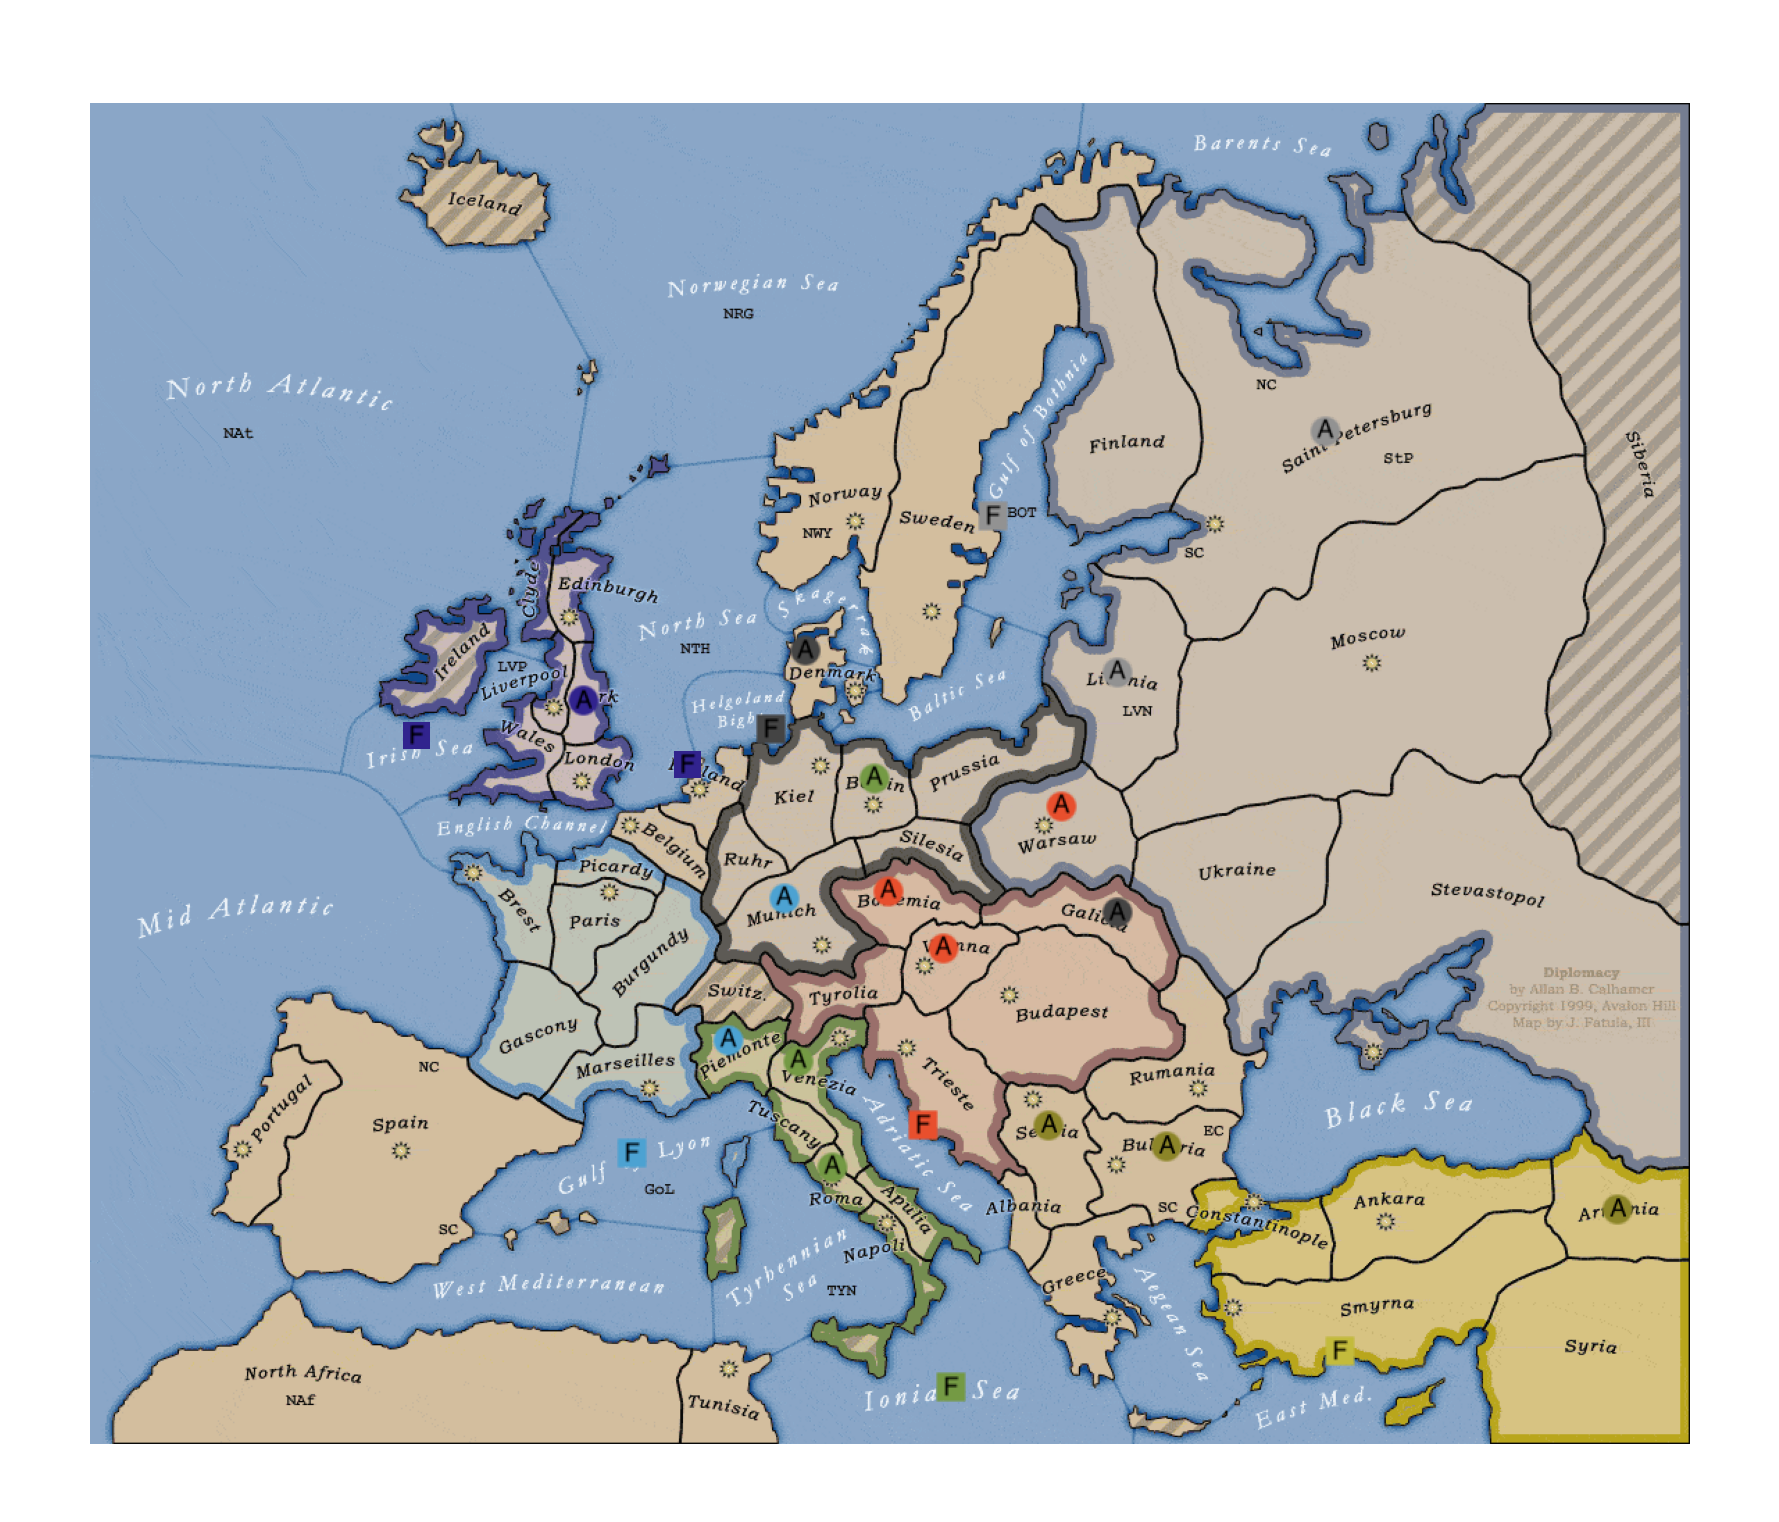

In [101]:
render_map()

In [30]:
units_df

location   type    owner                               unit_id
0          Marseiles   army   france  6ab472bd-bcfa-4687-aec4-1fed60c2b354
1              Brest  fleet   france  c17ef4de-1cb5-43ef-8263-d02aed051b16
2              Paris   army   france  a1be7be2-e17e-44b6-b622-3f12b6c76c05
3          Edinburgh  fleet  england  9c07004c-b2b1-45c8-b154-5c057f2f5a92
4          Liverpool   army  england  5fbbccae-0c53-4c3b-8dfd-d15dd53d2050
5             London  fleet  england  8568ce29-5b77-4ace-984a-1ed433d55d4a
6               Kiel  fleet  germany  b9782eb7-cfac-418d-be5a-e18714af3513
7             Berlin   army  germany  b8660620-9fdb-4c0f-8078-7a7f67ea60ad
8             Munich   army  germany  29e5b185-d357-40ff-b761-2cce4f674316
9             Venice   army    italy  0119e05a-c01b-4066-bfa2-f4c8ebffee69
10              Rome   army    italy  dcf0c1c0-ac00-4f2d-afdc-f3a85564bd4b
11            Naples  fleet    italy  f0d35d19-6323-43fb-b99a-bf6ce39f8a39
12            Vienna   army  austria  8c8c6404-5088-4754-b2c1-6a426a7debf3
13          Budapest   army  austria  c8199fbe-5305-42bd-8b6c-4f5cfbbbb418
14           Trieste  fleet  austria  91419daa-2812-45f2-84f1-8ffe0d570cbf
15    Constantinople   army   turkey  fdd73525-559a-440e-a02d-57e5db894d84
16            Ankara  fleet   turkey  f3732314-1ac8-4020-9b2c-b154f83a2165
17            Smyrna   army   turkey  57903b88-e603-4e60-b11e-c563fd00067c
18  St Petersburg_sc  fleet   russia  49163f34-0810-4d16-a066-30eb70dec866
19            Moscow   army   russia  cffdb156-dd5a-4cc3-97f3-c1ca8ddde096
20            Warsaw   army   russia  8f4965d1-f8ed-4305-8c33-0c203cb3f2cc
21        Sevastopol  fleet   russia  883475ee-fe62-4d15-aa0b-7a0c31d969b9

In [76]:
allies

{'france': ['france'],
 'italy': ['italy'],
 'england': ['england'],
 'russia': ['russia'],
 'germany': ['germany'],
 'austria': ['austria'],
 'turkey': ['turkey']}

In [82]:
allies[units_df.loc[units_df['location']=='Paris', 'owner'].values[0]]

['france']

In [ ]:
def make_group_moves_dict():
    unit_all_orders_dict = {}
    for unit in units_df['location'].tolist():
        allied_countries = allies[units_df.loc[units_df['location']=='Paris', 'owner'].values[0]]
        unit_all_orders_dict[unit] = {'orders': make_all_possible_orders(unit, allies = allied_countries)}
    #for testing, this part will come from model
    if unit in ['Picardy', 'Brest']:
        unit_all_orders_dict[unit]['target'] = 'Paris'
    elif unit in ['Tyrolia', 'Vienna', 'Galicia']:
        unit_all_orders_dict[unit]['target'] = 'Bohemia'
    elif unit in ['Budapest']:
        unit_all_orders_dict[unit]['target'] = 'Trieste'
    else:
        unit_all_orders_dict[unit]['target'] = None
    #end for testing
    sub_moves_dict = {}
    for d in set([v['target'] for v in unit_all_orders_dict.values()]):
        sub_moves_dict[d] = {k: {'orders':v['orders']} for k, v in unit_all_orders_dict.items() if v['target']==d}

In [68]:
def find_group_best_move(target, allies):
    for c, v in sub_moves_dict[target].items():
        adj_control = [units_df[units_df['location']==l]['owner'].values for l in territories_df[territories_df['country']==c]['connected_to'].values[0]]
        adj_control = [a[0] if len(a)>0 else None for a in adj_control]
        adj_count = Counter(adj_control)
        sub_moves_dict[target][c]['adj_count'] = adj_count
        sub_moves_dict[target][c]['adj_ratio'] = (len(adj_control)-(adj_count[None]+sum([adj_count[a] for a in allies])))/sum([adj_count[a] for a in allies])
        sub_moves_dict[target][c]['num_choices'] = len(v['orders'])
        sub_moves_dict[target][c]['num_cut_sup'] = units_df[(units_df['location'].isin(set(territories_df[territories_df['country']==c]['connected_to'].values[0])-set(territories_df[territories_df['country']==target]['connected_to'].values[0])))&(~units_df['owner'].isin(allies))].shape[0]
        #number of ways support can be cut by countries not adjacent to target
    top_choices = [k for k, v in sub_moves_dict[target].items() if v['adj_ratio']==min([vals['adj_ratio'] for vals in sub_moves_dict[target].values()])]
    top_choices = [k for k, v in sub_moves_dict[target].items() if v['num_cut_sup']==max([vals['num_cut_sup'] for vals in sub_moves_dict[target].values()])]
    for c in top_choices:
        inv_imp = 0
        sc, home_sc, sc_control = territories_df[territories_df['country']==c][['sc', 'start_control', 'sc_control']].iloc[0].tolist()
        current_occupy = units_df[units_df['location']==c]['owner'].values[0]
        if sc:
            inv_imp += 1
            if sc_control != current_occupy:
                inv_imp += 1
            elif home_sc != current_occupy and sub_moves_dict[target][c]['adj_ratio'] == 0:
                inv_imp += 1
        sub_moves_dict[target][c]['sc_calc'] = inv_imp
    top_choices = [c for c in top_choices if sub_moves_dict[target][c]['sc_calc'] == min([sub_moves_dict[target][c]['sc_calc'] for c in top_choices])]
    print(top_choices)
    if len(top_choices) > 1:
        top_choice = random.choice(top_choices)
    else:
        top_choice = top_choices[0]
    final_orders = {}
    for k, v in sub_moves_dict[target].items():
        if k == top_choice:
            order = (k, 'move', target)
        else:
            order = (k, 'support', (top_choice, target))
        if order not in v['orders']:
            valid_ends = [o[2] for o in v['orders'] if o[1] not in ['support', 'convoy']]
            ends_dist_target = {k:v for k, v in zip(valid_ends, [nx.shortest_path_length(G, l, 'Paris') for l in valid_ends])}
            closest_end = random.choice(list({k:v for k, v in ends_dist_target.items() if v == min(ends_dist_target.values())}.keys()))
            order = [o for o in v['orders'] if o[2] == closest_end][0]
        assert order in v['orders'], 'Selected order not in possible order list, please check. Selected order: {}'.format(order)
        final_orders[k] = order
    return final_orders

In [39]:
unit_all_orders_dict = {}
for unit in units_df['location'].tolist():
    allies = units_df[units_df['location']==unit]['owner'].tolist()
    unit_all_orders_dict[unit] = {'orders': make_all_possible_orders(unit, allies = allies)}
    if unit in ['Picardy', 'Brest']:
        unit_all_orders_dict[unit]['target'] = 'Paris'
    elif unit in ['Tyrolia', 'Vienna', 'Galicia']:
        unit_all_orders_dict[unit]['target'] = 'Bohemia'
    elif unit in ['Budapest']:
        unit_all_orders_dict[unit]['target'] = 'Trieste'
    else:
        unit_all_orders_dict[unit]['target'] = None

In [42]:
unit_all_orders_dict

{'Marseiles': {'orders': [('Marseiles', 'hold', 'Marseiles'),
   ('Marseiles', 'move', 'Burgundy'),
   ('Marseiles', 'support', ('Paris', 'Burgundy')),
   ('Marseiles', 'move', 'Gascony'),
   ('Marseiles', 'support', ('Brest', 'Gascony')),
   ('Marseiles', 'support', ('Paris', 'Gascony')),
   ('Marseiles', 'move', 'Spain'),
   ('Marseiles', 'move', 'Piedmont')],
  'target': None},
 'Brest': {'orders': [('Brest', 'hold', 'Brest'),
   ('Brest', 'move', 'English Channel'),
   ('Brest', 'move', 'Mid Atlantic Ocean'),
   ('Brest', 'move', 'Picardy'),
   ('Brest', 'support', ('Paris', 'Picardy')),
   ('Brest', 'move', 'Gascony'),
   ('Brest', 'support', ('Paris', 'Gascony')),
   ('Brest', 'support', ('Marseiles', 'Gascony'))],
  'target': 'Paris'},
 'Paris': {'orders': [('Paris', 'hold', 'Paris'),
   ('Paris', 'move', 'Picardy'),
   ('Paris', 'support', ('Brest', 'Picardy')),
   ('Paris', 'move', 'Brest'),
   ('Paris', 'support', ('Brest', 'Brest')),
   ('Paris', 'move', 'Gascony'),
   ('Par

In [40]:
sub_moves_dict = {}
for d in set([v['target'] for v in unit_all_orders_dict.values()]):
    sub_moves_dict[d] = {k: {'orders':v['orders']} for k, v in unit_all_orders_dict.items() if v['target']==d}

In [45]:
sub_moves_dict

{None: {'Marseiles': {'orders': [('Marseiles', 'hold', 'Marseiles'),
    ('Marseiles', 'move', 'Burgundy'),
    ('Marseiles', 'support', ('Paris', 'Burgundy')),
    ('Marseiles', 'move', 'Gascony'),
    ('Marseiles', 'support', ('Brest', 'Gascony')),
    ('Marseiles', 'support', ('Paris', 'Gascony')),
    ('Marseiles', 'move', 'Spain'),
    ('Marseiles', 'move', 'Piedmont')]},
  'Paris': {'orders': [('Paris', 'hold', 'Paris'),
    ('Paris', 'move', 'Picardy'),
    ('Paris', 'support', ('Brest', 'Picardy')),
    ('Paris', 'move', 'Brest'),
    ('Paris', 'support', ('Brest', 'Brest')),
    ('Paris', 'move', 'Gascony'),
    ('Paris', 'support', ('Brest', 'Gascony')),
    ('Paris', 'support', ('Marseiles', 'Gascony')),
    ('Paris', 'move', 'Burgundy'),
    ('Paris', 'support', ('Marseiles', 'Burgundy'))]},
  'Edinburgh': {'orders': [('Edinburgh', 'hold', 'Edinburgh'),
    ('Edinburgh', 'move', 'Norwegian Sea'),
    ('Edinburgh', 'move', 'North Sea'),
    ('Edinburgh', 'support', ('London'

In [69]:
find_group_best_move('Trieste', ['austria'])

['Budapest']
['Budapest']
['Budapest']


{'Budapest': ('Budapest', 'move', 'Trieste')}

In [73]:
find_group_best_move('Paris', ['france'])

{'orders': [('Brest', 'hold', 'Brest'), ('Brest', 'move', 'English Channel'), ('Brest', 'move', 'Mid Atlantic Ocean'), ('Brest', 'move', 'Picardy'), ('Brest', 'support', ('Paris', 'Picardy')), ('Brest', 'move', 'Gascony'), ('Brest', 'support', ('Paris', 'Gascony')), ('Brest', 'support', ('Marseiles', 'Gascony'))], 'adj_count': Counter({None: 4, 'france': 1}), 'adj_ratio': 0.0, 'num_choices': 8, 'num_cut_sup': 0, 'sc_calc': 1}
['Brest']
['Brest']
['Brest']


{'Brest': ('Brest', 'move', 'Gascony')}

In [ ]:
find_group_best_move('Bohemia', ['france'])

In [41]:
allies = ['france']
target = 'Paris'
for c, v in sub_moves_dict[target].items():
    adj_control = [units_df[units_df['location']==l]['owner'].values for l in territories_df[territories_df['country']==c]['connected_to'].values[0]]
    adj_control = [a[0] if len(a)>0 else None for a in adj_control]
    adj_count = Counter(adj_control)
    sub_moves_dict[target][c]['adj_count'] = adj_count
    sub_moves_dict[target][c]['adj_ratio'] = (len(adj_control)-(adj_count[None]+sum([adj_count[a] for a in allies])))/sum([adj_count[a] for a in allies])
    sub_moves_dict[target][c]['num_choices'] = len(v['orders'])
    sub_moves_dict[target][c]['num_cut_sup'] = units_df[(units_df['location'].isin(set(territories_df[territories_df['country']==c]['connected_to'].values[0])-set(territories_df[territories_df['country']==target]['connected_to'].values[0])))&(~units_df['owner'].isin(allies))].shape[0]

    #number of ways support can be cut by countries not adjacent to target
top_choices = [k for k, v in sub_moves_dict[target].items() if v['adj_ratio']==min([vals['adj_ratio'] for vals in sub_moves_dict[target].values()])]
top_choices = [k for k, v in sub_moves_dict[target].items() if v['num_cut_sup']==max([vals['num_cut_sup'] for vals in sub_moves_dict[target].values()])]
for c in top_choices:
    inv_imp = 0
    sc, home_sc, sc_control = territories_df[territories_df['country']==c][['sc', 'start_control', 'sc_control']].iloc[0].tolist()
    current_occupy = units_df[units_df['location']==c]['owner'].values[0]
    if sc:
        inv_imp += 1
        if sc_control != current_occupy:
            inv_imp += 1
        elif home_sc != current_occupy and sub_moves_dict[target][c]['adj_ratio'] == 0:
            inv_imp += 1
    sub_moves_dict[target][c]['sc_calc'] = inv_imp
top_choices = [c for c in top_choices if sub_moves_dict[target][c]['sc_calc'] == min([sub_moves_dict[target][c]['sc_calc'] for c in top_choices])]
if len(top_choices) > 1:
    top_choice = random.choice(top_choices)
else:
    top_choice = top_choices[0]
final_orders = {}
for k, v in sub_moves_dict[target].items():
    if k == top_choice:
        order = (k, 'move', target)
    else:
        order = (k, 'support', (top_choice, target))
    assert order in v['orders'], 'Selected order not in possible order list, please check. Selected order: {}'.format(order)
    final_orders[k] = order
print(final_orders)
allies = ['austria']
target = 'Bohemia'
for c, v in sub_moves_dict[target].items():
    adj_control = [units_df[units_df['location']==l]['owner'].values for l in territories_df[territories_df['country']==c]['connected_to'].values[0]]
    adj_control = [a[0] if len(a)>0 else None for a in adj_control]
    adj_count = Counter(adj_control)
    sub_moves_dict[target][c]['adj_count'] = adj_count
    sub_moves_dict[target][c]['adj_ratio'] = (len(adj_control)-(adj_count[None]+sum([adj_count[a] for a in allies])))/sum([adj_count[a] for a in allies])
    sub_moves_dict[target][c]['num_choices'] = len(v['orders'])
    sub_moves_dict[target][c]['num_cut_sup'] = units_df[(units_df['location'].isin(set(territories_df[territories_df['country']==c]['connected_to'].values[0])-set(territories_df[territories_df['country']==target]['connected_to'].values[0])))&(~units_df['owner'].isin(allies))].shape[0]
top_choices = [k for k, v in sub_moves_dict[target].items() if v['adj_ratio']==min([vals['adj_ratio'] for vals in sub_moves_dict[target].values()])]
top_choices = [k for k, v in sub_moves_dict[target].items() if v['num_cut_sup']==max([vals['num_cut_sup'] for vals in sub_moves_dict[target].values()])]
for c in top_choices:
    inv_imp = 0
    sc, home_sc, sc_control = territories_df[territories_df['country']==c][['sc', 'start_control', 'sc_control']].iloc[0].tolist()
    current_occupy = units_df[units_df['location']==c]['owner'].values[0]
    if sc:
        inv_imp += 1
        if sc_control != current_occupy:
            inv_imp += 1
        elif home_sc != current_occupy and sub_moves_dict[target][c]['adj_ratio'] == 0:
            inv_imp += 1
    sub_moves_dict[target][c]['sc_calc'] = inv_imp
top_choices = [c for c in top_choices if sub_moves_dict[target][c]['sc_calc'] == min([sub_moves_dict[target][c]['sc_calc'] for c in top_choices])]
if len(top_choices) > 1:
    top_choice = random.choice(top_choices)
else:
    top_choice = top_choices[0]
final_orders = {}
for k, v in sub_moves_dict[target].items():
    if k == top_choice:
        order = (k, 'move', target)
    else:
        order = (k, 'support', (top_choice, target))
    assert order in v['orders'], 'Selected order not in possible order list, please check. Selected order: {}'.format(order)
    final_orders[k] = order
print(final_orders)

AssertionError: Selected order not in possible order list, please check. Selected order: ('Brest', 'move', 'Paris')

In [226]:
top_choices = [k for k, v in sub_moves_dict['Paris'].items() if v['adj_ratio']==min([vals['adj_ratio'] for vals in sub_moves_dict['Paris'].values()])]
top_choices = [k for k, v in sub_moves_dict['Paris'].items() if v['num_cut_sup']==max([vals['num_cut_sup'] for vals in sub_moves_dict['Paris'].values()])]

In [216]:
for c in top_choices:
    inv_imp = 0
    sc, home_sc, sc_control = territories_df[territories_df['country']==c][['sc', 'start_control', 'sc_control']].iloc[0].tolist()
    current_occupy = units_df[units_df['location']==c]['owner'].values[0]
    if sc:
        inv_imp += 1
        if sc_control != current_occupy:
            inv_imp += 1
        elif home_sc != current_occupy and sub_moves_dict['Paris'][c]['adj_ratio'] == 0:
            inv_imp += 1
    sub_moves_dict['Paris'][c]['sc_calc'] = inv_imp


In [217]:
top_choices = [c for c in top_choices if sub_moves_dict['Paris'][c]['sc_calc'] == min([sub_moves_dict['Paris'][c]['sc_calc'] for c in top_choices])]

In [218]:
if len(top_choices) > 1:
    top_choice = random.choice(top_choices)
else:
    top_choice = top_choices[0]

In [219]:
final_orders = {}
for k, v in sub_moves_dict['Paris'].items():
    if k == top_choice:
        order = (k, 'move', 'Paris')
    else:
        order = (k, 'support', (top_choice, 'Paris'))
    assert order in v['orders'], 'Selected order not in possible order list, please check. Selected order: {}'.format(order)
    final_orders[k] = order

In [220]:
final_orders

{'Picardy': ('Picardy', 'move', 'Paris'),
 'Brest': ('Brest', 'support', ('Picardy', 'Paris'))}

determine minimum amount of force to capture/defend territory, assign best suited units to meet that, if remaining units have them defend vacated supply centers (that becomes new target territory), if none then backfill. ideally this won't happen and dependent moves will still have different target territories specifically suited to bolster other moves
^^ support can be cut and calculating possiblity of cutting support will be hard and shouldn't be an issue when model trained so just assign everyone to support that can

will need to rework rewards for moves, since a move could be "successful" in the sense that a unit executed an order that was towards the target territory but left the country in a worse spot. The model should be penalized if an action in a worse outcome for the country. Additionally, moves should not be penalized if they did not occur as intended, since that may be a successful defense. Will likely need to overhaul reward system, but still keep sharing reward based on distance, since that should help reinforce cooperation of units

two parts of awarding rewards: Was the goal achieved and what was the cost. for the first, if didn't control territory do you now control it or are you closer to it. If you did control it, do you still control it. for the second, how much ground did you lose, ie, how many territories did you lose control of/gain control of (other than target territory) and are opponents closer to your supply centers (greater importance for home supply centers). These rewards should be evaluated on a per unit basis since that is how the predictions will be run.

what to do if target territory is impossible for unit to get to. for example a land unit trying to get to a sea territory, a sea unit trying to get to a land-locked territory, a territory in england trying to get to any mainland territory. If truly impossible, don't allow that as choice. Currently can't think of anything like that. If not possible for the unit, see if can facilitate others getting there (convoying unit, land unit moving so sea unit can move into territory and then into another sea territory). If technically possible but not currently possible (convoying unit, land unit moving so sea unit can move into territory and then into another sea territory), see if can retask other units to help (assuming they aren't already, if both sea and land units have the same territory as target, should select moves that coordinate capture of territory even if unit can't directly do it). In the scenario where there is no other units cooperating, check prob of necessary units for your target and if close enough to top prob retask to facilitate the move. If that happens, don't award rewards for retasked unit since not using the model outputs.

considerations for target territory:
- maintain occupancy
- move into territory
- prevent others from occupying
^^ honestly this is all moot for now, the model will only indicate which territory is most important, decisions on the moves will just be rules based with the intention of capturing or keeping the territory. Future models may incorporate this

if choice between moving or supporting another unit to move, first decide who is best to move (ratio of unallied units and allied units that can move into origin territory and how many other options do the units have, value losing ground over doing other things) then decide if support is necessary (number of unallied units that can move into destination territory). Also consider need to move, on top of home supply center and may have build coming up. 

if choice between move or convoy, would already have a target selected so would be decision between getting army in destination or moving yourself, first decide who is best to move (ratio of unallied units and allied units that can move into origin territory and how many other options do the units have, value losing ground over doing other things) 

if choice between move, support, and convoy first decide who is best to move (ratio of unallied units and allied units that can move into origin territory and how many other options do the units have, value losing ground over doing other things)

if deciding between two high prob (tied for top, for example, maybe implement thresholding later)...

if high prob far away and slightly lower prob close by how decide what to choose? Ths will be covered by exploitation/exploration balance. Get probs out of model, use similar logic to pick a territory to go after, then with that choose move that best fulfills that choice

If target is far away choose move that is along path with shortest distance. Alternative s to choose move that goes to territory with highest connections for maximum future flexibility 

Need to consider all moves "simultaneously", this means that prediction is at the country level, not the unit level (this will probably be a pretty big change in predicting moves). Actually more nuanced than that since at some point there will be multiple "fronts" so choices are more local than global. Predict territory for each unit, then group units with same target together and resolve related orders simultaneously. Prediction stays at unit level. also implement methodology to determine most likely choice of all enemy units adjacent to grouped units and target territory, use that to help determine best move. for now would use simple logic.

Can also implement a similar logic to builds of what is the most valuable territory. List all possible builds and then select builds most advantageous to the top value territory

Will need to implement logic for deciding who to ally with. This may be complicated since will need to also add logic for when to stab someone

In [ ]:
dest_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[3, 81]),
    tf.keras.layers.Dense(600, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(81, activation="softmax")
])

In [ ]:
def test_policy(possible_orders_list, unit, owner, model, units_df):
    active_unit_array, combined_array, unit_type_array = make_model_input_arrays(owner, units_df, move=True, unit=unit)
    with tf.GradientTape() as tape:
        try:
            out_probs = model(np.array([active_unit_array, combined_array, unit_type_array])[np.newaxis])
        except ValueError as e:
            print(active_unit_array)
            print(combined_array)
            print(np.array([active_unit_array, combined_array, unit_type_array])[np.newaxis])
            print(np.array([active_unit_array, combined_array, unit_type_array])[np.newaxis].shape)
            raise e
        total_prob = 0
        rand_prob = tf.random.uniform([1, 1])-.0001#make sure not exactly 1
        for i in range(tf_out_probs.shape[1]-1, -1, -1):
            tf_out_probs = tf.tensor_scatter_nd_update(tf_out_probs, tf.constant([[0, i]]), tf.math.reduce_sum(tf_out_probs[0, :i+1])[np.newaxis])
        lower_tensor = tf.math.greater(tf_out_probs[0,1:], rand_prob)
        upper_tensor = tf.math.less(tf_out_probs[0,:-1], rand_prob)
        in_range = tf.logical_and(lower_tensor, upper_tensor)
        try:
            action = tf.constant(tf.where(in_range).numpy()[0, 1]+1, dtype=tf.float32)
        except IndexError:
            action = tf.constant(0, dtype=tf.float32)
        y_target = tf.constant(tf.cast([action == np.array(list(range(0, len(out_probs[0]))))], tf.float32)) #[0, 1, 2, 3]
        loss = tf.reduce_mean(loss_fn(y_target, out_probs))
    grads = tape.gradient(loss, model.trainable_variables)
    order = order_list[int(action.numpy())]
    possible_orders_list = [o for o in possible_orders_list if o[1] == order]
    if len(possible_orders_list) > 0:
        return random.choice(possible_orders_list), out_probs, grads
    else:
        print('LOOK HERE')
        print(order)
        print(prop_move_type)
        print(available_move_types)
        print(order_list)
        print(tf_out_probs)
        print(rand_prob)
        print(new_prob)
        return (unit, 'disband', unit), out_probs, grads

In [67]:
territories_df[(territories_df['sc'])&(~territories_df['coast'])]['sc_control'].value_counts()

turkey     7
france     6
russia     5
england    4
italy      4
germany    3
austria    3
neutral    2
Name: sc_control, dtype: int64

In [170]:
total_rewards_grads[-1]['d3bacfe8-673d-4266-b58f-935e460803f2']['reward']

-1.8083333333333336

In [162]:
units_df.sort_values('location')

location   type    owner  \
20           Adriatic Sea  fleet   russia   
3                 Armenia  fleet   turkey   
13                Bohemia   army  germany   
11               Bulgaria   army  germany   
22               Burgundy   army  germany   
23                Denmark  fleet  england   
21                Galicia   army  germany   
0                 Gascony   army   france   
6                  Greece   army  austria   
1                    Kiel   army  germany   
15                 London   army  england   
5               Marseiles   army    italy   
26   North Atlantic Ocean  fleet   france   
27              North Sea  fleet  germany   
8                  Norway  fleet  germany   
9                   Paris   army   france   
16               Piedmont   army    italy   
14               Portugal  fleet  england   
25                   Rome   army    italy   
19                   Ruhr   army  germany   
24                Rumania   army  austria   
4              Sevastopol   army  austria   
12                Silesia   army  germany   
2                  Smyrna   army   turkey   
7           St Petersburg   army  germany   
17                  Syria   army   turkey   
18                Trieste   army  germany   
10                Tyrolia   army  austria   
28  Western Mediterranean  fleet  austria   

                                 unit_id  
20  37382e0e-e465-400d-853d-7d2b8688b7b5  
3   32e09575-2e92-438a-844a-65bc36890d22  
13  f0d35062-8c49-4db8-afb2-1fa7a011468c  
11  34748b4d-7e34-496a-af39-30263f544d15  
22  5bb4adfc-f97d-48cf-b88e-e96a56f26220  
23  10b3de94-0e9b-4e5c-b885-0872486f214f  
21  4f5ead25-1f10-43f1-b1ba-902520bcd174  
0   88139a44-c639-4f91-bde5-a8655e68f976  
6   e7b408a3-ec5a-4023-9410-72ea332cbd9a  
1   9c841012-6f57-4c6b-966a-f5ecc3111de8  
15  49242844-9723-455a-a3e3-1b46c1212008  
5   4ba4dba8-e226-49b1-824c-3dc2cc988a22  
26  842009f6-e9eb-411f-8232-3890a1d12750  
27  f85ce0c2-802e-43c5-b1d3-c9852cc0394d  
8   f3053328-0399-4b28-8f35-448e5e269945  
9   2e255525-c1b7-4164-be4f-1b3aa1bc2d10  
16  0d9def2d-c026-4de9-bd28-5e04acf71732  
14  171301ea-c8f7-4345-8448-85fb30b4660d  
25  ac31cc7b-92f6-47a5-b244-ae0a96f9b575  
19  19420efa-28d5-4f2f-b8c4-91dbb6c22729  
24  d2dffb6f-66fd-4680-87c9-a706640b110b  
4   dae44dfb-3b99-4874-8ae4-d21bca5499dd  
12  549e9152-b22f-44bb-9eea-88263dbcc7cd  
2   e4ccbf79-b1ec-406d-ad7f-c97f51ac230d  
7   c125eb8c-20a3-4fd2-8f99-a6a55ae0527a  
17  88e6094f-9c4c-4c9c-973f-9396a37df4e7  
18  364012f4-f004-4556-93d1-cb5a37f264d9  
10  d62e1dd9-8259-4e82-bf10-cfd37a58ab23  
28  49c69a79-663a-44a3-a197-aae23baf2a2f

In [311]:
resolved_orders.sort_values('end')

start    order                    end  \
5            Adriatic Sea     hold           Adriatic Sea   
9                  Ankara     hold                 Ankara   
24                   Rome     move                 Apulia   
32                Armenia     hold                Armenia   
13                Belgium     hold                Belgium   
11                 Berlin     hold                 Berlin   
3               Black Sea     hold              Black Sea   
0                 Bohemia     hold                Bohemia   
18                  Brest     hold                  Brest   
23                Gascony     move               Burgundy   
27                 Vienna     move                Galicia   
15                Galicia  retreat                Galicia   
21               Bulgaria     move                 Greece   
14                   Kiel     hold                   Kiel   
16                Livonia     hold                Livonia   
33                 Moscow     hold                 Moscow   
28                 Munich     hold                 Munich   
17           North Africa     hold           North Africa   
30          Norwegian Sea     move                 Norway   
26                Silesia     move                Prussia   
10                Prussia  retreat                Prussia   
1              Sevastopol     hold             Sevastopol   
22                 Smyrna     hold                 Smyrna   
7                   Spain     hold                  Spain   
20                Finland     move          St Petersburg   
31             Skagerrack     move                 Sweden   
8                   Syria     hold                  Syria   
2                 Trieste     hold                Trieste   
29         Tyrrhenian Sea     move                  Tunis   
12                Tuscany     hold                Tuscany   
4                 Tyrolia     hold                Tyrolia   
6                 Ukraine     hold                Ukraine   
25               Piedmont     move                 Venice   
19  Western Mediterranean     hold  Western Mediterranean   

                                    support convoy   type    owner  \
5                         (Tyrolia, Venice)   None  fleet  austria   
9                           (Syria, Smyrna)   None   army   turkey   
24                                     None   None   army  germany   
32                                     None   None   army   turkey   
13                      (Gascony, Burgundy)   None   army  germany   
11                       (Silesia, Silesia)   None   army  germany   
3                        (Armenia, Armenia)   None  fleet   turkey   
0                         (Galicia, Vienna)   None   army  germany   
18                         (Spain, Gascony)   None  fleet   france   
23                                     None   None   army   france   
27                                     None   None   army  austria   
15                                     None   None   army  germany   
21                                     None   None   army   turkey   
14                         (Munich, Berlin)   None  fleet  germany   
16                       (Silesia, Prussia)   None   army  germany   
33                                     None   None   army  germany   
28                                     None   None   army  germany   
17  (Tyrrhenian Sea, Western Mediterranean)   None  fleet   france   
30                                     None   None  fleet   france   
26                                     None   None   army  austria   
10                                     None   None   army  germany   
1                      (Black Sea, Rumania)   None   army  austria   
22                                     None   None   army   turkey   
7                      (Gascony, Marseiles)   None   army   france   
20                                     None   None   army   turkey   
31                                     None   None  fleet   fran

In [72]:
original_orders.sort_values('end')

start order             end support convoy   type    owner  \
28     Aegean Sea  hold      Aegean Sea    None   None  fleet   turkey   
24        Albania  hold         Albania    None   None   army  austria   
4            Rome  move          Apulia    None   None   army    italy   
10        Armenia  hold         Armenia    None   None   army   russia   
12        Prussia  move      Baltic Sea    None   None  fleet   russia   
20         Berlin  move      Baltic Sea    None   None  fleet  germany   
23       Budapest  hold        Budapest    None   None   army  austria   
11         Smyrna  move  Constantinople    None   None  fleet   russia   
1       Edinburgh  hold       Edinburgh    None   None  fleet   france   
16        Gascony  hold         Gascony    None   None   army  germany   
26     Ionian Sea  hold      Ionian Sea    None   None  fleet  austria   
7       Liverpool  hold       Liverpool    None   None   army  england   
13  St Petersburg  move         Livonia    None   None   army   russia   
18         Munich  hold          Munich    None   None   army  germany   
19           Kiel  move          Munich    None   None   army  germany   
3          Naples  hold          Naples    None   None  fleet    italy   
5         Belgium  move       North Sea    None   None  fleet  england   
14         Sweden  move          Norway    None   None  fleet  germany   
6   Norwegian Sea  hold   Norwegian Sea    None   None  fleet  england   
0         Picardy  hold         Picardy    None   None   army   france   
15           Ruhr  hold            Ruhr    None   None   army  germany   
27         Serbia  move         Rumania    None   None   army  austria   
9         Silesia  hold         Silesia    None   None   army   russia   
17      Marseiles  move           Spain    None   None   army  germany   
21        Finland  move          Sweden    None   None   army  germany   
25        Trieste  move         Tyrolia    None   None   army  austria   
2          Venice  hold          Venice    None   None   army    italy   
22        Galicia  move          Warsaw    None   None   army  austria   
8          Warsaw  hold          Warsaw    None   None   army   russia   

                                 unit_id  
28  e340313b-7e2b-4265-a8fb-c4459accc8f8  
24  a25314af-5965-47fd-8b41-ede566dd3409  
4   8db15ec2-d1d5-4dd1-9b57-cfca2a77f4eb  
10  96d05d5d-e09d-46cf-ae15-84d53fc13161  
12  63fa960e-1846-4bad-985d-8490276d6691  
20  3240d12c-baa9-4755-ab87-f6a52547d737  
23  1f95fb72-1e17-44b3-9f9d-141380b7c94c  
11  5b2c6b96-6d92-49c5-9c86-cf0e24a177d0  
1   0e0538a4-7d34-494e-ae88-09f13d6f055e  
16  da466ae1-a60b-4ecf-a047-3f51b1739f93  
26  c825bd51-9f35-4840-b96c-56e9c8d69544  
7   c0331ed2-800a-42ac-a63b-cb1087d0bd22  
13  010bd973-fb43-4adb-b2d1-8ea9f0f968ea  
18  d5bde5ab-499c-46a9-8e9a-bf53366a8fef  
19  a769d548-0dee-454f-bb19-8b612b995253  
3   44ae79f4-d726-49cd-aad4-03e99ed1cb5c  
5   70cf09f5-0df7-4d95-b4fb-1a38f6013adf  
14  e4bbb4c6-025c-4f84-9aee-373fde33cfac  
6   12dcc4e6-a27d-46ed-825c-4f2cbcfb00b8  
0   b4b34af0-4c0f-4d1f-a1c8-04d81f2e1ad4  
15  e8495df6-a211-4659-b2b0-688b35aab685  
27  6ff67286-3f13-42bc-82e6-45ebf3995f73  
9   ea51d566-c3ed-4f42-9554-302c762d5e14  
17  8de90c92-1994-4f05-84b2-a4474a27e574  
21  d94e101e-f7e5-4ec3-8d0a-0ff485ed8be9  
25  f39583f8-31a8-4c6d-9142-25f3e71cf1d0  
2   2796f454-fb9b-47a1-ac44-5288c73c3e8c  
22  99a42a13-5b96-443f-90a5-45065e4c7483  
8   6e8f6e3e-fc8f-4b88-aa5f-9d5d4270ad89

In [301]:
units_df = original_orders[['start', 'type', 'owner', 'unit_id']]
units_df.columns = ['location', 'type', 'owner', 'unit_id']

In [302]:
orders = []
for ind, row in original_orders.iterrows():
    if row['support'] is not None:
        orders.append((row['start'], row['order'], row['support']))
    elif row['convoy'] is not None:
        orders.append((row['start'], row['order'], row['convoy']))
    else:
        orders.append((row['start'], row['order'], row['end']))

In [303]:
orders

[('Gascony', 'move', 'Burgundy'),
 ('Spain', 'support', ('Gascony', 'Marseiles')),
 ('Western Mediterranean', 'support', ('Tyrrhenian Sea', 'Gulf of Lyon')),
 ('Skagerrack', 'move', 'Sweden'),
 ('Brest', 'support', ('Spain', 'Gascony')),
 ('Norwegian Sea', 'move', 'Norway'),
 ('Tyrrhenian Sea', 'move', 'Tunis'),
 ('North Africa', 'support', ('Tyrrhenian Sea', 'Western Mediterranean')),
 ('Livonia', 'support', ('Silesia', 'Prussia')),
 ('Galicia', 'support', ('Bohemia', 'Bohemia')),
 ('Kiel', 'support', ('Munich', 'Berlin')),
 ('Belgium', 'support', ('Gascony', 'Burgundy')),
 ('Bohemia', 'support', ('Galicia', 'Vienna')),
 ('Berlin', 'support', ('Silesia', 'Silesia')),
 ('Prussia', 'support', ('Berlin', 'Berlin')),
 ('Munich', 'move', 'Tyrolia'),
 ('Moscow', 'hold', 'Moscow'),
 ('Rome', 'move', 'Apulia'),
 ('Vienna', 'move', 'Galicia'),
 ('Adriatic Sea', 'support', ('Tyrolia', 'Venice')),
 ('Tyrolia', 'support', ('Piedmont', 'Piedmont')),
 ('Silesia', 'move', 'Prussia'),
 ('Trieste', 's

In [304]:
territories_df = old_territories_df

In [305]:
season

'fall'

In [338]:
output = play_one_round(test_naive_policy, units_df, territories_df, o = orders, retreat = False, season = season, human = False, model = None)
    

      start    order      end             support convoy  type    owner  \
10  Prussia  retreat  Prussia    (Berlin, Berlin)   None  army  germany   
15  Galicia  retreat  Galicia  (Bohemia, Bohemia)   None  army  germany   

                                 unit_id  count success  dislodged  
10  d5077eea-22af-4ebf-93f6-c50385d6ef10    0.0   False       True  
15  33797442-6444-4319-86fc-868e0171f621    0.0   False       True  
[('Galicia', 'move', 'Budapest'), ('Prussia', 'move', 'Warsaw')]
[('Galicia', 'move', 'Budapest'), ('Prussia', 'move', 'Warsaw')]
     start order       end support convoy  type    owner  \
0  Galicia  move  Budapest    None   None  army  germany   
1  Prussia  move    Warsaw    None   None  army  germany   

                                unit_id  count success  dislodged  
0  33797442-6444-4319-86fc-868e0171f621    0.0    True      False  
1  d5077eea-22af-4ebf-93f6-c50385d6ef10    0.0    True      False  
                    start    order                  

In [339]:
test_units_df, test_resolved_orders, test_original_orders, test_season, test_old_territories_df, test_territories_df = output

In [340]:
test_original_orders

start    order                    end  \
0                 Gascony     move               Burgundy   
1                   Spain  support                  Spain   
2   Western Mediterranean  support  Western Mediterranean   
3              Skagerrack     move                 Sweden   
4                   Brest  support                  Brest   
5           Norwegian Sea     move                 Norway   
6          Tyrrhenian Sea     move                  Tunis   
7            North Africa  support           North Africa   
8                 Livonia  support                Livonia   
9                 Galicia  support                Galicia   
10                   Kiel  support                   Kiel   
11                Belgium  support                Belgium   
12                Bohemia  support                Bohemia   
13                 Berlin  support                 Berlin   
14                Prussia  support                Prussia   
15                 Munich     move                Tyrolia   
16                 Moscow     hold                 Moscow   
17                   Rome     move                 Apulia   
18                 Vienna     move                Galicia   
19           Adriatic Sea  support           Adriatic Sea   
20                Tyrolia  support                Tyrolia   
21                Silesia     move                Prussia   
22                Trieste  support                Trieste   
23               Piedmont     move                 Venice   
24             Sevastopol  support             Sevastopol   
25                Tuscany  support                Tuscany   
26              Black Sea  support              Black Sea   
27                Ukraine  support                Ukraine   
28                  Syria  support                  Syria   
29                 Ankara  support                 Ankara   
30                Finland     move          St Petersburg   
31               Bulgaria     move                 Greece   
32                 Smyrna     move                  Syria   
33                Armenia     move                 Ankara   

                                    support convoy   type    owner  \
0                                      None   None   army   france   
1                      (Gascony, Marseiles)   None   army   france   
2            (Tyrrhenian Sea, Gulf of Lyon)   None  fleet   france   
3                                      None   None  fleet   france   
4                          (Spain, Gascony)   None  fleet   france   
5                                      None   None  fleet   france   
6                                      None   None  fleet   france   
7   (Tyrrhenian Sea, Western Mediterranean)   None  fleet   france   
8                        (Silesia, Prussia)   None   army  germany   
9                        (Bohemia, Bohemia)   None   army  germany   
10                         (Munich, Berlin)   None  fleet  germany   
11                      (Gascony, Burgundy)   None   army  germany   
12                        (Galicia, Vienna)   None   army  germany   
13                       (Silesia, Silesia)   None   army  germany   
14                         (Berlin, Berlin)   None   army  germany   
15                                     None   None   army  germany   
16                                     None   None   army  germany   
17                                     None   None   army  germany   
18                                     None   None   army  austria   
19                        (Tyrolia, Venice)   None  fleet  austria   
20                     (Piedmont, Piedmont)   None   army  austria   
21                                     None   None   army  austria   
22                      (Galicia, Budapest)   None   army  austria   
23                                     None   None   army  austria   
24                     (Black Sea, Rumania)   None   army  austria   
25                      (Tyrolia, Piedmont)   None   army  austr

In [341]:
test_units_df.sort_values('location')

location   type    owner  \
5            Adriatic Sea  fleet  austria   
9                  Ankara   army   turkey   
24                 Apulia   army  germany   
32                Armenia   army   turkey   
13                Belgium   army  germany   
11                 Berlin   army  germany   
3               Black Sea  fleet   turkey   
0                 Bohemia   army  germany   
18                  Brest  fleet   france   
15               Budapest   army  germany   
23               Burgundy   army   france   
27                Galicia   army  austria   
21                 Greece   army   turkey   
14                   Kiel  fleet  germany   
16                Livonia   army  germany   
33                 Moscow   army  germany   
28                 Munich   army  germany   
17           North Africa  fleet   france   
30                 Norway  fleet   france   
26                Prussia   army  austria   
1              Sevastopol   army  austria   
22                 Smyrna   army   turkey   
7                   Spain   army   france   
20          St Petersburg   army   turkey   
31                 Sweden  fleet   france   
8                   Syria   army   turkey   
2                 Trieste   army  austria   
29                  Tunis  fleet   france   
12                Tuscany   army  austria   
4                 Tyrolia   army  austria   
6                 Ukraine   army   turkey   
25                 Venice   army  austria   
10                 Warsaw   army  germany   
19  Western Mediterranean  fleet   france   

                                 unit_id  
5   65ff3f59-66f9-4890-95e9-aec9718aad1f  
9   76ecefc4-a595-4009-9493-2a2f3f00c768  
24  d906c9b6-f3f5-4d50-bfe9-5fe1a69e8aa6  
32  140ed3af-e30a-4f8f-a645-c36ae4f2f340  
13  1a845492-3f58-4b29-9722-7c63f518cbee  
11  6a9dff4f-9e60-4d9c-bdf4-25e184591cd2  
3   828f8805-e463-4c81-b5ba-8588ad8fea4a  
0   17e542f7-1c5b-43c8-8b1f-3a1c01498e24  
18  84051e10-e47a-468a-9386-11124c60a7e4  
15  33797442-6444-4319-86fc-868e0171f621  
23  f3744a90-934b-460b-8854-ba9f163c3f14  
27  2fb4c3fe-5c99-4f27-9946-1f9430a5594c  
21  e061ca11-d321-403c-971c-102224c702d7  
14  3be97b00-cb0a-4358-8a2f-da818f18bbf5  
16  9a287934-5c0a-4d9b-8651-577fd5f66e73  
33  a0177803-ceef-4795-9d71-c7611dd3aa5a  
28  2188fcdb-c577-4afd-8a74-be3f065035ec  
17  51813a3c-264e-40e3-99cb-7459f82b1fb5  
30  4ac84378-681e-4fb0-87a4-cc3bfe472916  
26  ec04bc35-dca7-483d-b147-6264361b84cb  
1   818b0b33-2548-4299-8409-198da5dd8867  
22  e21bed71-fadd-4ae3-b7d7-4c573c0ad6eb  
7   4928d85b-d350-4b88-adb4-50ae1db8cbbd  
20  242b1763-f751-4bd7-9343-781dd50a15be  
31  a11b434b-3630-4abd-942e-54296fc6515a  
8   163fc752-38d9-4413-92a7-37f976c025ae  
2   be42b6fc-a74e-42e3-a15e-1d4dd768428d  
29  4f122a48-97ee-47ce-a938-b1cea02be770  
12  91c87998-9814-4db9-b44c-c5742a08b502  
4   08a1bf84-4df6-4bc7-9f9a-d46bc12bb977  
6   c1b914b1-a7a2-4325-98f2-a59465aad3a3  
25  9c01c254-5c7e-4d12-9b11-76383bc9dca3  
10  d5077eea-22af-4ebf-93f6-c50385d6ef10  
19  ec3889d6-e7f7-40be-9e54-6ef66f49b851

In [342]:
test_resolved_orders.sort_values('end')

start    order                    end  \
5            Adriatic Sea     hold           Adriatic Sea   
9                  Ankara     hold                 Ankara   
24                   Rome     move                 Apulia   
32                Armenia     hold                Armenia   
13                Belgium     hold                Belgium   
11                 Berlin     hold                 Berlin   
3               Black Sea     hold              Black Sea   
0                 Bohemia     hold                Bohemia   
18                  Brest     hold                  Brest   
15                Galicia  retreat               Budapest   
23                Gascony     move               Burgundy   
27                 Vienna     move                Galicia   
21               Bulgaria     move                 Greece   
14                   Kiel     hold                   Kiel   
16                Livonia     hold                Livonia   
33                 Moscow     hold                 Moscow   
28                 Munich     hold                 Munich   
17           North Africa     hold           North Africa   
30          Norwegian Sea     move                 Norway   
26                Silesia     move                Prussia   
1              Sevastopol     hold             Sevastopol   
22                 Smyrna     hold                 Smyrna   
7                   Spain     hold                  Spain   
20                Finland     move          St Petersburg   
31             Skagerrack     move                 Sweden   
8                   Syria     hold                  Syria   
2                 Trieste     hold                Trieste   
29         Tyrrhenian Sea     move                  Tunis   
12                Tuscany     hold                Tuscany   
4                 Tyrolia     hold                Tyrolia   
6                 Ukraine     hold                Ukraine   
25               Piedmont     move                 Venice   
10                Prussia  retreat                 Warsaw   
19  Western Mediterranean     hold  Western Mediterranean   

                                    support convoy   type    owner  \
5                         (Tyrolia, Venice)   None  fleet  austria   
9                           (Syria, Smyrna)   None   army   turkey   
24                                     None   None   army  germany   
32                                     None   None   army   turkey   
13                      (Gascony, Burgundy)   None   army  germany   
11                       (Silesia, Silesia)   None   army  germany   
3                        (Armenia, Armenia)   None  fleet   turkey   
0                         (Galicia, Vienna)   None   army  germany   
18                         (Spain, Gascony)   None  fleet   france   
15                                     None   None   army  germany   
23                                     None   None   army   france   
27                                     None   None   army  austria   
21                                     None   None   army   turkey   
14                         (Munich, Berlin)   None  fleet  germany   
16                       (Silesia, Prussia)   None   army  germany   
33                                     None   None   army  germany   
28                                     None   None   army  germany   
17  (Tyrrhenian Sea, Western Mediterranean)   None  fleet   france   
30                                     None   None  fleet   france   
26                                     None   None   army  austria   
1                      (Black Sea, Rumania)   None   army  austria   
22                                     None   None   army   turkey   
7                      (Gascony, Marseiles)   None   army   france   
20                                     None   None   army   turkey   
31                                     None   None  fleet   france   
8                         (Ankara, Armenia)   None   army   turk

In [300]:
original_orders

start    order                    end  \
0                 Gascony     move               Burgundy   
1                   Spain  support                  Spain   
2   Western Mediterranean  support  Western Mediterranean   
3              Skagerrack     move                 Sweden   
4                   Brest  support                  Brest   
5           Norwegian Sea     move                 Norway   
6          Tyrrhenian Sea     move                  Tunis   
7            North Africa  support           North Africa   
8                 Livonia  support                Livonia   
9                 Galicia  support                Galicia   
10                   Kiel  support                   Kiel   
11                Belgium  support                Belgium   
12                Bohemia  support                Bohemia   
13                 Berlin  support                 Berlin   
14                Prussia  support                Prussia   
15                 Munich     move                Tyrolia   
16                 Moscow     hold                 Moscow   
17                   Rome     move                 Apulia   
18                 Vienna     move                Galicia   
19           Adriatic Sea  support           Adriatic Sea   
20                Tyrolia  support                Tyrolia   
21                Silesia     move                Prussia   
22                Trieste  support                Trieste   
23               Piedmont     move                 Venice   
24             Sevastopol  support             Sevastopol   
25                Tuscany  support                Tuscany   
26              Black Sea  support              Black Sea   
27                Ukraine  support                Ukraine   
28                  Syria  support                  Syria   
29                 Ankara  support                 Ankara   
30                Finland     move          St Petersburg   
31               Bulgaria     move                 Greece   
32                 Smyrna     move                  Syria   
33                Armenia     move                 Ankara   

                                    support convoy   type    owner  \
0                                      None   None   army   france   
1                      (Gascony, Marseiles)   None   army   france   
2            (Tyrrhenian Sea, Gulf of Lyon)   None  fleet   france   
3                                      None   None  fleet   france   
4                          (Spain, Gascony)   None  fleet   france   
5                                      None   None  fleet   france   
6                                      None   None  fleet   france   
7   (Tyrrhenian Sea, Western Mediterranean)   None  fleet   france   
8                        (Silesia, Prussia)   None   army  germany   
9                        (Bohemia, Bohemia)   None   army  germany   
10                         (Munich, Berlin)   None  fleet  germany   
11                      (Gascony, Burgundy)   None   army  germany   
12                        (Galicia, Vienna)   None   army  germany   
13                       (Silesia, Silesia)   None   army  germany   
14                         (Berlin, Berlin)   None   army  germany   
15                                     None   None   army  germany   
16                                     None   None   army  germany   
17                                     None   None   army  germany   
18                                     None   None   army  austria   
19                        (Tyrolia, Venice)   None  fleet  austria   
20                     (Piedmont, Piedmont)   None   army  austria   
21                                     None   None   army  austria   
22                      (Galicia, Budapest)   None   army  austria   
23                                     None   None   army  austria   
24                     (Black Sea, Rumania)   None   army  austria   
25                      (Tyrolia, Piedmont)   None   army  austr

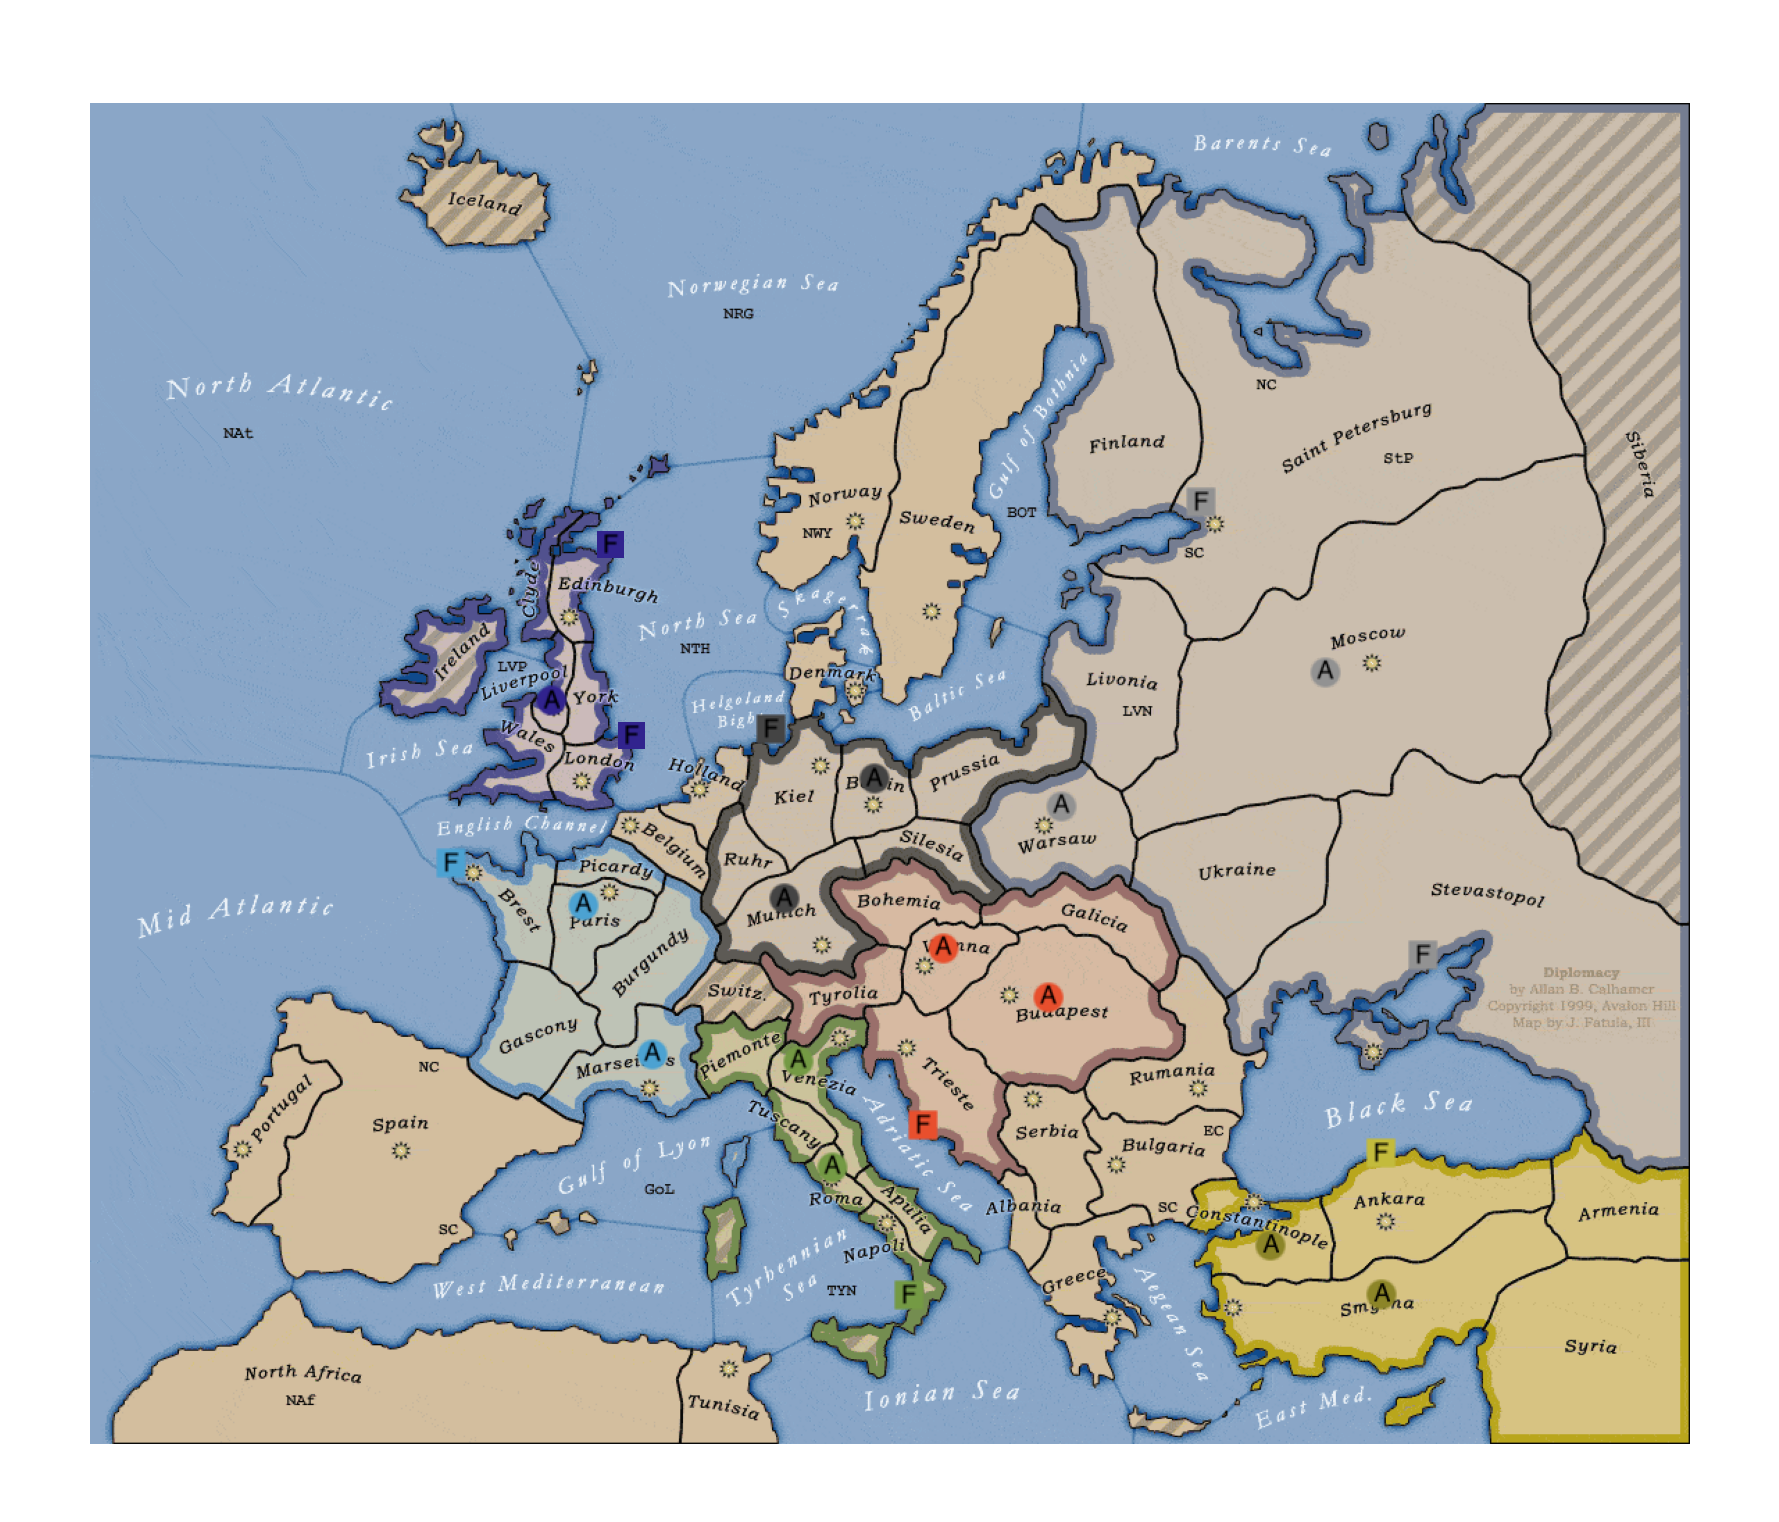

In [55]:
render_map()

In [ ]:
fig, ax = plt.subplots()
for v in total_rewards.values():
    cumulative_rewards = []
    total = 0
    for r in v:
        total += r
        cumulative_rewards.append(total)

    x, y = list(zip(*enumerate(cumulative_rewards)))
    ax.plot(x, y, alpha = 0.3)

---

Only predict for 1 unit at time

Different NN for each spot on map <- easier input

OR 

Different NN for each country <- easier training
If this probably convolutional NN with 4 layers: Where is unit, where are allies, where are enemies, where is open
1-d array? or research how to have graph as input to NN?
revised: layers = controlled SCs, enemy SCs, allied units, enemy units. if predicting for one unit at time additioiinal layer of active unit

How to determine list of possible moves? 
list all possible moves from location, run each through `check order` -- checkmark
select move from that list -- checkmark

If predict one unit at time then how will scoring work? also how will penalties for unaligned moves be attributed? May have to instead to 3 layers: Where are allies, where are enemies, where is open
Then predict moves for all at same time
How then give list of possible moves to all units simultaneously?
Not sure but I think that is what needs to happen

First make it so that comp can run through this without human intervention -- checkmark
next need to implement notion of years -- checkmark
then need to implement builds -- checkmark

check rules function: can't dislodge yourself, can't retreat to a country where units bounced -- checkmark

Resolved how to resolve simultaneously and NN for moves decision: One NN for moves, then another for builds. Predictions/Gradients/Rewards for all moves in round are stored in list, aggregated for all moves associated for given unit, discounted rewards applied for all moves associated with unit, rewards applied to gradients from each move, gradients stored for all moves over given number of rounds (currently) after which gradients are aggregated and applied to model. Everything happens without "seeing" each other, so essentially simultaneously, then aggregated over window and applied to model.

Model currently only predicts best move, not best destination, move to support/convoy, etc. Builds are not observed by a model. Will revise in future.

NN is using same values from Hands On ML example, will revise in future.

Next up test multiple games with same model and look at number of rounds. Ideally would see decrease in number of rounds over multiple games (start with 3 games) -- checkmark, honestly surprisingly few bugs and went well

After that implement NN for builds. -- checkmark. I think need to tweak. to really see improvements

After that share portion of rewards with nearby allies by graph distance. Amount of reward decays steeply over distance. -- checkmark

NOTE: The previous two changes have made games take much longer, even longer than just random choices. Can't tell if all countries are making good choices or bad choices. To test, integrate ability to toggle use of RL for moves and builds and updating gradients as well as ability to apply models to only on country. This will allow to test trained model against random choices, a better evaluation of how the model has done -- checkmark

After that implement more complex outputs for moves. Specifically focus on only predicting moves that are possible AND/OR improve probability  of support/convoy. Possible approach: Add additional array to model input that is the proportion of available move types out of all possible moves of that type. For example, if can support 20 units if units were in appropriate countries, but only 2 are actually available, then the value in the input array corresponding to support would be 2/20 = 0.1. Support would group together supporting hold and move, move would group adjacent moves and convoy moves, hold would always be 1 since always a possible option, convoy would almost always be 0 since the opportunity wouldn't present itself that often -- not doing

Alternative: make two move models, one for units in land territory and one for units in sea territories, then remove penalty for moves since any selected move will be valid and regular penalties will suffice. For builds use number of available fleet build territories as modifier for fleet build prob output from model such that if there are no fleet build territories available it is impossible to return fleet. Would still reward a bad prediction but in that unit organization the prediction is irrelevant. For all models add another input array for unit type (just 1 for army, 0 for fleet, and 0 for empty since open array will inform if 0 means fleet or open) -- checkmark

check gradients to see if they are vanishing or exploding (I think vanishing)

reorganize to only apply gradients after finish a game (add back big reward for winning) -- checkmark

revise reward scheme -- checkmarkish

add moving probability for land and sea moves, similar too builds, based on number of possible moves for each category

"The other ingredient of note present in (2
) is the subtraction of h(t)⎯⎯⎯⎯⎯⎯⎯⎯⎯
. This is the expected rewards that a random network would obtain. By pulling this out, we only reward our network if it is outperforming random choices — this results in a net speed-up of the learning process."
https://www.efavdb.com/battleship

apply random and model decision, calc reward for random and model and subtract model rewards from random rewards to arrive at final rewards for move to ensure only favoring moves that are better than random

pull moves from past games, randomly select a state and country for computer to control, use to train/evaluate model against human moves

test different optimizers with different hyperparameters

Maybe instead of having one country be the only one using the model instead of one country doing random and see how long until they are eliminated

After that add regularization approaches to model (batch normalization, dropout, though apparently those aren't used in RL, which makes sense. Research more)

Determine target territoriy (to capture or defend) and revise rewards based on success of that intent. Will need to create moves list based around that intent. This is intriguing and most likely will yield better coordinated moves (beyond sharing rewards), but first exhaust infrastructure around selecting moves rather than destinations

explore possibility or transferring weights between identical configurations. This sounds like Q-learning, but instead of using the entire board as the as the state instead define the state as only the local interactions, the state may be replicated in different parts of the map and so learning can be transferred and sped up. Whenever move into deep-q explore this

After that add more dynamic prediction outputs rather than just type of move. Most likely this will be easier after implementing destination methodology for move selection but not dependent on it so can still develop independently. May need to research how to implement NN with variable size outputs.

Lessons learned about NNs/RL:
- When using Gradient Tape everything needs to happen within the `with` statement
- When using Gradient Tape only call the model, don't call predict. Tape doesn't automatically see predict, would need to manually add to watch, seems like an unnecessary step
- Don't allow impossible outputs from model and add tooling to accomodate for that, instead make multiple models tuned for different scenarios (sea vs land moves for convoy)

In [ ]:
pd.DataFrame([('Gascony', 'army'),
 ('Brest', 'fleet'),
 ('Marseiles', 'army'),
 ('Picardy', 'fleet'),
 ('Burgundy', 'army'),
 ('Paris', 'army')])

---

# Broken or needs work

convoy
builds
colored icons

In [ ]:
resolved_orders = resolve_submitted_moves(full_orders_test)
# resolved_orders

In [ ]:
need_retreat = resolved_orders[resolved_orders['dislodged']]
# need_retreat

In [ ]:
retreat_orders = []

if len(retreat_orders) > 0:
    resolved_retreats = resolve_submitted_moves(retreat_orders)
    for c in resolved_retreats['start']:
        resolved_orders.loc[resolved_orders['start']==c] = resolved_retreats[resolved_retreats['start']==c].values

units_df = resolved_orders[resolved_orders['success']].merge(units_df, how = 'left', left_on = 'start', right_on = 'location')[['end', 'type', 'owner']]
units_df.columns = ['location', 'type', 'owner']

In [ ]:
units_df

In [ ]:
retreat_test = pd.DataFrame(
    {'start': ['Ruhr', 'Munich', 'Burgundy'],
     'order': ['support', 'move', 'retreat'],
     'end': ['Ruhr', 'Burgundy', 'Burgundy'],
     'support': [['Munich', 'Burgundy'], None, None],
     'convoy': [None, None, None],
     'count': [0.0, 2.0, 1.0],
     'success': [True, True, False],
     'dislodged': [False, False, True]}
)

retreat_test

In [ ]:
units_df = pd.DataFrame(
    {
        'location': ['Ruhr', 'Munich', 'Burgundy', 'Paris', 'Picardy', 'Belgium', 'Marseiles', 'Gascony'],
        'type': ['army']*8,
        'owner': ['Germany', 'Germany', 'France', 'Framce', 'France', 'Germany', 'France', 'France']
    }
)

In [ ]:
units_df

In [ ]:
retreat_test[retreat_test['dislodged']]

In [105]:
resolve_retreat_test = resolve_submitted_moves([['Burgundy', 'retreat', 'Marseiles']])

AssertionError: no unit in Burgundy

In [ ]:
resolve_retreat_test

In [ ]:
retreat_test

In [ ]:
# resolve_retreat_test[resolve_retreat_test['start']==c].values
for c in resolve_retreat_test['start']:
    retreat_test.loc[retreat_test['start']==c] = resolve_retreat_test[resolve_retreat_test['start']==c].values

In [ ]:
retreat_test

---

In [ ]:
o = input('input all orders: ')

In [ ]:
full_orders_test

In [ ]:
resolved_orders = resolve_submitted_moves(ast.literal_eval(o))
resolved_orders

In [ ]:
need_retreat = resolved_orders[resolved_orders['dislodged']]
print('These countries need to retreat:', need_retreat['start'].tolist())

In [ ]:
if len(need_retreat) > 0:
    r = input('Enter orders for retreats: ')
    resolved_retreats = resolve_submitted_moves(ast.literal_eval(r))
    for c in resolved_retreats['start']:
        resolved_orders.loc[resolved_orders['start']==c] = resolved_retreats[resolved_retreats['start']==c].values

In [ ]:
units_df = resolved_orders[resolved_orders['success']].merge(units_df, how = 'left', left_on = 'start', right_on = 'location')[['end', 'type', 'owner']]
units_df.columns = ['location', 'type', 'owner']

In [ ]:
units_df

In [ ]:
dip_map = plt.imread('personal/diplomacy_map.gif')
fleet_icon = plt.imread('personal/fleet_icon.png')
army_icon = plt.imread('personal/army_icon.png')
fig, ax = plt.subplots(figsize = (15, 15))
plt.imshow(dip_map)

#plt.imshow(355, 585, army_icon, ax = ax)
# north_africa_army = plt.plot(240, 925, 'ro')
# north_africa_fleet = plt.plot(240, 885, 'ro')
# west_med = plt.plot(320, 850, 'ro')
# tunisia_army = plt.plot(450, 925, 'ro')
# tunisia_fleet = plt.plot(470, 895, 'ro')
# ionian_sea = plt.plot(620, 925, 'ro')
# aegean_sea = plt.plot(780, 900, 'ro')
# eastern_med = plt.plot(880, 940, 'ro')
# syria_fleet = plt.plot(1005, 940, 'ro')
# syria_army = plt.plot(1080, 900, 'ro')
# armenia_army = plt.plot(1100, 800, 'ro')
# armenia_fleet = plt.plot(1060, 750, 'ro')
# ankara_army = plt.plot(930, 800, 'ro')
# ankara_fleet = plt.plot(930, 760, 'ro')
# smyrna_army = plt.plot(930, 860, 'ro')
# smyrna_fleet = plt.plot(900, 900, 'ro')
# constantinople_army = plt.plot(850, 825, 'ro')
# constantinople_fleet = plt.plot(830, 804, 'ro')
# tyrrhenian_sea = plt.plot(500, 830, 'ro')
# gulf_of_lyon = plt.plot(390, 760, 'ro')
# adriatic_sea = plt.plot(600, 760, 'ro')
# black_sea = plt.plot(930, 720, 'ro')
# mid_atlantic_ocean = plt.plot(100, 580, 'ro')
# north_atlantic_ocean = plt.plot(150, 200, 'ro')
# norwegian_sea = plt.plot(475, 130, 'ro')
# barents_sea = plt.plot(860, 25, 'ro')
# gulf_of_bothnia = plt.plot(680, 320, 'ro')
# baltic_sea = plt.plot(610, 435, 'ro')
# skagerrack = plt.plot(540, 345, 'ro')
# north_sea = plt.plot(430, 345, 'ro')
# helgoland_bight = plt.plot(460, 435, 'ro')
# irish_sea = plt.plot(235, 465, 'ro')
# english_channel = plt.plot(290, 520, 'ro')
# portugal_fleet = plt.plot(95, 750, 'ro')
# portugal_army = plt.plot(125, 740, 'ro')
# spain_army = plt.plot(225, 755, 'ro')
# spain_nc = plt.plot(225, 670, 'ro')
# spain_sc = plt.plot(255, 825, 'ro')
# gascony_fleet = plt.plot(290, 650, 'ro')
# gascony_army = plt.plot(320, 670, 'ro')
# brest_army = plt.plot(310, 585, 'ro')
# brest_fleet = plt.plot(260, 555, 'ro')
# picardy_fleet = plt.plot(350, 533, 'ro')
# picardy_army = plt.plot(375, 543, 'ro')
# paris = plt.plot(355, 585, 'ro')
# burgundy = plt.plot(400, 615, 'ro')
# marseiles_army = plt.plot(405, 690, 'ro')
# marseiles_fleet = plt.plot(370, 710, 'ro')
# piedmont_fleet = plt.plot(465, 705, 'ro')
# piedmont_army = plt.plot(460, 680, 'ro')
# venice_army = plt.plot(510, 695, 'ro')
# venice_fleet = plt.plot(530, 710, 'ro')
# tuscany_army = plt.plot(515, 735, 'ro')
# tuscany_fleet = plt.plot(490, 735, 'ro')
# rome_army = plt.plot(535, 770, 'ro')
# rome_fleet = plt.plot(535, 790, 'ro')
# apulia_fleet = plt.plot(590, 780, 'ro')
# apulia_army = plt.plot(600, 810, 'ro')
# naples_army = plt.plot(570, 805, 'ro')
# naples_fleet = plt.plot(590, 860, 'ro')
# greece_army = plt.plot(700, 840, 'ro')
# greece_fleet = plt.plot(700, 890, 'ro')
# bulgaria_sc = plt.plot(775, 805, 'ro')
# bulgaria_army = plt.plot(775, 755, 'ro')
# bulgaria_ec = plt.plot(815, 755, 'ro')
# rumania_fleet = plt.plot(830, 710, 'ro')
# rumania_army = plt.plot(760, 710, 'ro')
# serbia = plt.plot(690, 740, 'ro')
# albania_army = plt.plot(675, 815, 'ro')
# albania_fleet = plt.plot(660, 790, 'ro')
# trieste_army = plt.plot(620, 700, 'ro')
# trieste_fleet = plt.plot(600, 740, 'ro')
# budapest = plt.plot(690, 650, 'ro')
# galicia = plt.plot(740, 590, 'ro')
# vienna = plt.plot(615, 615, 'ro')
# tyrolia = plt.plot(570, 625, 'ro')
# bohemia = plt.plot(575, 575, 'ro')
# munich = plt.plot(500, 580, 'ro')
# silesia = plt.plot(610, 530, 'ro')
# prussia_army = plt.plot(620, 485, 'ro')
# prussia_fleet = plt.plot(640, 450, 'ro')
# berlin_fleet = plt.plot(570, 455, 'ro')
# berlin_army = plt.plot(565, 495, 'ro')
# kiel_army = plt.plot(510, 495, 'ro')
# kiel_fleet = plt.plot(490, 460, 'ro')
# ruhr = plt.plot(470, 540, 'ro')
# belgium_army = plt.plot(420, 535, 'ro')
# belgium_fleet = plt.plot(395, 505, 'ro')
# holland_fleet = plt.plot(430, 485, 'ro')
# holland_army = plt.plot(442, 505, 'ro')
# denmark_army = plt.plot(515, 405, 'ro')
# denmark_fleet = plt.plot(540, 420, 'ro')
# norway_army = plt.plot(540, 280, 'ro')
# norway_fleet = plt.plot(480, 330, 'ro')
# sweden_army = plt.plot(595, 330, 'ro')
# sweden_fleet = plt.plot(650, 310, 'ro')
# finland_fleet = plt.plot(685, 250, 'ro')
# finland_army = plt.plot(740, 250, 'ro')
# st_petersburg_army = plt.plot(890, 250, 'ro')
# st_petersburg_nc = plt.plot(845, 185, 'ro')
# st_petersburg_sc = plt.plot(800, 300, 'ro')
# moscow = plt.plot(890, 420, 'ro')
# livonia_army = plt.plot(740, 420, 'ro')
# livonia_fleet = plt.plot(730, 375, 'ro')
# warsaw = plt.plot(700, 515, 'ro')
# ukraine = plt.plot(830, 550, 'ro')
# sevastopol_army = plt.plot(960, 550, 'ro')
# sevastopol_fleet = plt.plot(960, 620, 'ro')
# edinburgh_fleet = plt.plot(375, 330, 'ro')
# edinburgh_army = plt.plot(340, 360, 'ro')
# york_army = plt.plot(355, 440, 'ro')
# york_fleet = plt.plot(360, 405, 'ro')
# london_army = plt.plot(350, 480, 'ro')
# london_fleet = plt.plot(390, 465, 'ro')
# whales_army = plt.plot(315, 455, 'ro')
# whales_fleet = plt.plot(280, 480, 'ro')
# liverpool_army = plt.plot(332, 440, 'ro')
# liverpool_fleet = plt.plot(332, 415, 'ro')
# clyde_army = plt.plot(325, 375, 'ro')
# clyde_fleet = plt.plot(335, 295, 'ro')
# north_africa_army
# north_africa_fleet
# west_med
# tunisia_army
# tunisia_fleet
# ionian_sea
# aegean_sea
# eastern_med
syria_fleet
syria_army
armenia_army
armenia_fleet
ankara_army
ankara_fleet
smyrna_army
smyrna_fleet
constantinople_army
constantinople_fleet
# tyrrhenian_sea
# gulf_of_lyon
# adriatic_sea
# black_sea
# mid_atlantic_ocean
# north_atlantic_ocean
# norwegian_sea
# barents_sea
# gulf_of_bothnia
# baltic_sea
# skagerrack
# north_sea
# helgoland_bight
# irish_sea
# english_channel
# portugal_fleet
# portugal_army
# spain_army
# spain_nc
# spain_sc
gascony_fleet
gascony_army
brest_army
brest_fleet
picardy_fleet
picardy_army
paris
burgundy
marseiles_army
marseiles_fleet
# piedmont_fleet
# piedmont_army
# venice_army
# venice_fleet
# tuscany_army
# tuscany_fleet
# rome_army
# rome_fleet
# apulia_fleet
# apulia_army
# naples_army
# naples_fleet
# greece_army
# greece_fleet
# bulgaria_sc
# bulgaria_army
# bulgaria_ec
# rumania_fleet
# rumania_army
# serbia
# albania_army
# albania_fleet
# trieste_army
# trieste_fleet
# budapest
# galicia
# vienna
# tyrolia
# bohemia
# munich
# silesia
# prussia_army
# prussia_fleet
# berlin_fleet
# berlin_army
# kiel_army
# kiel_fleet
# ruhr
# belgium_army
# belgium_fleet
# holland_fleet
# holland_army
# denmark_army
# denmark_fleet
# norway_army
# norway_fleet
# sweden_army
# sweden_fleet
finland_fleet
finland_army
st_petersburg_army
st_petersburg_nc
st_petersburg_sc
moscow
livonia_army
livonia_fleet
warsaw
ukraine
sevastopol_army
sevastopol_fleet
# edinburgh_fleet
# edinburgh_army
# york_army
# york_fleet
# london_army
# london_fleet
# whales_army
# whales_fleet
# liverpool_army
# liverpool_fleet
# clyde_army
# clyde_fleet
# plt.plot(1151, 964, 'ro')

In [ ]:
paris_x = [290, 320, 310, 260, 350, 375, 355, 400, 405, 370]
paris_y = [650, 670, 585, 555, 533, 543, 585, 615, 690, 710]

russia_x = [685,740,890,845,800,890,740,730,700,830,960,960]
russia_y = [250,250,250,185,300,420,420,375,515,550,550,620]

turkey_x = [1005, 1080, 1100, 1060, 930, 930, 930, 900, 850, 830]
turkey_y = [940, 900, 800, 750, 800, 760, 860, 900, 825, 804]

italy_x = [465, 460, 510, 530, 515, 490, 535, 535, 590, 600, 570, 590]
italy_y = [705, 680, 695, 710, 735, 735, 770, 790, 780, 810, 805, 860]

austria_x = [620, 600, 690, 740, 615, 570, 575]
austria_y = [700, 740, 650, 590, 615, 625, 575]

england_x = [375, 340, 355, 360, 350, 390, 315, 280, 332, 332, 325, 335]
england_y = [330, 360, 440, 405, 480, 465, 455, 480, 440, 415, 375, 295]

germany_x = [500, 610, 620, 640, 570, 565, 510, 490, 470]
germany_y = [580, 530, 485, 450, 455, 495, 495, 460, 540]

x = paris_x + russia_x + turkey_x + italy_x + austria_x + england_x + germany_x
y = paris_y + russia_y + turkey_y + italy_y + austria_y + england_y + germany_y

x, y = np.atleast_1d(x, y)
###################
fig, ax = plt.subplots(figsize = (22.7, 19.51))

dip_map = plt.imread('personal/diplomacy_map.gif')
dip_im = OffsetImage(dip_map, zoom = 1)
dip_ab = AnnotationBbox(dip_im, (0, 0), xycoords = 'data', frameon = False, box_alignment = (0, 0))
ax.add_artist(dip_ab)
fleet_icon = plt.imread('personal/fleet_icon.png')
fleet_im = OffsetImage(fleet_icon, zoom = 1)
army_icon = plt.imread('personal/army_icon.png')
army_im = OffsetImage(army_icon, zoom = 1)
for _, row in units_df.iterrows():
    x0, y0 = territories[row['location']]['coords'][row['type']]
    if row['type'] == 'army':
        ab = AnnotationBbox(army_im, (x0, 965-y0), xycoords = 'data', frameon = False)#, box_alignment = (0, 0)
    else:
        ab = AnnotationBbox(fleet_im, (x0, 965-y0), xycoords = 'data', frameon = False)#, box_alignment = (0, 0)
    ax.add_artist(ab)
# for x0, y0 in zip(x, y):
#     fleet_ab = AnnotationBbox(fleet_im, (x0, 965-y0), xycoords = 'data', frameon = False)#, box_alignment = (0, 0)
#     ax.add_artist(fleet_ab)
ax.update_datalim(np.column_stack([[0, 1152], [0, 965]]))
ax.autoscale()
plt.axis('off');

In [ ]:
x = []
y = []
for l, t in zip(units_df['location'], units_df['type']):
    c = territories_df.loc[territories_df['country'] == l, 'coords'].values[0][t]
    x.append(c[0])
    y.append(c[1])

render_map(x, y)